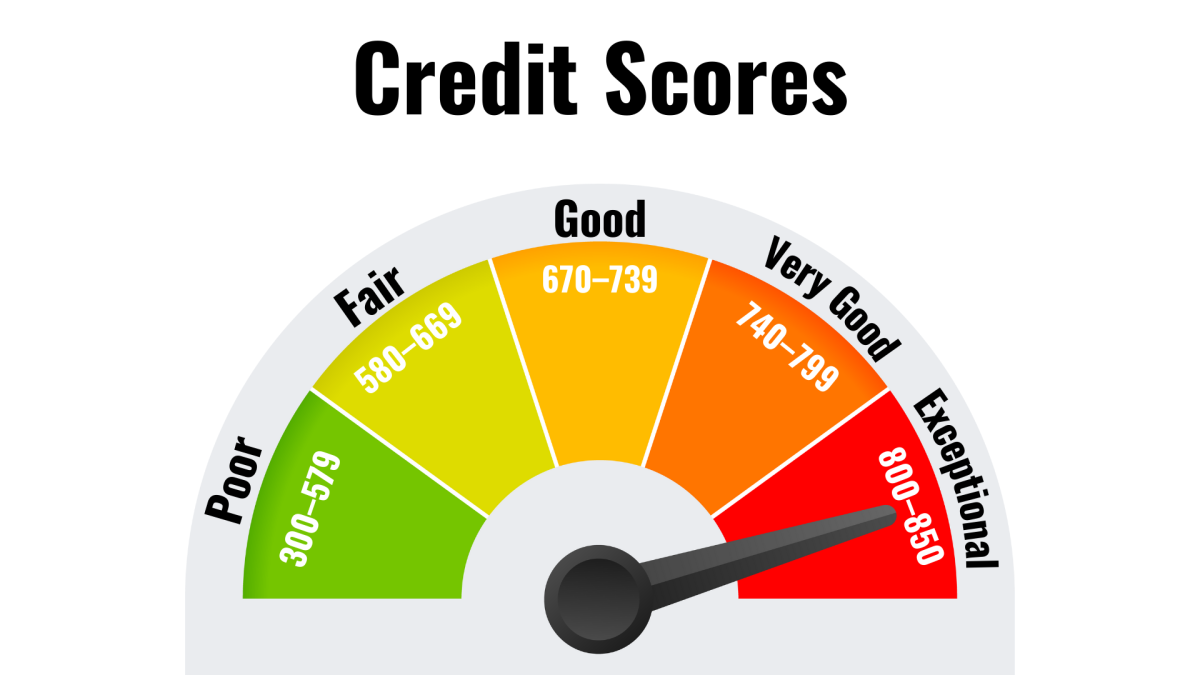

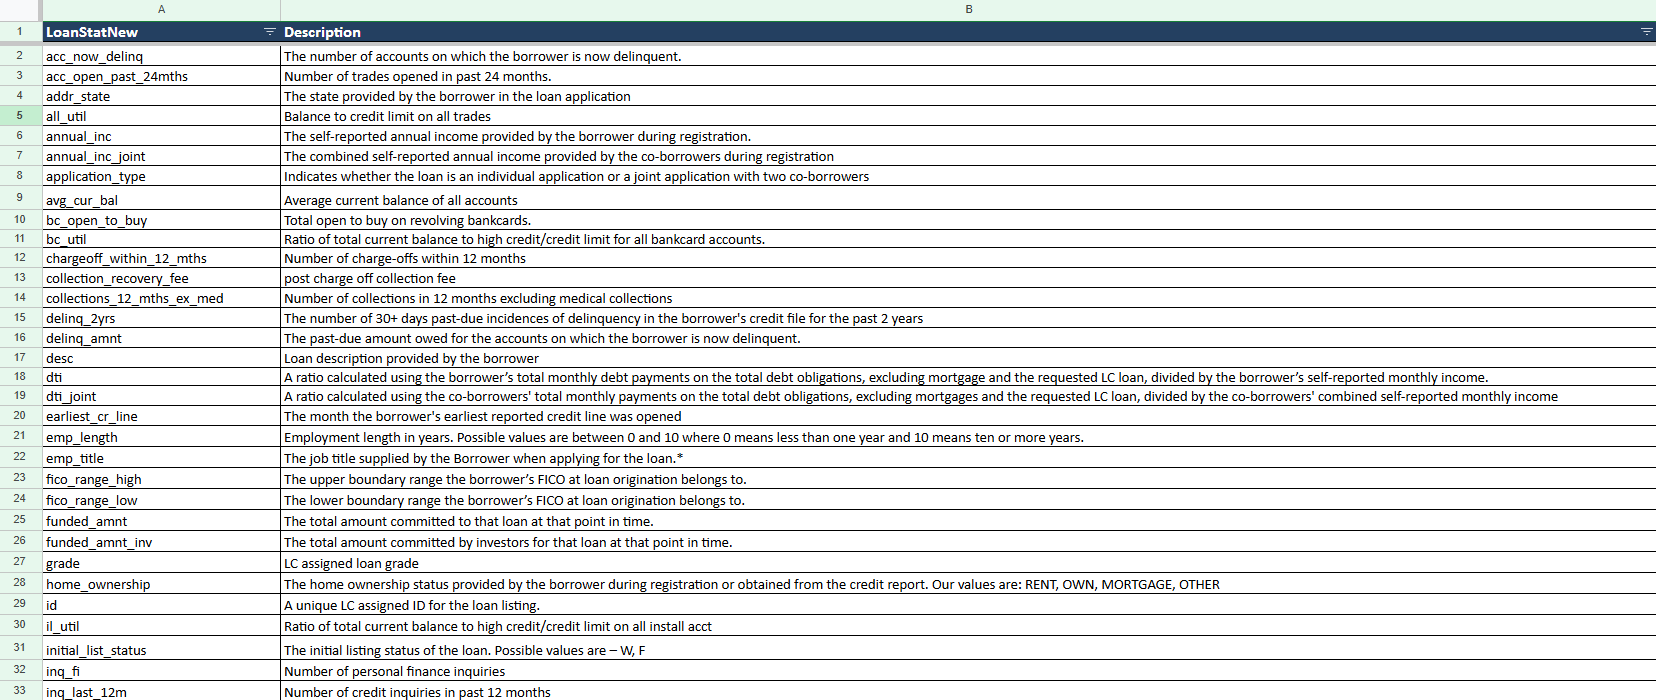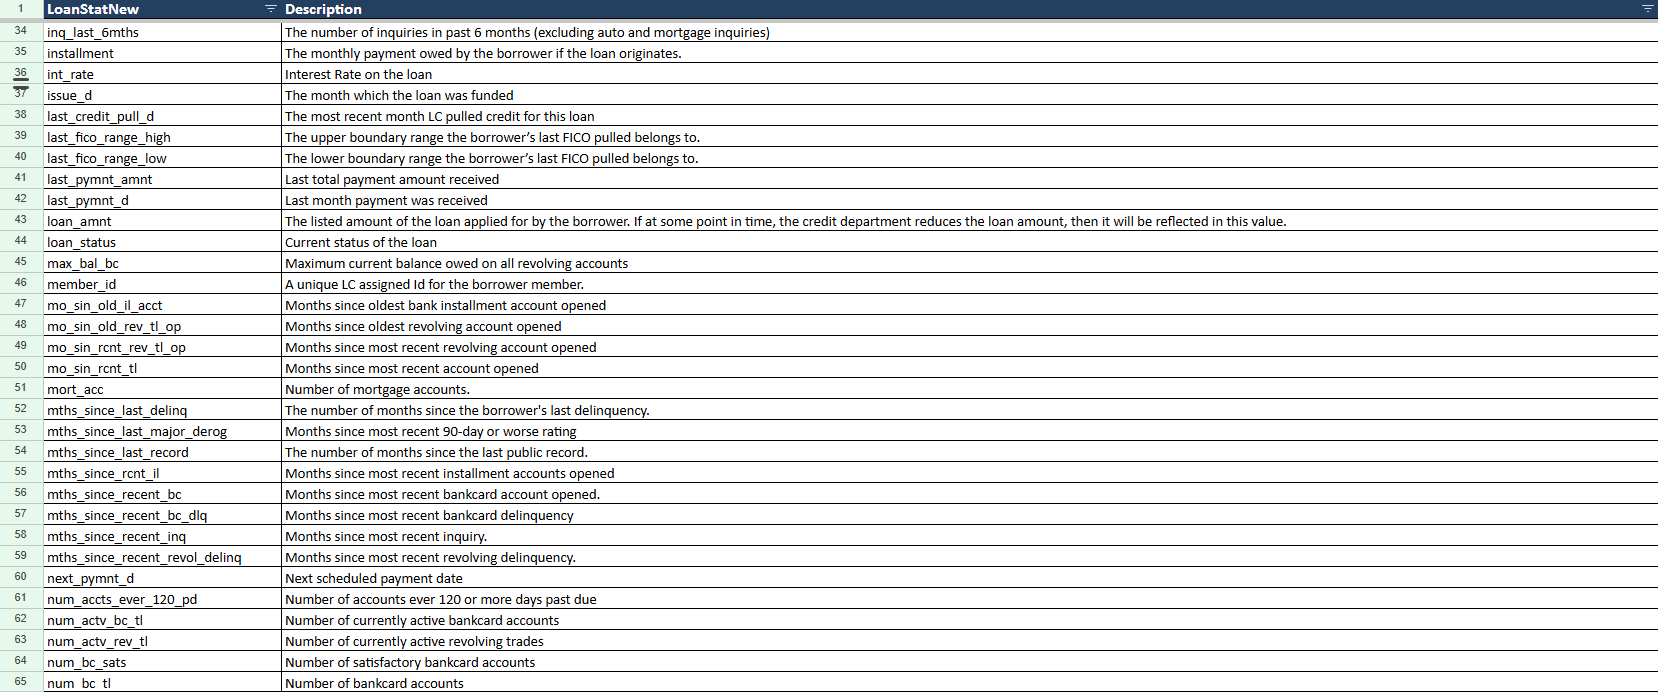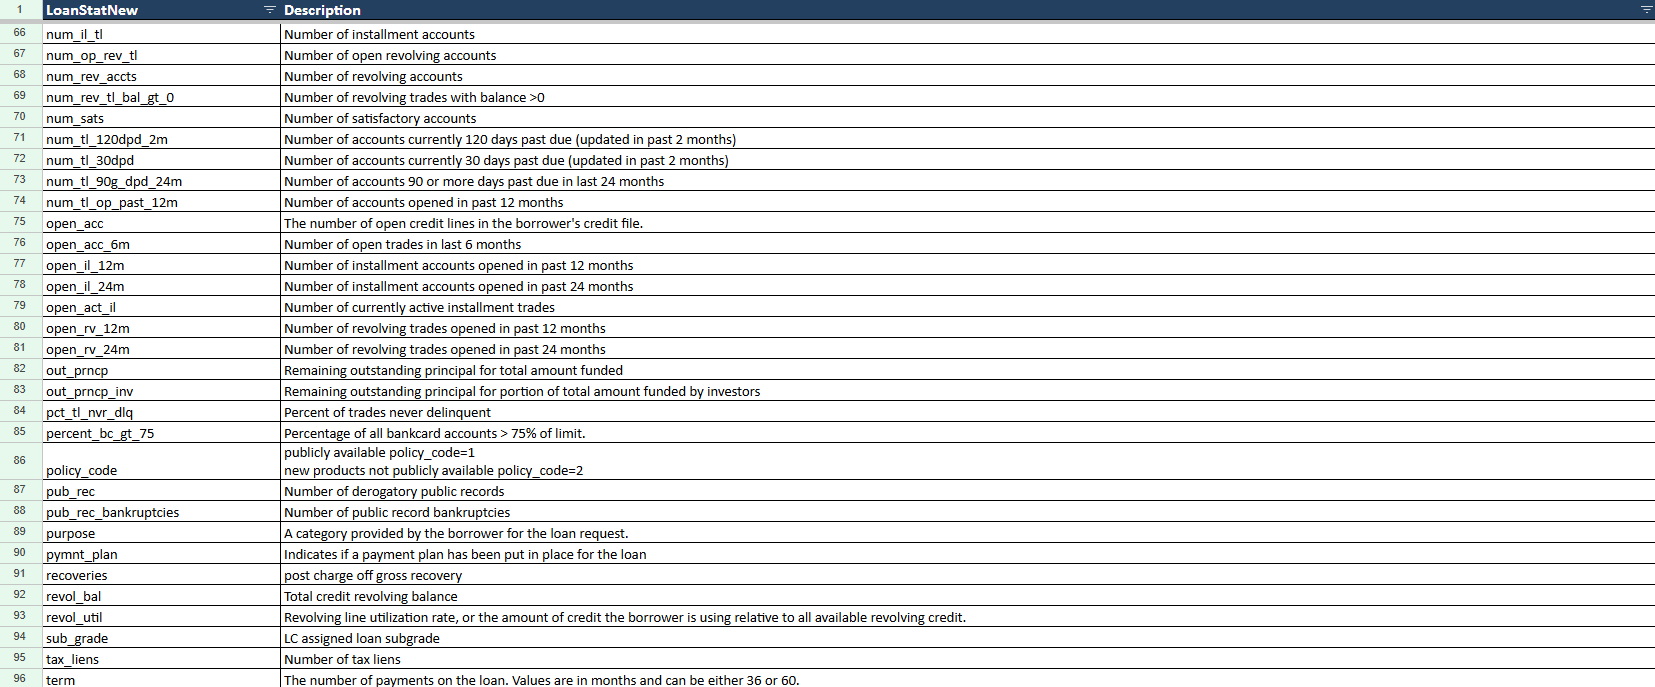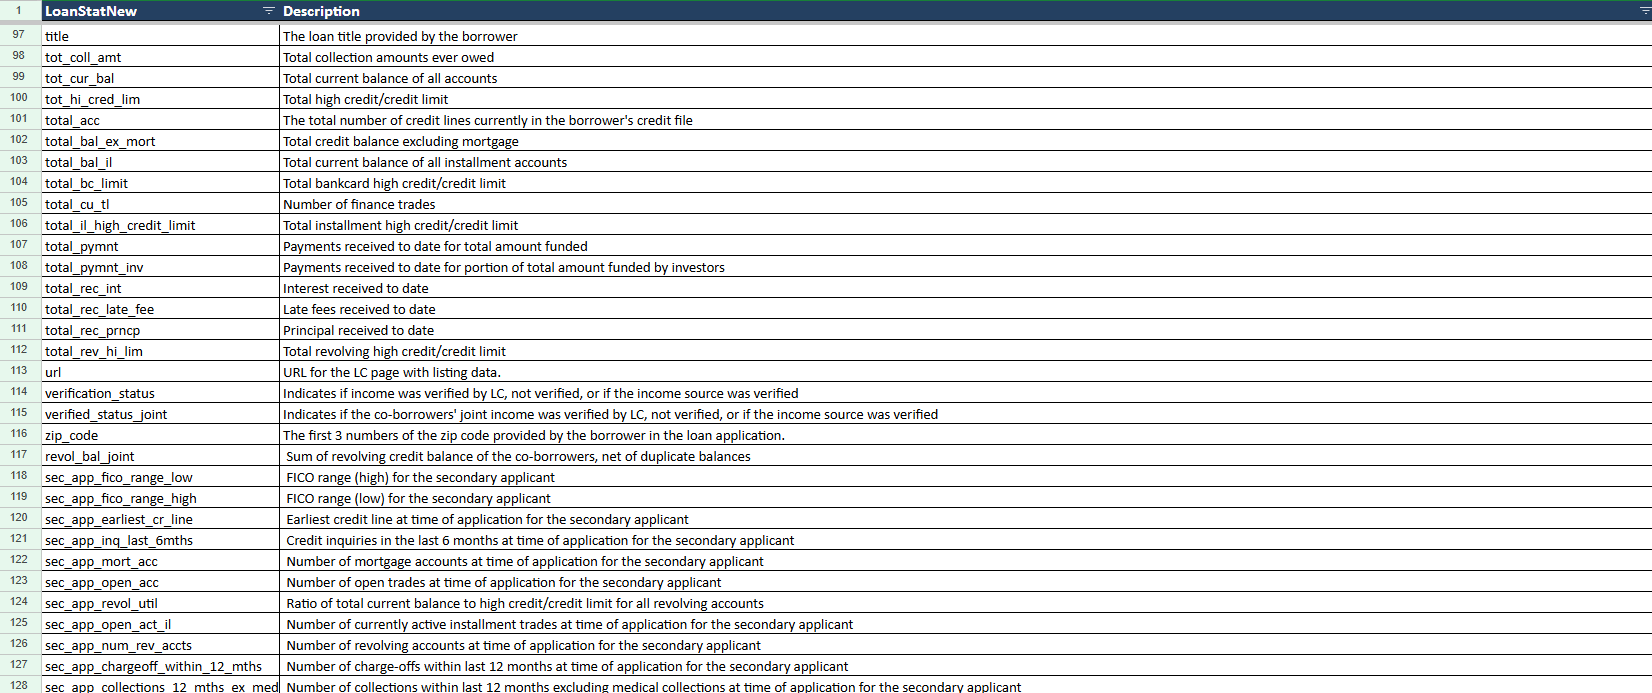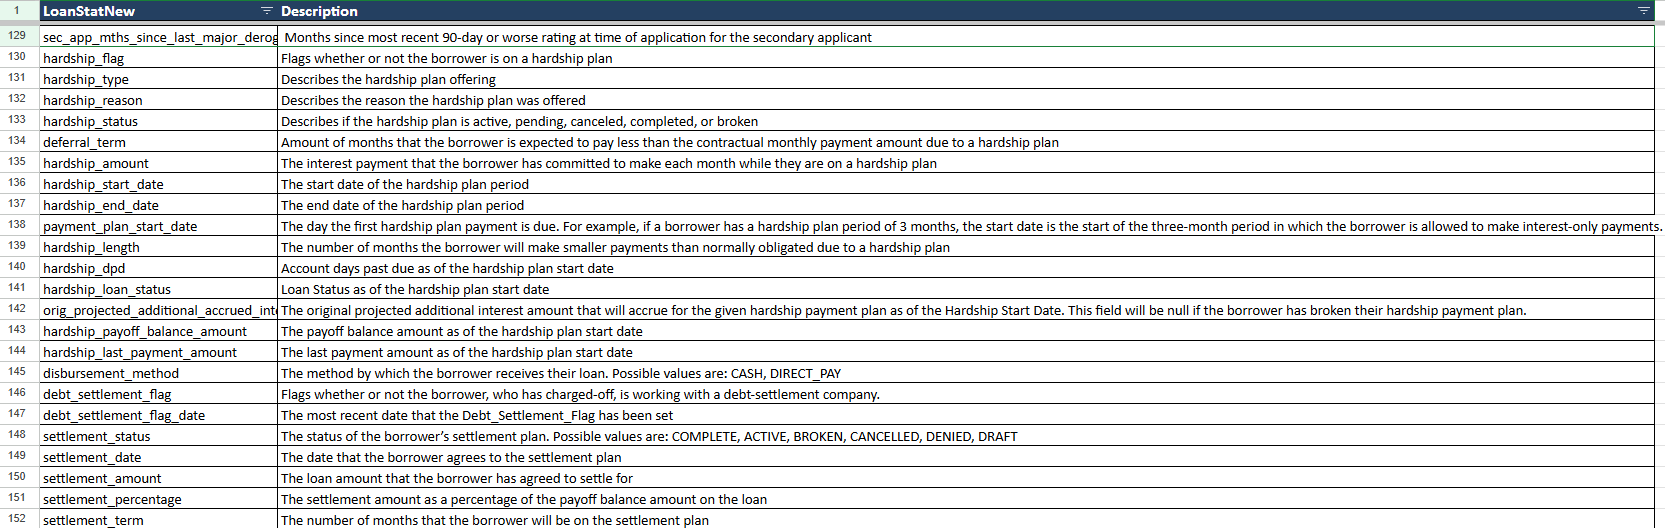

In [1]:
# pip installations
!pip -q install dill optbinning lightgbm pyngrok xgboost catboost scikit-fuzzy category_encoders pygam prettytable tabulate matplotlib-venn geopandas osmnx dask[dataframe] ortools==9.7.2996 openai shapely shap openai==0.28 scikit-learn==1.2.2 imbalanced-learn==0.12.2

In [2]:
# import libraries
import os
import re
import sys
import json
import flask
import time
import shap
import dill
import torch
import openai
import random
import pickle
import joblib
import hashlib
import psutil
import warnings
import requests
import logging
import subprocess
import optbinning
import osmnx as ox
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pylab as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from tqdm import tqdm
from scipy.stats import beta
from pyngrok import ngrok
from sklearn import metrics
from sklearn.svm import SVC
from itertools import cycle
from osmnx import _overpass
from datetime import datetime
from tabulate import tabulate
from google.colab import drive
from tabulate import tabulate
from scipy.stats import ks_2samp
from sklearn.utils import shuffle
from sklearn.utils import shuffle
from pygam import LogisticGAM, s
from prettytable import PrettyTable
from matplotlib_venn import venn2
from sklearn.utils import resample
from sklearn.cluster import KMeans
from pygam import LinearGAM, s
from xgboost import XGBClassifier
from sklearn.utils import resample
from joblib import Parallel, delayed
from IPython.display import display
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from catboost import CatBoostClassifier
from huggingface_hub import hf_hub_download
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from category_encoders import TargetEncoder
from sklearn import model_selection, metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from scipy.interpolate import UnivariateSpline
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import RobustScaler
from optbinning import BinningProcess, Scorecard
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from flask import Flask, request, jsonify, render_template
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import VarianceThreshold
from shapely.geometry import Point, MultiPolygon, Polygon
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tenacity import retry, stop_after_attempt, wait_exponential
from sklearn.preprocessing import StandardScaler, LabelEncoder
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from sklearn.linear_model import PoissonRegressor, BayesianRidge
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_recall_curve, auc, brier_score_loss, roc_auc_score, log_loss
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, brier_score_loss

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ImportWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="osmnx._overpass")
warnings.filterwarnings("ignore", category=ImportWarning, module="importlib._bootstrap")

pd.set_option("display.max_columns", None)
plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load datasets

In [5]:
# Load credit dataset
train_df = pd.read_csv('/content/drive/MyDrive/FYP /AI Alignment/Test/data/Credit_Loan_Data.csv')

In [6]:
# Load meterological data
df_loaded = pd.read_csv('/content/drive/MyDrive/FYP /AI Alignment/Test/data/preprocessing.csv')

#Exploratory Data Analysis (EDA)

In [7]:
print(train_df.shape)

(100000, 147)


In [8]:
print(train_df.isna().sum())

id                           0
member_id                    0
loan_amnt                    0
funded_amnt                  0
funded_amnt_inv              0
                         ...  
settlement_status        99999
settlement_date          99999
settlement_amount        99999
settlement_percentage    99999
settlement_term          99999
Length: 147, dtype: int64


In [9]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 147 entries, id to settlement_term
dtypes: float64(54), int64(56), object(37)
memory usage: 112.2+ MB
None


In [10]:
print(tabulate(train_df.head(), headers='keys', tablefmt='pretty'))

+---+----+-----------+-----------+-------------+-----------------+-----------+----------+-------------+-------+-----------+----------------+------------+----------------+--------------------+-----------------+------------+---------------------+---------+-------------+------------+-----+------+--------------------+--------------------+----------+------------+-------+-------------+------------------+----------------+------------------------+------------------------+----------+---------+-----------+------------+-----------+---------------------+-----------+---------------+-------------+-----------------+-----------------+---------------+--------------------+------------+-------------------------+--------------+-----------------+--------------+--------------------+----------------------------+-----------------------------+-------------+------------------+------------------+-----------+---------------------------+----------------+--------------+-------------+-------------+-------------+----

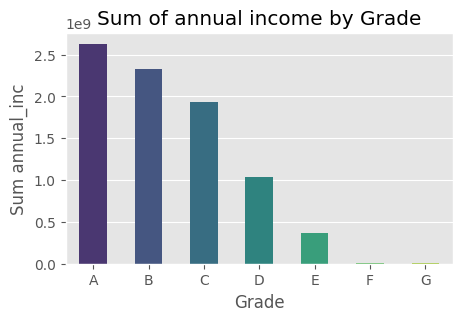

In [11]:
def plot_sum_of_numarical_col_by_grade(col):
  sum__by_grade = train_df.groupby('grade')[col].sum().reset_index()
  plt.figure(figsize=(5, 3))
  sns.barplot(x='grade', y=col, data=sum__by_grade, palette='viridis', width=.5)
  plt.title(f'Sum of annual income by Grade')
  plt.xlabel('Grade')
  plt.ylabel(f'Sum {col}')
  plt.show()

plot_sum_of_numarical_col_by_grade('annual_inc')

<Axes: xlabel='grade', ylabel='annual_inc'>

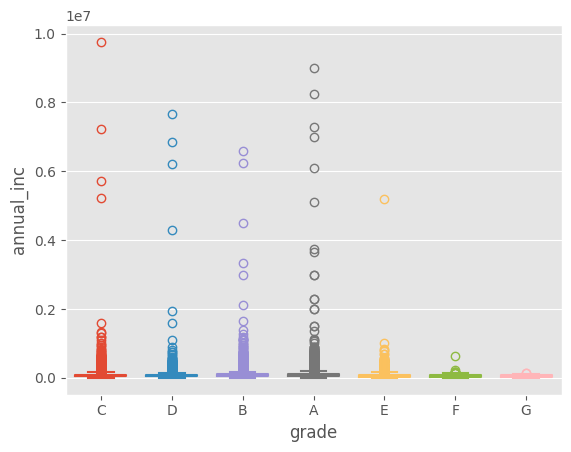

In [12]:
sns.boxplot(data=train_df, x="grade", y="annual_inc", hue="grade", fill=False, gap=.1)

In [13]:
# Partial Masking Function
def partial_mask(text, num_visible=4):
  if pd.isna(text):
    return text
  return '*' * (len(text) - num_visible) + text[-num_visible:]

# anonymization for PII columns
def anonymize_pii_columns(df, pii_columns):
  def hash_text(text):
    if pd.isna(text):
      return text
    return hashlib.sha256(text.encode()).hexdigest()

  for col in pii_columns:
    if col == 'zip_code':
      df[col] = df[col].apply(lambda x: partial_mask(str(x), num_visible=4))
  return df

In [14]:
# PII columns
pii_columns = ['zip_code', 'member_id']

# anonymize PII columns in train set
train_df = anonymize_pii_columns(train_df, pii_columns)

In [15]:
# Numeric feature distribution
numeric_features = train_df.select_dtypes(include=['number']).columns.drop('id', 'member_id')

In [16]:
num_features = len(numeric_features)
num_rows = (num_features + 2) // 3

fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 4))
axs = axs.flatten()

for i, col in enumerate(numeric_features):
  sns.histplot(train_df[col], ax=axs[i], kde=True, bins=30)
  axs[i].set_title(f'{col}', fontsize=12)
  axs[i].set_xlabel(col, fontsize=10)
  axs[i].set_ylabel('Frequency', fontsize=10)

for j in range(i + 1, len(axs)):
  axs[j].set_visible(False)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Data Cleaning & Preprocessing

In [17]:
# drop columns where all records are empty
def drop_empty_columns(df):
  df.dropna(axis=1, how='all', inplace=True)

In [18]:
# convert binary columns
def convert_binary_columns(df):
  binary_map = {'Yes': 1, 'No': 0}
  object_cols = df.select_dtypes(include=['object']).columns

  for col in object_cols:
    if col not in ['grade', 'sub_grade']:
      unique_vals = df[col].dropna().unique()
      if set(unique_vals).issubset({'Yes', 'No'}):
        df[col] = df[col].map(binary_map).astype(int)

In [19]:
def clean_numeric_columns(df):
  def clean_column(column):
    if column.dtype == 'object' and column.name not in ['id', 'member_id',  'grade', 'sub_grade', 'zip_code', 'emp_title', 'loan_purpose', 'loan_issue_date', 'home_ownership',
                                                        'purpose', 'title', 'loan_status', 'verification_status', 'application_type', 'addr_state', 'verification_status_joint',
                                                        'issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'disbursement_method', 'sec_app_earliest_cr_line']:

      return pd.to_numeric(column.str.replace(r'[^0-9.]', '', regex=True), errors='coerce')
    else:
      return column

  numeric_cols = df.select_dtypes(include=['float64', 'int64', 'object']).columns
  for col in numeric_cols:
    df[col] = clean_column(df[col])

In [20]:
# Impute missing values in numeric columns with the median
def impute_numeric_columns(df):
  numeric_cols = df.select_dtypes(include=np.number).columns
  # Exclude columns that contain only NaN values
  cols_with_missing = [col for col in numeric_cols if df[col].notnull().any() and df[col].isnull().any()]

  if cols_with_missing:
    num_imputer = SimpleImputer(strategy='median')
    imputed_data = num_imputer.fit_transform(df[cols_with_missing])
    imputed_df = pd.DataFrame(imputed_data, columns=cols_with_missing, index=df.index)
    for col in cols_with_missing:
      df[col] = df[col].fillna(imputed_df[col])

  for col in cols_with_missing:
    if (df[col] % 1 == 0).all():
      df[col] = df[col].astype(int)

In [21]:
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns

def impute_categorical_columns(df):
  # Impute missing values in categorical columns with the most frequent value
  cols_with_missing = [col for col in categorical_cols if df[col].notnull().any() and df[col].isnull().any()]

  if cols_with_missing:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    imputed_data = cat_imputer.fit_transform(df[cols_with_missing])
    imputed_df = pd.DataFrame(imputed_data, columns=cols_with_missing, index=df.index)

    for col in cols_with_missing:
      df[col] = df[col].fillna(imputed_df[col])

In [22]:
def flatten_list_like_columns(df):
  # Flatten any list-like elements in categorical columns
  categorical_cols = df.select_dtypes(include=['object', 'category']).columns

  for col in categorical_cols:
    if col not in ['grade', 'sub_grade']:
      df[col] = df[col].astype(object)
      if df[col].apply(lambda x: isinstance(x, list)).any():
        df[col] = df[col].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
      df[col] = df[col].astype('category')

In [23]:
def map_grade_column(df):
  # Fill missing 'grade' values with the mode
  grade_mode = df['grade'].mode()[0]
  df['grade'] = df['grade'].fillna(grade_mode)
  grade_mapping = {'A': 1, 'B': 1, 'C': 1, 'D': 0, 'E': 0}
  df['grade'] = df['grade'].map(grade_mapping).fillna(grade_mapping.get(grade_mode, grade_mode))

In [24]:
def preprocess_dataset(df):
  drop_empty_columns(df)
  convert_binary_columns(df)
  clean_numeric_columns(df)
  impute_numeric_columns(df)
  impute_categorical_columns(df)
  flatten_list_like_columns(df)
  map_grade_column(df)

  return df

In [25]:
cleaned_dataset = preprocess_dataset(train_df)
cleaned_dataset['grade'] = cleaned_dataset['grade'].astype(int)
train_df = cleaned_dataset
train_df.head(10)

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  \
0   1     100000       2500         2500             2500    36     13.56   
1   2     100001      30000        30000            30000    60     18.94   
2   3     100002       5000         5000             5000    36     17.97   
3   4     100003       4000         4000             4000    36     18.94   
4   5     100004      30000        30000            30000    60     16.14   
5   6     100005       5550         5550             5550    36     15.02   
6   7     100006       2000         2000             2000    36     17.97   
7   8     100007       6000         6000             6000    36     13.56   
8   9     100008       5000         5000             5000    36     17.97   
9  10     100009       6000         6000             6000    36     14.47   

   installment  grade sub_grade            emp_title  emp_length  \
0        84.92      1        C1                 Chef          10   
1       777.23      0        D2          Postmaster           10   
2       180.69      0        D1       Administrative           6   
3       146.51      0        D2        IT Supervisor          10   
4       731.78      1        C4             Mechanic          10   
5       192.45      1        C3         Director COE          10   
6        72.28      0        D1      Account Manager           4   
7       203.79      1        C1   Assistant Director          10   
8       180.69      0        D1  Legal Assistant III          10   
9       206.44      1        C2              Teacher           1   

  home_ownership          loan_purpose loan_issue_date  annual_inc  \
0           RENT              Vacation          24-Oct     55000.0   
1       MORTGAGE    Credit Card Payoff          21-May     90000.0   
2       MORTGAGE    Debt Consolidation          11-Nov     59280.0   
3       MORTGAGE    Business Expansion          27-Jun     92000.0   
4       MORTGAGE        Drought Relief          27-May     57250.0   
5       MORTGAGE       Disaster Relief          20-Jun    152500.0   
6           RENT  Flood Damage Repairs           3-Jan     51000.0   
7           RENT       Disaster Relief          10-Feb     65000.0   
8       MORTGAGE             Education          27-Jul     53580.0   
9            OWN      Home Improvement          26-Jul    300000.0   

  verification_status issue_d loan_status  pymnt_plan             purpose  \
0        Not Verified  18-Dec     Current         NaN  debt_consolidation   
1     Source Verified  18-Dec     Current         NaN  debt_consolidation   
2     Source Verified  18-Dec     Current         NaN  debt_consolidation   
3     Source Verified  18-Dec     Current         NaN  debt_consolidation   
4        Not Verified  18-Dec     Current         NaN  debt_consolidation   
5        Not Verified  18-Dec     Current         NaN         credit_card   
6     Source Verified  18-Dec     Current         NaN  debt_consolidation   
7     Source Verified  18-Dec     Current         NaN         credit_card   
8     Source Verified  18-Dec     Current         NaN  debt_consolidation   
9        Not Verified  18-Dec     Current         NaN  debt_consolidation   

                     title zip_code addr_state    dti  delinq_2yrs  \
0       Debt consolidation    *09xx         NY  18.24            0   
1       Debt consolidation    *13xx         LA  26.52            0   
2       Debt consolidation    *90xx         MI  10.51            0   
3       Debt consolidation    *85xx         WA  16.74            0   
4       Debt consolidation    *12xx         MD  26.35            0   
5  Credit card refinancing    *61xx         IN  37.94            0   
6       Debt consolidation    *06xx         IL   2.40            0   
7  Credit card refinancing    *60xx         IN  30.10            0   
8       Debt consolidation    *27xx         FL  21.16            0   
9       Debt consolidation    *68xx         CT  17.43            1   

  earliest_cr_li

In [26]:
numeric_features = train_df.select_dtypes(include=['number']).columns.drop('id', 'grade')

#Remove Outliers

In [27]:
# Convert numeric features to numeric type
for col in numeric_features:
  train_df[col] = pd.to_numeric(train_df[col], errors='coerce')

grade_backup = train_df['grade'].copy()

# Calculate Q1, Q3, and IQR
Q1 = train_df[numeric_features].quantile(0.25)
Q3 = train_df[numeric_features].quantile(0.75)
IQR = Q3 - Q1

outlier_mask = (train_df[numeric_features] < (Q1 - 1.5 * IQR)) | (train_df[numeric_features] > (Q3 + 1.5 * IQR))
outliers = outlier_mask.sum()

print("Outliers in each feature:")
print(outliers)

Outliers in each feature:
member_id                0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
term                     0
                        ..
settlement_status        0
settlement_date          0
settlement_amount        0
settlement_percentage    0
settlement_term          0
Length: 124, dtype: int64


In [28]:
# Capping for columns with outliers
for col in numeric_features:
  if outliers[col] > 0:
    lower_bound = Q1[col] - 1.5 * IQR[col]
    upper_bound = Q3[col] + 1.5 * IQR[col]
    train_df[col] = train_df[col].clip(lower=lower_bound, upper=upper_bound)
    outliers_capped = True

if outliers_capped:
  print("")
  print("Outliers has been capped.")

train_df['grade'] = grade_backup


Outliers has been capped.


In [29]:
features_to_check = ['loan_amnt', 'annual_inc', 'funded_amnt', 'funded_amnt_inv']

# summary for capped features
print("Summary Statistics after Capping:")
print(train_df[features_to_check].describe())

Summary Statistics after Capping:
           loan_amnt     annual_inc    funded_amnt  funded_amnt_inv
count  100000.000000  100000.000000  100000.000000    100000.000000
mean    15934.297500   77511.984737   15934.297500     15931.464250
std     10146.154617   41272.067654   10146.154617     10148.296023
min      1000.000000       0.000000    1000.000000       725.000000
25%      8000.000000   47840.000000    8000.000000      8000.000000
50%     14000.000000   68613.000000   14000.000000     14000.000000
75%     21500.000000  100000.000000   21500.000000     21500.000000
max     40000.000000  178240.000000   40000.000000     40000.000000


- The Summary shows that Selcted Features are within the range

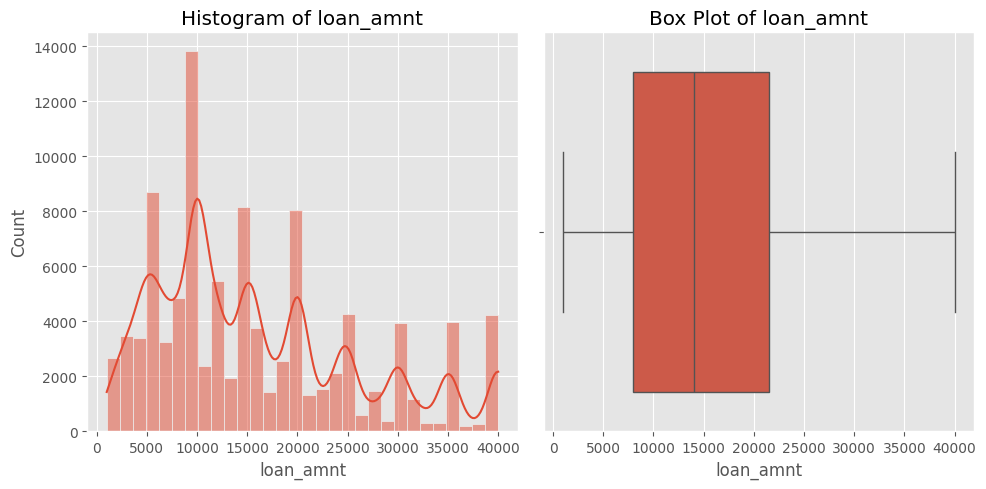

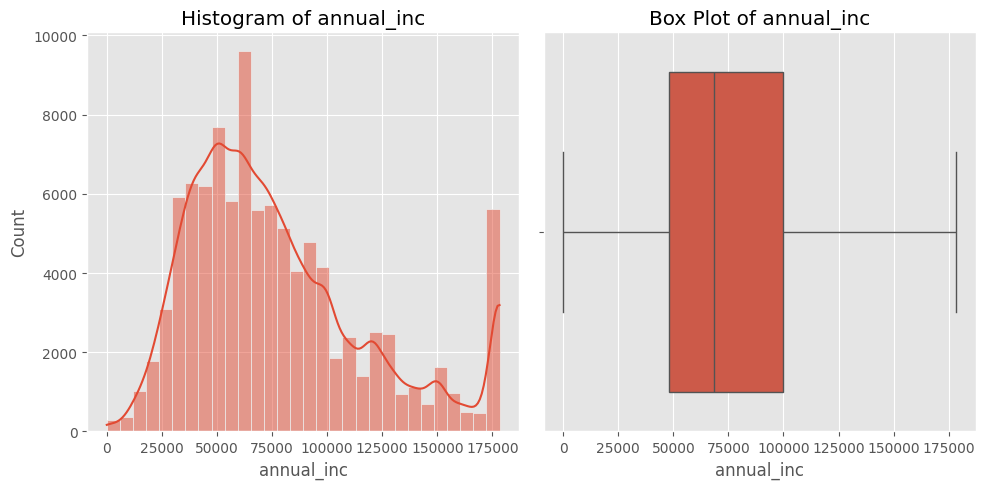

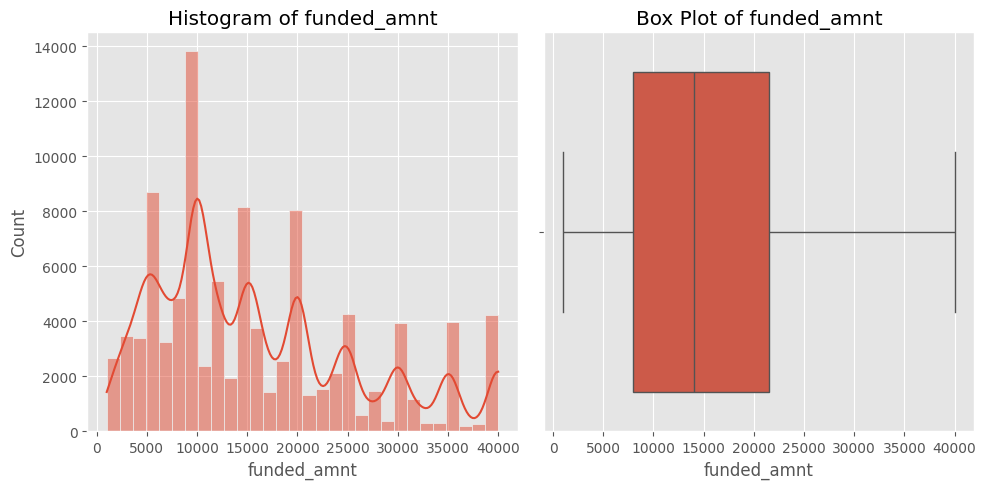

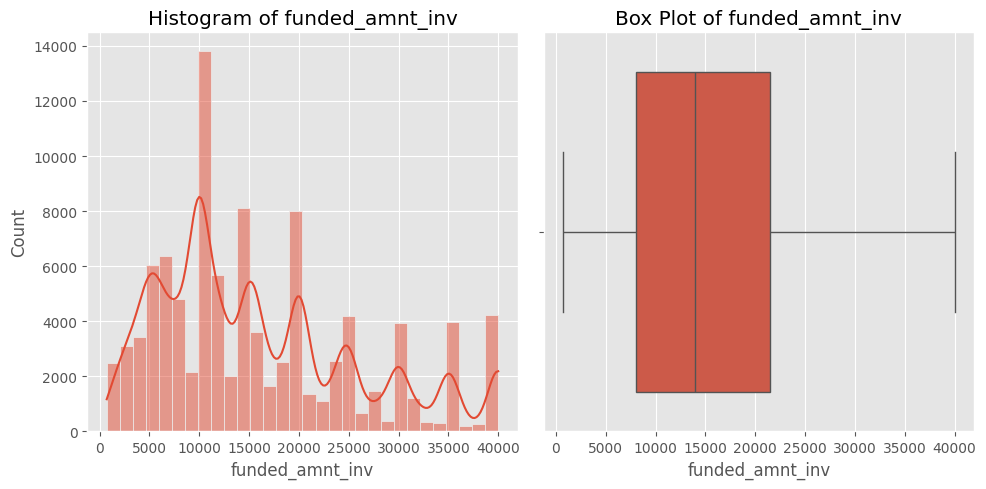

In [30]:
# Histograms and box plots to visualize distributions
def plot_feature_distributions(df, features):
  for feature in features:
    plt.figure(figsize=(10, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f"Histogram of {feature}")

    # Box Plot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[feature])
    plt.title(f"Box Plot of {feature}")

    plt.tight_layout()
    plt.show()

plot_feature_distributions(train_df, features_to_check)

In [31]:
# Display cleaned credit dataset as a dataframe
print("Credit Dataset Information:")
print(tabulate(train_df.head(15), headers='keys', tablefmt='pretty'))

Credit Dataset Information:
+----+----+-----------+-----------+-------------+-----------------+------+----------+-------------+-------+-----------+------------------------+------------+----------------+------------------------+-----------------+------------+---------------------+---------+-------------+------------+--------------------+-------------------------+----------+------------+-------+-------------+------------------+----------------+------------------------+------------------------+----------+---------+-----------+------------+-----------+---------------------+-----------+---------------+-------------+-----------------+-----------------+---------------+--------------------+------------+-------------------------+--------------+-----------------+--------------+--------------------+----------------------------+-----------------------------+-------------+------------------+------------------+-----------+---------------------------+----------------+--------------+-------------+----

#Feature Engineering

In [32]:
# Numeric feature distributions before scaling
features_to_plot = numeric_features

num_features = len(features_to_plot)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 4))
axs = axs.flatten()

# Plot each feature
for i, feature in enumerate(features_to_plot):
  sns.histplot(train_df[feature], kde=True, ax=axs[i])
  axs[i].set_title(f'{feature.replace("_", " ")} Distribution\nBefore Scaling', fontsize=10)
  axs[i].tick_params(labelsize=8)
  axs[i].set_xlabel(feature, fontsize=9)
  axs[i].set_ylabel('Frequency', fontsize=9)

for j in range(i + 1, len(axs)):
  axs[j].set_visible(False)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [33]:
# variance for each feature
variances = train_df.select_dtypes(include=['number']).drop(columns=['id', 'member_id']).var()
print(variances.sort_values().head(20))

policy_code                           0.0
mths_since_recent_bc_dlq              0.0
sec_app_open_act_il                   0.0
num_tl_90g_dpd_24m                    0.0
sec_app_chargeoff_within_12_mths      0.0
sec_app_collections_12_mths_ex_med    0.0
recoveries                            0.0
collection_recovery_fee               0.0
collections_12_mths_ex_med            0.0
num_tl_30dpd                          0.0
sec_app_open_acc                      0.0
annual_inc_joint                      0.0
num_tl_120dpd_2m                      0.0
acc_now_delinq                        0.0
tot_coll_amt                          0.0
delinq_amnt                           0.0
chargeoff_within_12_mths              0.0
tax_liens                             0.0
pub_rec_bankruptcies                  0.0
delinq_2yrs                           0.0
dtype: float64


In [34]:
# Set threshold for variance
variance_threshold = 0.01
selector = VarianceThreshold(threshold=variance_threshold)
selector.fit(train_df.select_dtypes(include=['number']).drop(columns=['id', 'member_id', 'grade']))

# Get low-variance columns
low_variance_columns = train_df.select_dtypes(include=['number']).drop(columns=['id', 'member_id', 'grade']).columns[~selector.get_support()]
train_df = train_df.drop(columns=low_variance_columns)

In [35]:
# Define target column and features to drop
target_col = 'grade'
drop_cols = ['member_id', target_col]
train_cols = [col for col in train_df.columns if col not in drop_cols]

#Feature Selection

In [36]:

# Feature Scaling
scaler = RobustScaler()

numeric_cols = train_df.select_dtypes(include=['number']).columns.drop('id', 'member_id')
numeric_features = [col for col in numeric_cols if col not in ('grade', 'member_id')]

train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])

In [37]:
train_df[numeric_features] = scaler.inverse_transform(train_df[numeric_features])

In [38]:
print("Train Data Distribution:\n", train_df['grade'].value_counts())

Train Data Distribution:
 grade
1    81790
0    18210
Name: count, dtype: int64


In [39]:
# Plot feature distributions after scaling
num_features = len(numeric_features)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols

# Plot feature distributions after scaling
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 4))
axs = axs.flatten()

scaled_features = numeric_features

for i, feature in enumerate(scaled_features):
  sns.histplot(train_df[feature], kde=True, ax=axs[i])
  axs[i].set_title(f'{feature} Distribution After Scaling')

for j in range(len(scaled_features), len(axs)):
  axs[j].set_visible(False)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [40]:
def plot_feature_vs_target(feature, target, data, bins=30):
  fig, axes = plt.subplots(1, 2, figsize=(8, 6))

  # Plot the distribution (density plot)
  sns.kdeplot(data=data, x=feature, hue=target, ax=axes[0], fill=True, alpha=0.4)
  axes[0].set_title(f"Distribution of {feature}")
  axes[0].set_xlabel(feature)
  axes[0].set_ylabel("Density")

  # Plot the boxplot
  sns.boxplot(data=data, x=target, y=feature, ax=axes[1], hue=target, legend=False)
  axes[1].set_title(f"Boxplot of {feature}")
  axes[1].set_xlabel(target)
  axes[1].set_ylabel(feature)

  plt.tight_layout()
  plt.show()

features_to_plot = scaled_features
target_variable = 'grade'

for feature in features_to_plot:
  plot_feature_vs_target(feature, target_variable, train_df)

Output hidden; open in https://colab.research.google.com to view.

In [41]:
# Re-select numerical columns post variance thresholding
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = train_df[numeric_cols].corr()

plt.figure(figsize=(48,30))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# **<span style="color:#F7B2B0;">Weight of Evidence(WOE)</span>**
The weight of evidence tells the predictive power of an independent variable in relation to the dependent variable. Since it evolved from credit scoring world, it is generally described as a measure of the separation of good and bad customers. "Bad Customers" refers to the customers who defaulted on a loan. and "Good Customers" refers to the customers who paid back loan.


- Distribution of Goods - % of Good Customers in a particular group
- Distribution of Bads - % of Bad Customers in a particular group
- ln - Natural Log

**Steps of Calculating WOE**

1. For a continuous variable, split data into 10 parts (or lesser depending on the distribution).
2. Calculate the number of events and non-events in each group (bin)
3. Calculate the % of events and % of non-events in each group.
4. Calculate WOE by taking natural log of division of % of non-events and % of events

# **<span style="color:#F7B2B0;">Information Value(IV)</span>**

Information value is one of the most useful technique to select important variables in a predictive model. It helps to rank variables on the basis of their importance.

If the IV statistic is:
- Less than 0.02, then the predictor is not useful for modeling (separating the Goods from the Bads)
- 0.02 to 0.1, then the predictor has only a weak relationship to the Goods/Bads odds ratio
- 0.1 to 0.3, then the predictor has a medium strength relationship to the Goods/Bads odds ratio
- 0.3 to 0.5, then the predictor has a strong relationship to the Goods/Bads odds ratio.
- 0.5, suspicious relationship (Check once)


In [42]:
# IV Analysis & Optimal binning
iv_score_dict = {}

for col in tqdm(train_cols):
  if col in categorical_cols:
    optb = optbinning.OptimalBinning(dtype='categorical')
    optb.fit(train_df[col], train_df['grade'])
  else:
    try:
      train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
      optb = optbinning.OptimalBinning(dtype='numerical')
      optb.fit(train_df[col], train_df['grade'])
    except ValueError as e:
      print(f"Skipping column '{col}' as it has no valid samples.")
      continue

  # Build the binning table to compute Information Value
  binning_table = optb.binning_table
  binning_table.build()
  iv_score_dict[col] = binning_table.iv

# Convert the IV scores into a DataFrame
iv_score_df = pd.Series(iv_score_dict)
iv_score_df.sort_values(ascending=False, inplace=True)

100%|██████████| 85/85 [00:09<00:00,  9.39it/s]


In [43]:
# top 10 important iv features
iv_score_df.head(20)

emp_title              3.108839
total_rec_int          0.565147
disbursement_method    0.519084
int_rate               0.514437
bc_open_to_buy         0.426730
all_util               0.286359
total_rec_prncp        0.259606
bc_util                0.255098
percent_bc_gt_75       0.249646
total_bc_limit         0.236092
revol_util             0.218312
total_rev_hi_lim       0.210943
title                  0.157737
purpose                0.157737
term                   0.123222
funded_amnt            0.113134
loan_amnt              0.113134
funded_amnt_inv        0.112889
dti                    0.098125
out_prncp              0.097747
dtype: float64

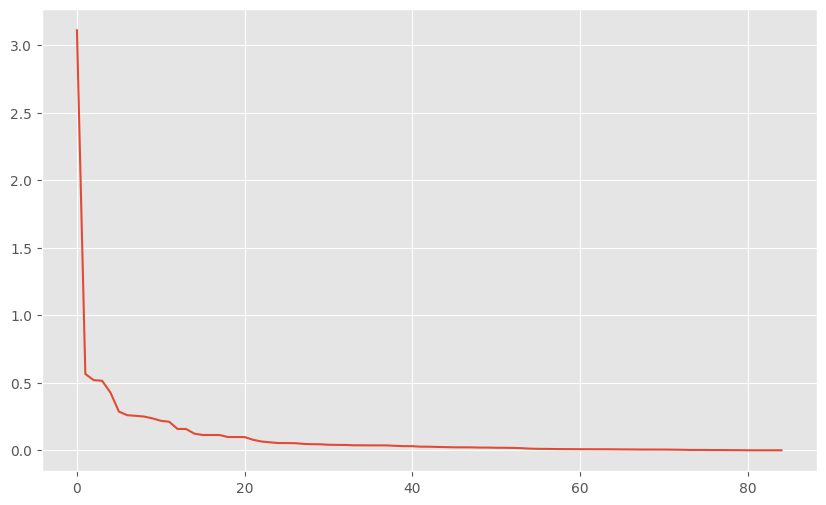

In [44]:
# iv score vs features
fig, ax = plt.subplots(figsize=(10,6))
iv_score_df.reset_index(drop=True).plot()
plt.show()

- This shows the predictive power of an independent variable in relation to the dependent variable.


In [45]:
# WOE for a selected feature
col = 'int_rate'
optb = optbinning.OptimalBinning(dtype='numerical')
optb.fit(train_df[col], train_df['grade'])
binning_table = optb.binning_table
display(binning_table.build())

Bin   Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 6.57)    6347    0.06347          2   6345    0.999685   
1        [6.57, inf)   93653    0.93653      18208  75445    0.805580   
2            Special       0    0.00000          0      0    0.000000   
3            Missing       0    0.00000          0      0    0.000000   
Totals                100000    1.00000      18210  81790    0.817900   

             WoE        IV        JS  
0      -6.560091  0.508190  0.026509  
1       0.080641  0.006247  0.000781  
2            0.0  0.000000  0.000000  
3            0.0  0.000000  0.000000  
Totals            0.514437  0.027290

- `int_rate` is a continuous feature, os we splited into 15 bins
- each bin have non-event and event counts and rates
- each bin have WOE and IV values
- for missing values it's created 16th bin

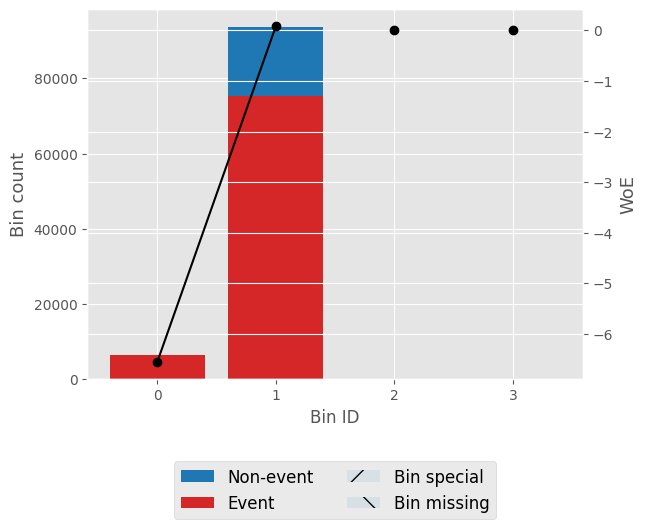

None

In [46]:
display(binning_table.plot(metric="woe"))

----------------------------------------------------------------------------------------------------
Feature Name :  emp_title





Bin   Count  Count (%)  \
0       [Business Intelligence Engineer, Risk manager ...    6057    0.06057   
1       [Resident, Area Manager , Union Carpenter , Ul...    6108    0.06108   
2       [Medical assistant, Maintenance Supervisor, St...    9451    0.09451   
3       [Lineman, Production , Merchandiser, Librarian...    5447    0.05447   
4       [Customer Service Manager, Rn, Maintenance, Ph...   23091    0.23091   
5       [Warehouse Manager, Teacher , Analyst, RN, Reg...    5010    0.05010   
6       [Claims Adjuster, Mechanical Engineer, Sales A...    8147    0.08147   
7       [Regional Sales Manager, Office manager, COO, ...   36689    0.36689   
8                                                 Special       0    0.00000   
9                                                 Missing       0    0.00000   
Totals                                                     100000    1.00000   

        Non-event  Event  Event rate       WoE        IV            JS  
0            5875    182    0.030048  4.976639  1.594514  1.059310e-01  
1            2465   3643    0.596431  1.111568  0.100957  1.200764e-02  
2            2308   7143    0.755793  0.372433  0.014678  1.824172e-03  
3            1089   4358    0.800073  0.115431  0.000753  9.401675e-05  
4            4195  18896    0.818327 -0.002873  0.000002  2.379987e-07  
5             843   4167    0.831737 -0.095801  0.000446  5.571431e-05  
6            1121   7026    0.862403 -0.333212  0.008112  1.009273e-03  
7             314  36375    0.991442  -3.25006  1.389379  1.233025e-01  
8               0      0    0.000000       0.0  0.000000  0.000000e+00  
9               0      0    0.000000       0.0  0.000000  0.000000e+00  
Totals      18210  81790    0.817900            3.108839  2.442246e-01

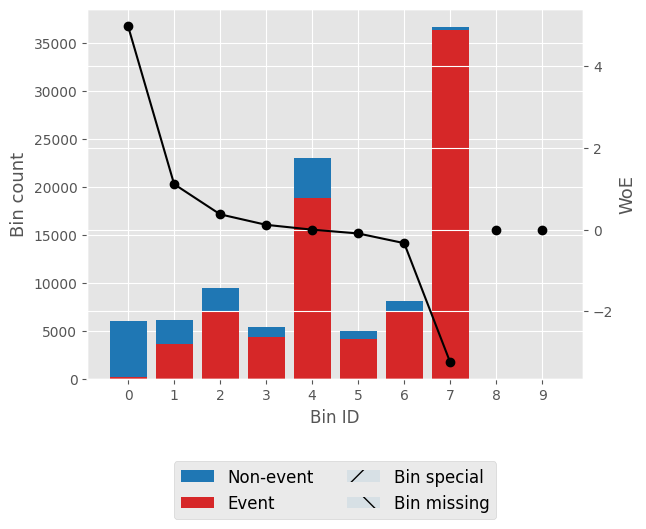

None

----------------------------------------------------------------------------------------------------
Feature Name :  total_rec_int





Bin   Count  Count (%)  Non-event  Event  Event rate  \
0          (-inf, 209.86)   31976    0.31976       3018  28958    0.905617   
1        [209.86, 271.30)    9723    0.09723        919   8804    0.905482   
2        [271.30, 419.58)   18626    0.18626       2520  16106    0.864705   
3        [419.58, 569.64)   12886    0.12886       2525  10361    0.804051   
4        [569.64, 662.96)    5906    0.05906       1367   4539    0.768540   
5        [662.96, 832.21)    7667    0.07667       1934   5733    0.747750   
6       [832.21, 1185.58)    8194    0.08194       3077   5117    0.624481   
7          [1185.58, inf)    5022    0.05022       2850   2172    0.432497   
8                 Special       0    0.00000          0      0    0.000000   
9                 Missing       0    0.00000          0      0    0.000000   
Totals                     100000    1.00000      18210  81790    0.817900   

             WoE        IV        JS  
0      -0.759068  0.142948  0.017451  
1      -0.757491  0.043309  0.005288  
2      -0.352749  0.020648  0.002568  
3       0.090376  0.001083  0.000135  
4       0.302096  0.005913  0.000736  
5       0.415536  0.015006  0.001862  
6       0.993571  0.105726  0.012698  
7       1.773855  0.230515  0.025546  
8            0.0  0.000000  0.000000  
9            0.0  0.000000  0.000000  
Totals            0.565147  0.066285

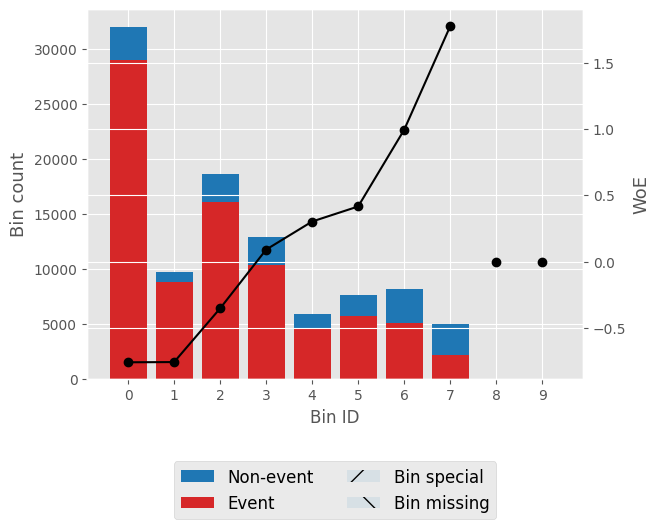

None

----------------------------------------------------------------------------------------------------
Feature Name :  disbursement_method





Bin   Count  Count (%)  Non-event  Event  Event rate  \
0            [Cash]   80367    0.80367      17754  62613    0.779088   
1       [DirectPay]   19633    0.19633        456  19177    0.976774   
2           Special       0    0.00000          0      0    0.000000   
3           Missing       0    0.00000          0      0    0.000000   
Totals               100000    1.00000      18210  81790    0.817900   

             WoE        IV        JS  
0       0.241822  0.050644  0.006315  
1       -2.23679  0.468440  0.048766  
2            0.0  0.000000  0.000000  
3            0.0  0.000000  0.000000  
Totals            0.519084  0.055081

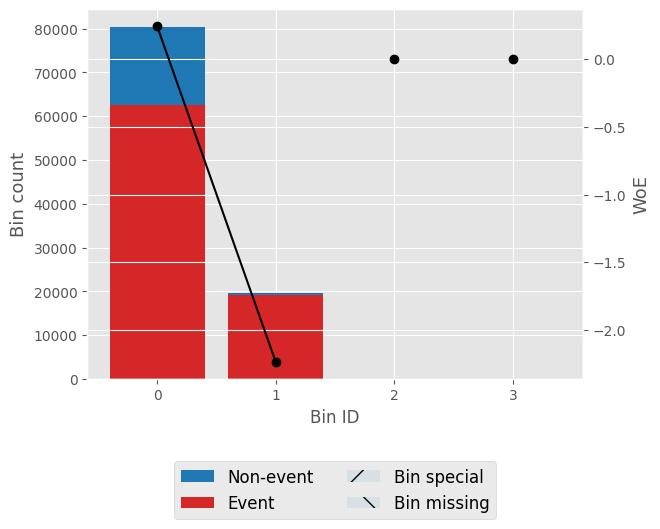

None

----------------------------------------------------------------------------------------------------
Feature Name :  int_rate





Bin   Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 6.57)    6347    0.06347          2   6345    0.999685   
1        [6.57, inf)   93653    0.93653      18208  75445    0.805580   
2            Special       0    0.00000          0      0    0.000000   
3            Missing       0    0.00000          0      0    0.000000   
Totals                100000    1.00000      18210  81790    0.817900   

             WoE        IV        JS  
0      -6.560091  0.508190  0.026509  
1       0.080641  0.006247  0.000781  
2            0.0  0.000000  0.000000  
3            0.0  0.000000  0.000000  
Totals            0.514437  0.027290

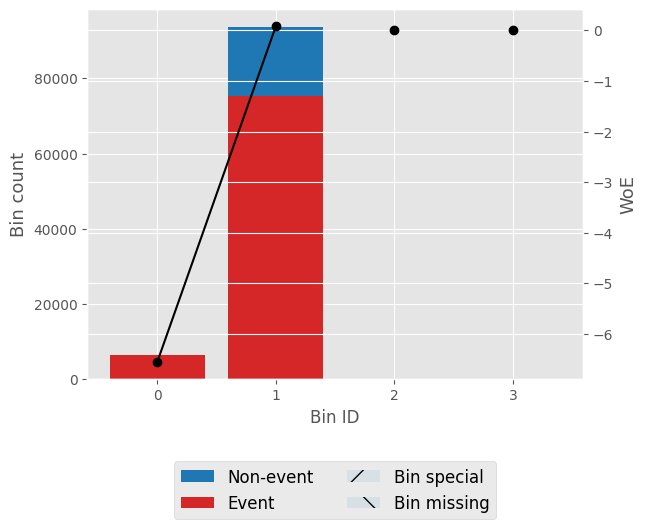

None

----------------------------------------------------------------------------------------------------
Feature Name :  bc_open_to_buy





Bin   Count  Count (%)  Non-event  Event  Event rate  \
0             (-inf, 329.50)    5144    0.05144       2053   3091    0.600894   
1           [329.50, 853.50)    5031    0.05031       1653   3378    0.671437   
2          [853.50, 2129.50)    9296    0.09296       2560   6736    0.724613   
3         [2129.50, 2998.50)    5336    0.05336       1341   3995    0.748688   
4         [2998.50, 4313.50)    7305    0.07305       1688   5617    0.768925   
5         [4313.50, 5504.50)    5605    0.05605       1197   4408    0.786441   
6         [5504.50, 8516.50)   12952    0.12952       2611  10341    0.798410   
7        [8516.50, 11799.50)    9413    0.09413       1512   7901    0.839371   
8       [11799.50, 16200.50)    9229    0.09229       1188   8041    0.871275   
9       [16200.50, 22712.50)    9289    0.09289       1008   8281    0.891485   
10      [22712.50, 27799.50)    5085    0.05085        448   4637    0.911898   
11      [27799.50, 38497.50)    6861    0.06861        523   6338    0.923772   
12           [38497.50, inf)    9454    0.09454        428   9026    0.954728   
13                   Special       0    0.00000          0      0    0.000000   
14                   Missing       0    0.00000          0      0    0.000000   
Totals                        100000    1.00000      18210  81790    0.817900   

             WoE        IV        JS  
0       1.092992  0.081918  0.009759  
1       0.787492  0.038960  0.004748  
2       0.534725  0.031134  0.003846  
3       0.410556  0.010180  0.001264  
4       0.299931  0.007204  0.000897  
5       0.198581  0.002351  0.000293  
6       0.125801  0.002132  0.000266  
7      -0.151372  0.002054  0.000257  
8      -0.410098  0.013564  0.001684  
9      -0.603811  0.027711  0.003412  
10     -0.834846  0.026792  0.003255  
11     -0.992553  0.048407  0.005814  
12     -1.546557  0.134322  0.015295  
13           0.0  0.000000  0.000000  
14           0.0  0.000000  0.000000  
Totals            0.426730  0.050789

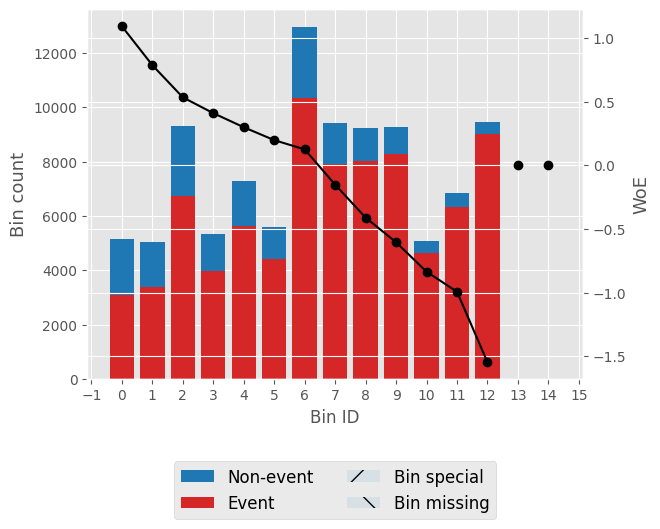

None

----------------------------------------------------------------------------------------------------
Feature Name :  all_util





Bin   Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, 27.50)   10394    0.10394        757   9637    0.927170   
1       [27.50, 34.50)    6956    0.06956        611   6345    0.912162   
2       [34.50, 39.50)    6319    0.06319        657   5662    0.896028   
3       [39.50, 43.50)    5875    0.05875        671   5204    0.885787   
4       [43.50, 48.50)    8385    0.08385       1180   7205    0.859273   
5       [48.50, 53.50)    8935    0.08935       1407   7528    0.842529   
6       [53.50, 56.50)    5667    0.05667        971   4696    0.828657   
7       [56.50, 59.50)    5763    0.05763       1049   4714    0.817977   
8       [59.50, 64.50)    9377    0.09377       1995   7382    0.787245   
9       [64.50, 70.50)   10027    0.10027       2346   7681    0.766032   
10      [70.50, 76.50)    8237    0.08237       2221   6016    0.730363   
11      [76.50, 82.50)    5898    0.05898       1711   4187    0.709902   
12        [82.50, inf)    8167    0.08167       2634   5533    0.677483   
13             Special       0    0.00000          0      0    0.000000   
14             Missing       0    0.00000          0      0    0.000000   
Totals                  100000    1.00000      18210  81790    0.817900   

             WoE            IV            JS  
0      -1.041818  7.944441e-02  9.504489e-03  
1      -0.838141  3.689811e-02  4.481832e-03  
2      -0.651664  2.160071e-02  2.653304e-03  
3       -0.54623  1.462720e-02  1.806003e-03  
4      -0.307077  7.152398e-03  8.905535e-04  
5      -0.174986  2.585473e-03  3.227724e-04  
6      -0.073956  3.026997e-04  3.782885e-05  
7      -0.000515  1.530510e-08  1.913137e-09  
8       0.193784  3.739956e-03  4.667644e-04  
9       0.316146  1.103953e-02  1.374223e-03  
10      0.505719  2.448273e-02  3.028141e-03  
11      0.607278  2.597161e-02  3.197469e-03  
12      0.759958  5.851441e-02  7.143220e-03  
13           0.0  0.000000e+00  0.000000e+00  
14           0.0  0.000000e+00  0.000000e+00  
Totals            2.863593e-01  3.490660e-02

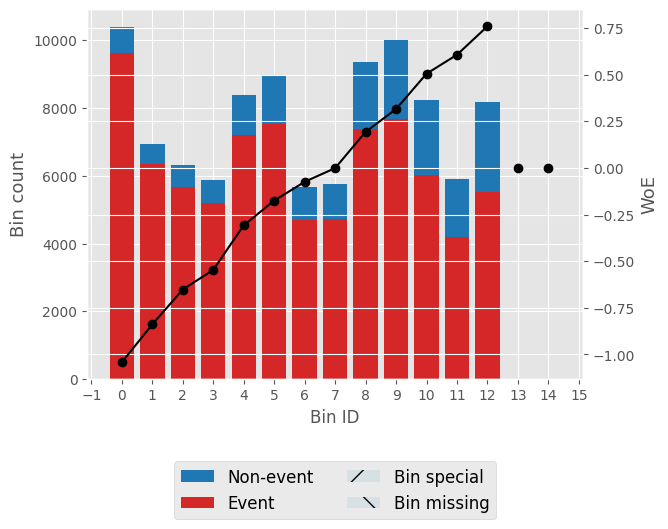

None

----------------------------------------------------------------------------------------------------
Feature Name :  total_rec_prncp





Bin   Count  Count (%)  Non-event  Event  Event rate  \
0          (-inf, 213.90)    6942    0.06942       2705   4237    0.610343   
1        [213.90, 343.32)   11719    0.11719       3010   8709    0.743152   
2        [343.32, 426.85)    8826    0.08826       2176   6650    0.753456   
3        [426.85, 649.91)   20615    0.20615       4041  16574    0.803978   
4        [649.91, 866.47)   15632    0.15632       2167  13465    0.861374   
5        [866.47, 987.14)    5956    0.05956        781   5175    0.868872   
6       [987.14, 1300.04)   10590    0.10590       1382   9208    0.869500   
7          [1300.04, inf)   19720    0.19720       1948  17772    0.901217   
8                 Special       0    0.00000          0      0    0.000000   
9                 Missing       0    0.00000          0      0    0.000000   
Totals                     100000    1.00000      18210  81790    0.817900   

             WoE        IV        JS  
0       1.053431  0.101910  0.012181  
1       0.439767  0.025864  0.003207  
2       0.385056  0.014705  0.001827  
3       0.090841  0.001751  0.000219  
4      -0.324566  0.014809  0.001843  
5      -0.388835  0.007926  0.000985  
6      -0.394357  0.014468  0.001797  
7      -0.708637  0.078173  0.009572  
8            0.0  0.000000  0.000000  
9            0.0  0.000000  0.000000  
Totals            0.259606  0.031630

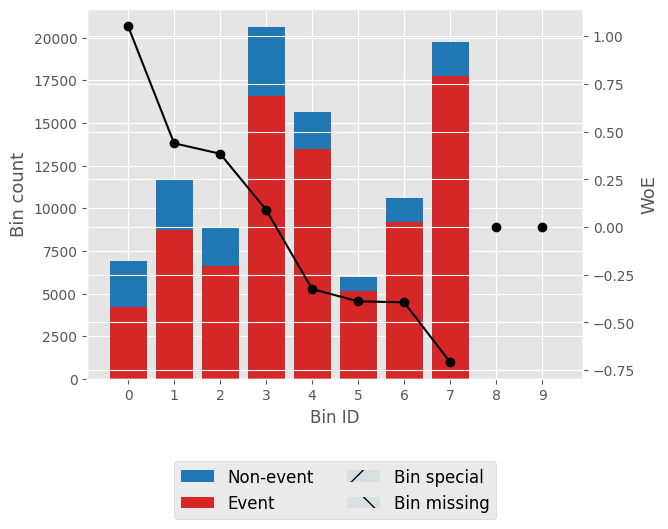

None

----------------------------------------------------------------------------------------------------
Feature Name :  bc_util





Bin   Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, 22.45)   20461    0.20461       2006  18455    0.901960   
1       [22.45, 30.85)    8871    0.08871       1022   7849    0.884793   
2       [30.85, 39.15)    9250    0.09250       1220   8030    0.868108   
3       [39.15, 47.75)    9429    0.09429       1382   8047    0.853431   
4       [47.75, 56.25)   10232    0.10232       1915   8317    0.812842   
5       [56.25, 61.65)    5333    0.05333       1001   4332    0.812301   
6       [61.65, 67.55)    5566    0.05566       1146   4420    0.794107   
7       [67.55, 73.35)    5164    0.05164       1082   4082    0.790473   
8       [73.35, 80.25)    6013    0.06013       1423   4590    0.763346   
9       [80.25, 86.75)    5548    0.05548       1397   4151    0.748198   
10      [86.75, 94.35)    6961    0.06961       2014   4947    0.710674   
11        [94.35, inf)    7172    0.07172       2602   4570    0.637200   
12             Special       0    0.00000          0      0    0.000000   
13             Missing       0    0.00000          0      0    0.000000   
Totals                  100000    1.00000      18210  81790    0.817900   

             WoE        IV        JS  
0      -0.717009  0.082800  0.010134  
1      -0.536441  0.021373  0.002640  
2       -0.38215  0.011916  0.001481  
3      -0.259584  0.005839  0.000728  
4         0.0336  0.000117  0.000015  
5       0.037154  0.000074  0.000009  
6       0.152322  0.001354  0.000169  
7       0.174408  0.001659  0.000207  
8       0.331071  0.007292  0.000907  
9       0.413162  0.010727  0.001331  
10      0.603526  0.030245  0.003724  
11      0.938951  0.081702  0.009853  
12           0.0  0.000000  0.000000  
13           0.0  0.000000  0.000000  
Totals            0.255098  0.031199

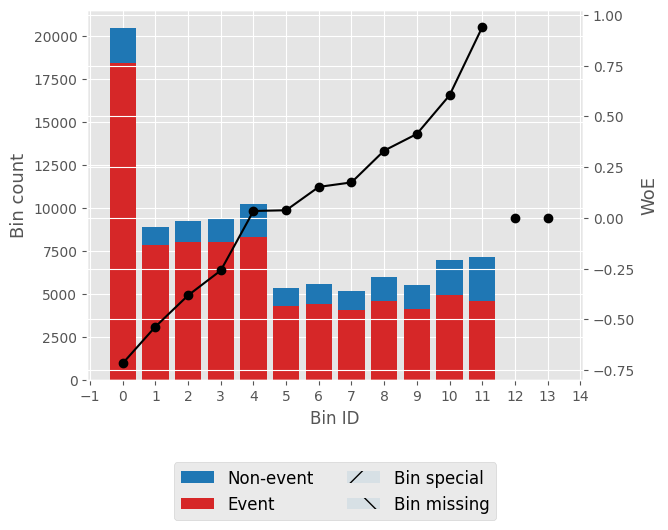

None

----------------------------------------------------------------------------------------------------
Feature Name :  percent_bc_gt_75





Bin   Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, 10.15)   38900    0.38900       4272  34628    0.890180   
1       [10.15, 18.05)    5517    0.05517        702   4815    0.872757   
2       [18.05, 30.20)   11262    0.11262       2000   9262    0.822412   
3       [30.20, 41.45)    9188    0.09188       1735   7453    0.811167   
4       [41.45, 62.00)   12418    0.12418       2702   9716    0.782413   
5       [62.00, 72.05)    5358    0.05358       1333   4025    0.751213   
6       [72.05, 89.45)    5135    0.05135       1504   3631    0.707108   
7         [89.45, inf)   12222    0.12222       3962   8260    0.675830   
8              Special       0    0.00000          0      0    0.000000   
9              Missing       0    0.00000          0      0    0.000000   
Totals                  100000    1.00000      18210  81790    0.817900   

             WoE        IV        JS  
0      -0.590396  0.111455  0.013733  
1      -0.423374  0.008603  0.001067  
2      -0.030589  0.000104  0.000013  
3       0.044575  0.000185  0.000023  
4       0.222402  0.006580  0.000821  
5       0.397091  0.009526  0.001183  
6       0.620804  0.023713  0.002917  
7       0.767508  0.089478  0.010918  
8            0.0  0.000000  0.000000  
9            0.0  0.000000  0.000000  
Totals            0.249646  0.030676

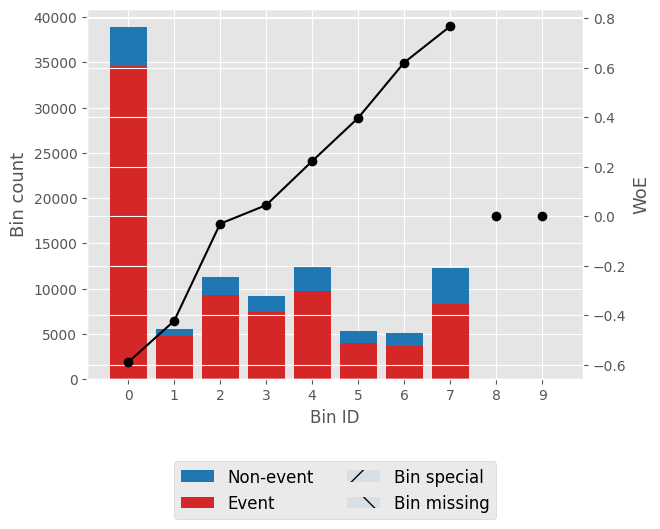

None

----------------------------------------------------------------------------------------------------
Feature Name :  total_bc_limit





Bin   Count  Count (%)  Non-event  Event  Event rate  \
0            (-inf, 2925.00)    5369    0.05369       1846   3523    0.656174   
1         [2925.00, 6625.00)    9713    0.09713       2765   6948    0.715330   
2         [6625.00, 9375.00)    7727    0.07727       1927   5800    0.750615   
3        [9375.00, 13475.00)   11761    0.11761       2554   9207    0.782842   
4       [13475.00, 18402.50)   12579    0.12579       2398  10181    0.809365   
5       [18402.50, 21680.00)    6852    0.06852       1188   5664    0.826620   
6       [21680.00, 25155.00)    6450    0.06450       1052   5398    0.836899   
7       [25155.00, 28925.00)    5902    0.05902        871   5031    0.852423   
8       [28925.00, 36475.00)    9105    0.09105       1230   7875    0.864909   
9       [36475.00, 42825.00)    5765    0.05765        683   5082    0.881526   
10      [42825.00, 50850.00)    5131    0.05131        574   4557    0.888131   
11      [50850.00, 70950.00)    7197    0.07197        668   6529    0.907184   
12           [70950.00, inf)    6449    0.06449        454   5995    0.929601   
13                   Special       0    0.00000          0      0    0.000000   
14                   Missing       0    0.00000          0      0    0.000000   
Totals                        100000    1.00000      18210  81790    0.817900   

             WoE        IV        JS  
0       0.855892  0.049898  0.006054  
1       0.580771  0.038848  0.004789  
2       0.400291  0.013973  0.001735  
3       0.219881  0.006087  0.000759  
4       0.056296  0.000406  0.000051  
5      -0.059675  0.000239  0.000030  
6      -0.133151  0.001096  0.000137  
7      -0.251548  0.003441  0.000429  
8      -0.354495  0.010187  0.001267  
9      -0.504781  0.012432  0.001538  
10     -0.569606  0.013781  0.001700  
11     -0.777537  0.033545  0.004091  
12       -1.0784  0.052158  0.006221  
13           0.0  0.000000  0.000000  
14           0.0  0.000000  0.000000  
Totals            0.236092  0.028799

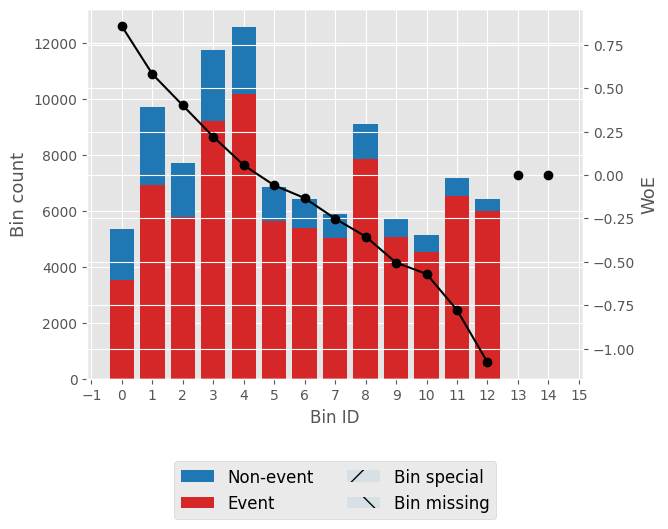

None

In [47]:
# WOE plots for top 10 features
top10_features = iv_score_df[:10].index.values

for col in top10_features:
  print("-"*100)
  print("="*100)
  print("Feature Name : ", col)
  print("\n\n")

  if col in categorical_cols:
    optb = optbinning.OptimalBinning(dtype='categorical')
    optb.fit(train_df[col], train_df['grade'])
  else:
    optb = optbinning.OptimalBinning(dtype='numerical')
    optb.fit(train_df[col], train_df['grade'])

  binning_table = optb.binning_table
  display(binning_table.build())
  display(binning_table.plot(metric="woe"))

- Select features with IV values between >= 0.02 & <= 0.5

In [48]:
selected_features = iv_score_df[(iv_score_df >= 0.02) & (iv_score_df <= 0.5)].index.values
cat_cols = [col for col in categorical_cols if col in selected_features]
train_cols = [col for col in train_df.columns if col in selected_features]

#Correlation Heatmap

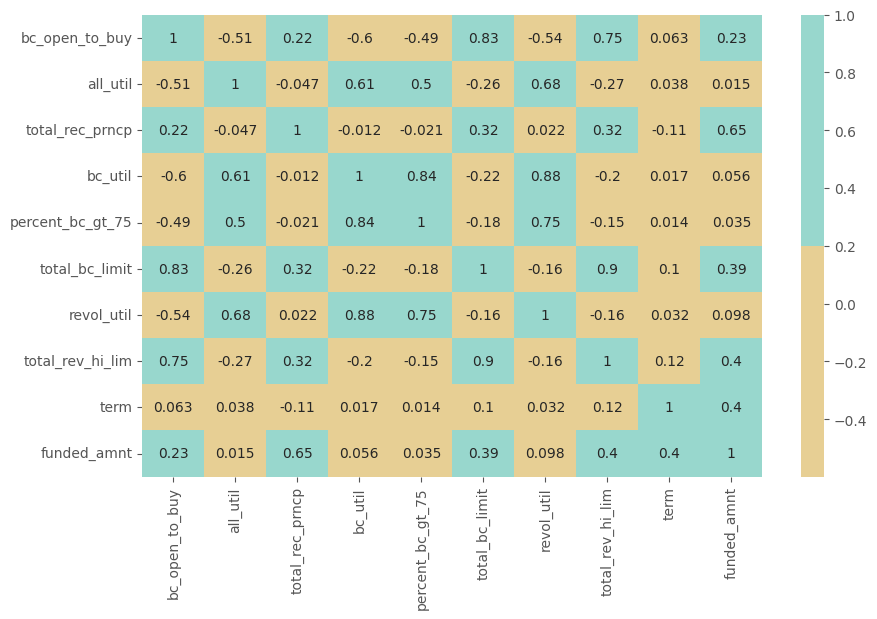

In [49]:
# numeric columns for correlation heatmap calculation
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
top_cols = [col for col in selected_features if col in numeric_cols]

if not top_cols:
  print("No numeric features selected for correlation analysis.")
else:
  top_cols = top_cols[:10]
  corr_df = train_df[top_cols].corr()
  plt.figure(figsize=(10, 6))
  sns.heatmap(corr_df, annot=True, cmap=sns.color_palette("BrBG", 2));
  plt.show()

In [50]:
def drop_feature_selection(row, col, corr, row_iv, col_iv):
  if row_iv >= col_iv:
    return col
  else:
    return row

In [51]:
# Filter out only numeric columns from train_cols
numeric_train_cols = train_df[train_cols].select_dtypes(include=['float64', 'int64']).columns
cor_matrix = train_df[numeric_train_cols].corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool_))
corr_df = upper_tri.stack().reset_index()
corr_df.columns = ['row', 'col', 'corr']
corr_df = corr_df.drop_duplicates()
corr_df = corr_df.sort_values('corr', ascending=False)

# drop out highly correlated features
corr_df = corr_df.query("corr >= 0.8")
corr_df['row_iv'] = corr_df['row'].map(iv_score_dict)
corr_df['col_iv'] = corr_df['col'].map(iv_score_dict)
corr_df['drop_feature'] = corr_df.apply(lambda x: drop_feature_selection(x['row'], x['col'], x['corr'], x['row_iv'], x['col_iv']), axis=1)

In [52]:
corr_df

row               col      corr    row_iv    col_iv  \
0           loan_amnt       funded_amnt  1.000000  0.113134  0.113134   
306         out_prncp     out_prncp_inv  0.999997  0.097747  0.097735   
1           loan_amnt   funded_amnt_inv  0.999997  0.113134  0.112889   
38        funded_amnt   funded_amnt_inv  0.999997  0.113134  0.112889   
363       total_pymnt   total_pymnt_inv  0.999987  0.053671  0.053281   
82    funded_amnt_inv     out_prncp_inv  0.959707  0.112889  0.097735   
46        funded_amnt     out_prncp_inv  0.959702  0.113134  0.097735   
9           loan_amnt     out_prncp_inv  0.959702  0.113134  0.097735   
8           loan_amnt         out_prncp  0.959684  0.113134  0.097747   
45        funded_amnt         out_prncp  0.959684  0.113134  0.097747   
81    funded_amnt_inv         out_prncp  0.959684  0.112889  0.097747   
76    funded_amnt_inv       installment  0.942769  0.112889  0.064881   
40        funded_amnt       installment  0.942765  0.113134  0.064881   
3           loan_amnt       installment  0.942765  0.113134  0.064881   
364       total_pymnt   total_rec_prncp  0.939278  0.053671  0.259606   
390   total_pymnt_inv   total_rec_prncp  0.939180  0.053281  0.259606   
604  total_rev_hi_lim    total_bc_limit  0.900392  0.210943  0.236092   
151       installment     out_prncp_inv  0.895492  0.064881  0.097735   
150       installment         out_prncp  0.895471  0.064881  0.097747   
293        revol_util           bc_util  0.884656  0.218312  0.255098   
155       installment   last_pymnt_amnt  0.883846  0.064881  0.058839   
365       total_pymnt   last_pymnt_amnt  0.877850  0.053671  0.058839   
391   total_pymnt_inv   last_pymnt_amnt  0.877821  0.053281  0.058839   
672           bc_util  percent_bc_gt_75  0.840090  0.255098  0.249646   
720         num_bc_tl     num_rev_accts  0.833102  0.036854  0.020061   
662    bc_open_to_buy    total_bc_limit  0.832450  0.426730  0.236092   
50        funded_amnt   last_pymnt_amnt  0.830498  0.113134  0.058839   
13          loan_amnt   last_pymnt_amnt  0.830498  0.113134  0.058839   
86    funded_amnt_inv   last_pymnt_amnt  0.830492  0.112889  0.058839   
416   total_rec_prncp   last_pymnt_amnt  0.825028  0.259606  0.058839   
713       num_bc_sats         num_bc_tl  0.807733  0.024648  0.036854   

         drop_feature  
0         funded_amnt  
306     out_prncp_inv  
1     funded_amnt_inv  
38    funded_amnt_inv  
363   total_pymnt_inv  
82      out_prncp_inv  
46      out_prncp_inv  
9       out_prncp_inv  
8           out_prncp  
45          out_prncp  
81          out_prncp  
76        installment  
40        installment  
3         installment  
364       total_pymnt  
390   total_pymnt_inv  
604  total_rev_hi_lim  
151       installment  
150       installment  
293        revol_util  
155   last_pymnt_amnt  
365       total_pymnt  
391   total_pymnt_inv  
672  percent_bc_gt_75  
720     num_rev_accts  
662    total_bc_limit  
50    last_pymnt_amnt  
13    last_pymnt_amnt  
86    last_pymnt_amnt  
416   last_pymnt_amnt  
713       num_bc_sats

In [53]:
corr_drop_features = corr_df['drop_feature'].unique().tolist()

In [54]:
member_id_backup = train_df['member_id'].copy()
train_df['member_id'] = member_id_backup

#Data Modelling

In [55]:
# Data Splitting
train_data, valid_data = train_test_split(train_df[selected_features.tolist() + ['grade', 'member_id']], test_size=0.3, random_state=42, stratify=train_df['grade'])

In [56]:
# Check distribution after splitting
print("Train data distrubution", train_data[target_col].value_counts())
print("Validation data distribution", valid_data[target_col].value_counts())

Train data distrubution grade
1    57253
0    12747
Name: count, dtype: int64
Validation data distribution grade
1    24537
0     5463
Name: count, dtype: int64


In [57]:
# Map A, B, C to 1 (good), and D, E to 0 (bad)
def convert_to_binary_class(value):
  if value in [1, 2, 3]:
    return 1
  elif value in [4, 5]:
    return 0

In [58]:
train_data['target_binary'] = train_data[target_col].apply(lambda x: 1 if x == 1 else 0)
valid_data['target_binary'] = valid_data[target_col].apply(lambda x: 1 if x == 1 else 0)

In [59]:
print(train_data['target_binary'].value_counts())
print(valid_data['target_binary'].value_counts())

target_binary
1    57253
0    12747
Name: count, dtype: int64
target_binary
1    24537
0     5463
Name: count, dtype: int64


- There is a class imbalance which would lead to model overfitting

In [60]:
# Prepare feature and target variables
X_train = train_data[selected_features.tolist() + ['grade', 'member_id']].copy()
y_train_binary = train_data['grade'].copy()

X_valid = valid_data[selected_features.tolist() + ['grade', 'member_id']].copy()
y_valid_binary = valid_data['grade'].copy()

In [61]:
# Define high- and low-cardinality categorical features
high_cardinality_threshold = 10
high_cardinality_cols = [col for col in cat_cols if train_data[col].nunique() > high_cardinality_threshold]
low_cardinality_cols = [col for col in cat_cols if col not in high_cardinality_cols]

# Target Encode High-Cardinality Columns
target_encoder = TargetEncoder(cols=high_cardinality_cols)
train_data[high_cardinality_cols] = target_encoder.fit_transform(train_data[high_cardinality_cols], train_data['grade'])
X_train[high_cardinality_cols] = target_encoder.transform(X_train[high_cardinality_cols])
X_valid[high_cardinality_cols] = target_encoder.transform(X_valid[high_cardinality_cols])

In [62]:
X_train["member_id"] = train_data["member_id"].values
X_valid["member_id"] = valid_data["member_id"].values

# ColumnTransformer with OneHot Encoding for Low-Cardinality Categorical Columns
preprocessor = ColumnTransformer(
  transformers=[
    ('num', 'passthrough', [col for col in selected_features if col not in cat_cols and col != "member_id"]),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), low_cardinality_cols)
  ]
)

In [63]:
# preprocessor to training and validation data
X_train_encoded = preprocessor.fit_transform(X_train)
X_valid_encoded = preprocessor.transform(X_valid)

# Extract feature names and map back to original names
encoded_feature_names = preprocessor.get_feature_names_out()
cleaned_feature_names = [name.split("__")[-1] if "__" in name else name for name in encoded_feature_names]

# Convert back to DataFrames for easier handling
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=cleaned_feature_names)
X_valid_encoded_df = pd.DataFrame(X_valid_encoded, columns=cleaned_feature_names)

X_train_encoded_df["member_id"] = X_train["member_id"].values
X_valid_encoded_df["member_id"] = X_valid["member_id"].values

In [64]:
# Separate majority and minority classes (for undersampling)
df_majority = train_data[train_data['target_binary'] == 1]
df_minority = train_data[train_data['target_binary'] == 0]

# Undersample the majority class
df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)

# Combine the downsampled majority class with the minority class
train_data_balanced = pd.concat([df_majority_downsampled, df_minority])

X_train_balanced = train_data_balanced[selected_features].copy()
X_train_balanced["member_id"] = train_data_balanced["member_id"].values
y_train_balanced = train_data_balanced['target_binary'].copy()

# preprocessor to the balanced training data excluding `member_id`
X_train_balanced_encoded = preprocessor.transform(X_train_balanced.drop(columns=["member_id"]))
X_train_balanced_encoded_df = pd.DataFrame(X_train_balanced_encoded, columns=cleaned_feature_names)

In [65]:
X_train_balanced_encoded_df["member_id"] = X_train_balanced["member_id"].values

# Balanced class distiition after undersampling
print("Balanced class distribution:\n", y_train_balanced.value_counts())

Balanced class distribution:
 target_binary
1    12747
0    12747
Name: count, dtype: int64


In [66]:
# Estimator initialization
estimator = LogisticGAM(n_splines=10, lam=1)

In [67]:
variable_names = list(X_train_balanced_encoded_df.columns)

In [68]:
categorical_variables = [col for col in X_train_balanced_encoded_df.columns if any(cat in col for cat in cat_cols)]

In [69]:
binning_process = BinningProcess(
  variable_names=variable_names,
  categorical_variables=categorical_variables,
  max_n_bins=10,
  n_jobs=-1
)

scorecard = Scorecard(
  binning_process=binning_process,
  estimator=estimator,
  scaling_method="min_max",
  scaling_method_params={"min": 300, "max": 850}
)

In [70]:
# Fit the scorecard model
scorecard.fit(X_train_balanced_encoded_df, y_train_balanced)

Scorecard(binning_process=BinningProcess(categorical_variables=['term_36.0',
                                                                'term_60.0',
                                                                'verification_status_Not '
                                                                'Verified',
                                                                'verification_status_Source '
                                                                'Verified',
                                                                'verification_status_Verified',
                                                                'verification_status_joint_Not '
                                                                'Verified',
                                                                'verification_status_joint_Source '
                                                                'Verified',
                                                                'verification_status_joint_Verified'],
                                         max_n_bins=10, n_jobs=-1,
                                         variabl...
                                                         'il_util',
                                                         'open_il_24m',
                                                         'inq_fi',
                                                         'open_il_12m',
                                                         'num_bc_tl',
                                                         'mo_sin_old_rev_tl_op',
                                                         'inq_last_12m',
                                                         'inq_last_6mths',
                                                         'mort_acc', ...]),
          estimator=LogisticGAM(callbacks=['deviance', 'diffs', 'accuracy'], 
   fit_intercept=True, lam=1, max_iter=100, n_splines=10, 
   terms='auto', tol=0.0001, verbose=False),
          scaling_method='min_max',
          scaling_method_params={'max': 850, 'min': 300})

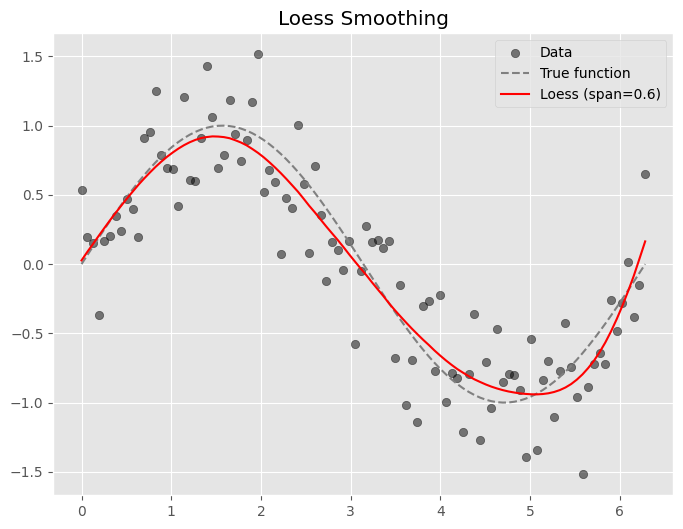

In [71]:
np.random.seed(3)
x = np.linspace(0, 2 * np.pi, 100)
y_true = np.sin(x)
y = y_true + np.random.normal(scale=0.3, size=x.shape)

# Loess function using polynomial regression
def loess(x, y, span=0.6):
  smoothed_y = []
  for i in range(len(x)):
    distances = np.abs(x - x[i])
    weights = (1 - (distances / distances.max()) ** 3) ** 3
    local_idx = weights > (1 - span)
    x_local, y_local, w_local = x[local_idx], y[local_idx], weights[local_idx]

    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(x_local[:, None])
    model = LinearGAM(n_splines=10, lam=1)
    model.fit(X_poly, y_local)

    smoothed_y.append(model.predict(poly.transform([[x[i]]]))[0])
  return np.array(smoothed_y)

# Plotting Loess
y_loess = loess(x, y, span=0.6)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='black', alpha=0.5, label='Data')
plt.plot(x, y_true, '--', color='gray', label='True function')
plt.plot(x, y_loess, color='red', label='Loess (span=0.6)')
plt.legend()
plt.title('Loess Smoothing')
plt.show()

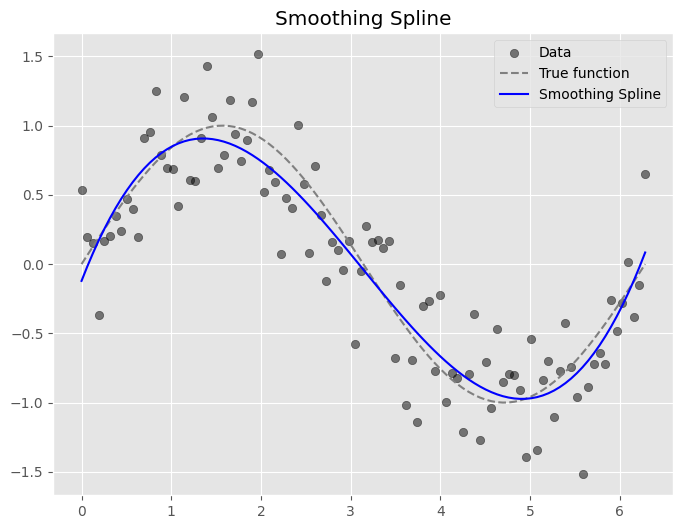

In [72]:
# Smoothing spline with lambda as a smoothness control
spline = UnivariateSpline(x, y, s=10)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='black', alpha=0.5, label='Data')
plt.plot(x, y_true, '--', color='gray', label='True function')
plt.plot(x, spline(x), color='blue', label='Smoothing Spline')
plt.legend()
plt.title('Smoothing Spline')
plt.show()

In [73]:
# Scorecard table
scorecard_df = scorecard.table(style="detailed")

In [74]:
scorecard_df.head(10)

Variable  Bin id                   Bin  Count  Count (%)  Non-event  \
0  bc_open_to_buy       0        (-inf, 328.50)   1890   0.074135       1417   
1  bc_open_to_buy       1      [328.50, 912.50)   1809   0.070958       1254   
2  bc_open_to_buy       2     [912.50, 1703.50)   1862   0.073037       1191   
3  bc_open_to_buy       3    [1703.50, 3880.50)   3771   0.147917       2270   
4  bc_open_to_buy       4    [3880.50, 8554.00)   5644   0.221385       3081   
5  bc_open_to_buy       5   [8554.00, 11832.00)   2346   0.092022       1065   
6  bc_open_to_buy       6  [11832.00, 15213.00)   1671   0.065545        654   
7  bc_open_to_buy       7  [15213.00, 24556.00)   2835   0.111203        983   
8  bc_open_to_buy       8  [24556.00, 39016.50)   2045   0.080215        556   
9  bc_open_to_buy       9       [39016.50, inf)   1621   0.063584        276   

   Event  Event rate       WoE        IV        JS  Coefficient     Points  
0    473    0.250265  1.097202  0.081255  0.009676     1.064039  -6.499548  
1    555    0.306799  0.815126  0.044699  0.005438     1.064039  -1.601790  
2    671    0.360365  0.573779  0.023407  0.002886     1.064039   2.588762  
3   1501    0.398038  0.413648  0.024955  0.003097     1.064039   5.369158  
4   2563    0.454111  0.184076  0.007480  0.000934     1.064039   9.355281  
5   1281    0.546036 -0.184666  0.003129  0.000391     1.064039  15.757837  
6   1017    0.608618 -0.441505  0.012573  0.001559     1.064039  20.217392  
7   1852    0.653263 -0.633412  0.043182  0.005309     1.064039  23.549524  
8   1489    0.728117 -0.985092  0.072103  0.008665     1.064039  29.655819  
9   1345    0.829735 -1.583748  0.132818  0.015059     1.064039  40.050440

In [75]:
# Wrapper function for predictions (predict probabilities)
def predict_proba_wrapper(data):
  if isinstance(data, np.ndarray):
    # Convert to DataFrame with suitable column names
    data = pd.DataFrame(data, columns=X_train_balanced_encoded_df.columns)
  return scorecard.predict_proba(data)

#Metircs Calculation

In [76]:
# Customer Evaluation metric
def metric(y_true, y_pred, return_components=False) -> float:
  def top_percent_captured(df, percentile=90) -> float:
    # Assign weight based on the target, higher weight for negative instances
    df['weight'] = df['target'].apply(lambda x: 60 if x == 0 else 1)
    # Calculate the cutoff point for the top 30% of the weight
    cutoff = int((percentile / 100) * df['weight'].sum())
    # Calculate cumulative sum of weights
    df['weight_cumsum'] = df['weight'].cumsum()
    # Find the cutoff in the DataFrame
    df_cutoff = df[df['weight_cumsum'] <= cutoff]
    # Calculate recall: true positives in top 30% / total true positives
    return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()

  def weighted_gini(df):
    # Assign weights similarly as in top_four_percent_captured
    df['weight'] = df['target'].apply(lambda x: 20 if x == 0 else 1)
    # Calculate cumulative sum of normalized weights.
    df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
    # Calculate the cumulative positive rate weighted by the target
    total_pos = (df['target'] * df['weight']).sum()
    df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
    df['lorentz'] = df['cum_pos_found'] / total_pos
    # Calculate the Gini coefficient using the Lorentz curve and the random curve
    df['gini'] = (df['lorentz'] - df['random']) * df['weight']
    return df['gini'].sum()

  def normalized_weighted_gini(df):
    df2 = pd.DataFrame({'target': df.target, 'prediction': df.target})
    df2.sort_values('prediction', ascending=False, inplace=True)
    # Normalize the actual Gini by the Gini of a perfect model
    return weighted_gini(df) / weighted_gini(df2)

  # Prepare data frame from predictions and targets
  target_data = y_true.to_numpy() if hasattr(y_true, 'to_numpy') else y_true
  prediction_data = y_pred.to_numpy() if hasattr(y_pred, 'to_numpy') else y_pred

  df = pd.DataFrame({'target': target_data, 'prediction': prediction_data})
  df.sort_values('prediction', ascending=False, inplace=True)

  # Calculate metrics
  g = normalized_weighted_gini(df)
  d = top_percent_captured(df, percentile=90)

  return 0.5 * (g + d)

In [77]:
y_train_pred_balanced = scorecard.predict_proba(X_train_balanced_encoded_df)
y_valid_pred = scorecard.predict_proba(X_valid_encoded_df)

# Evaluate the model
train_score_balanced = metric(y_train_balanced.to_numpy(), y_train_pred_balanced)
valid_score = metric(y_valid_binary.to_numpy(), y_valid_pred)

print(f"Train Score: {train_score_balanced:.4f}")
print(f"Validation Score: {valid_score:.4f}")

Train Score: 0.8927
Validation Score: 0.8812


In [78]:
# Performance Metrics
metrics = {
  "Metric": ["AUC-ROC", "Gini Coefficient", "Precision-Recall AUC"],
  "Training Set": [],
  "Validation Set": []
}

# AUC-ROC
train_auc_roc = roc_auc_score(y_train_balanced, y_train_pred_balanced)
valid_auc_roc = roc_auc_score(y_valid_binary, y_valid_pred)
metrics["Training Set"].append(round(train_auc_roc, 4))
metrics["Validation Set"].append(round(valid_auc_roc, 4))

# Gini Coefficient
train_gini = metric(y_train_balanced, y_train_pred_balanced)
valid_gini = metric(y_valid_binary, y_valid_pred)
metrics["Training Set"].append(round(train_gini, 4))
metrics["Validation Set"].append(round(valid_gini, 4))

# Precision-Recall AUC
precision_train, recall_train, _ = precision_recall_curve(y_train_balanced, y_train_pred_balanced)
precision_valid, recall_valid, _ = precision_recall_curve(y_valid_binary, y_valid_pred)
train_pr_auc = auc(recall_train, precision_train)
valid_pr_auc = auc(recall_valid, precision_valid)
metrics["Training Set"].append(round(train_pr_auc, 4))
metrics["Validation Set"].append(round(valid_pr_auc, 4))

metrics_df = pd.DataFrame(metrics)

table = PrettyTable()
table.field_names = ["Metric", "Training Set", "Validation Set"]

for index, row in metrics_df.iterrows():
  table.add_row([row["Metric"], row["Training Set"], row["Validation Set"]])

print("Generalization Performance for GAM:")
print(table)

Generalization Performance for GAM:
+----------------------+--------------+----------------+
|        Metric        | Training Set | Validation Set |
+----------------------+--------------+----------------+
|       AUC-ROC        |    0.8935    |     0.8823     |
|   Gini Coefficient   |    0.8927    |     0.8812     |
| Precision-Recall AUC |    0.8975    |     0.9691     |
+----------------------+--------------+----------------+


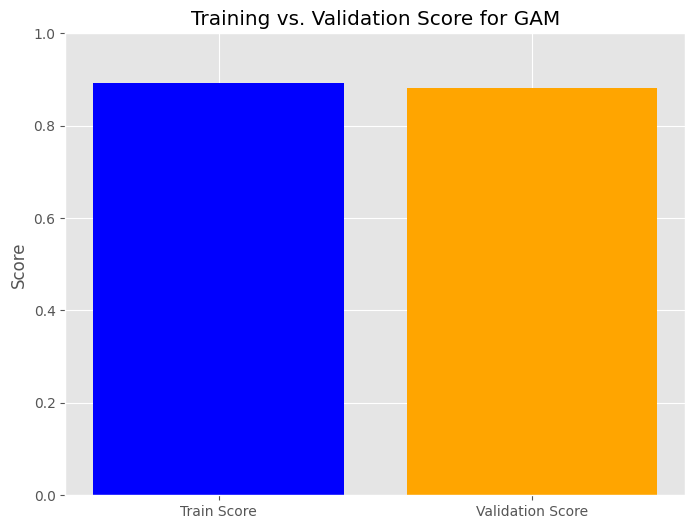

In [79]:
# bar plot to compare the train and validation scores
scores = [train_score_balanced, valid_score]
labels = ['Train Score', 'Validation Score']

plt.figure(figsize=(8, 6))
plt.bar(labels, scores, color=['blue', 'orange'])
plt.title('Training vs. Validation Score for GAM')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

#ROC/AUC Graph

In [80]:
from sklearn import metrics

In [81]:
train_data_balanced['predict_proba'] = y_train_pred_balanced
valid_data['predict_proba'] = y_valid_pred

# Calculate ROC curve and AUC for the undersampled (balanced) training set
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(train_data_balanced['target_binary'], train_data_balanced['predict_proba'])
optimal_idx_train = np.argmax(tpr_train - fpr_train)
optimal_threshold_train = thresholds_train[optimal_idx_train]
auc_score_train = metrics.auc(fpr_train, tpr_train)
print("Optimal Threshold for Train Set:", optimal_threshold_train)

# Calculate ROC curve and AUC for the validation set
fpr_valid, tpr_valid, thresholds_valid = metrics.roc_curve(y_valid_binary, valid_data['predict_proba'])
optimal_idx_valid = np.argmax(tpr_valid - fpr_valid)
optimal_threshold_valid = thresholds_valid[optimal_idx_valid]
auc_score_valid = metrics.auc(fpr_valid, tpr_valid)
print("Optimal Threshold for Validation Set:", optimal_threshold_valid)
print(f"AUC Score (Train): {auc_score_train:.4f}")
print(f"AUC Score (Validation): {auc_score_valid:.4f}")

Optimal Threshold for Train Set: 0.4973081954645998
Optimal Threshold for Validation Set: 0.518877603900269
AUC Score (Train): 0.8935
AUC Score (Validation): 0.8823


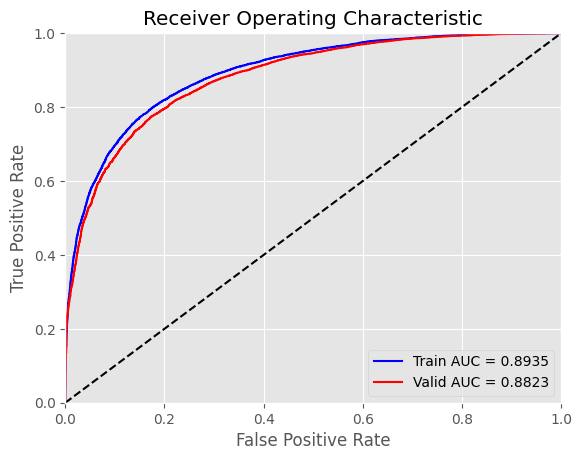

In [82]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'b', label=f'Train AUC = {auc_score_train:.4f}')
plt.plot(fpr_valid, tpr_valid, 'r', label=f'Valid AUC = {auc_score_valid:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

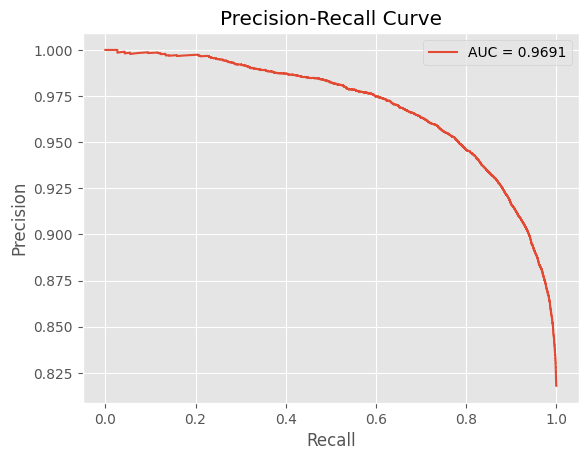

In [83]:
precision, recall, thresholds = precision_recall_curve(y_valid_binary, y_valid_pred)
plt.plot(recall, precision, label=f'AUC = {auc(recall, precision):.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

Brier Score for Validation Data: 0.1410


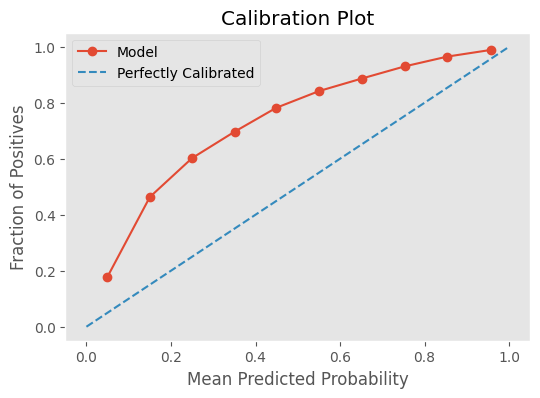

In [84]:
# Compute Brier score for validation predictions
brier_score = brier_score_loss(y_valid_binary, y_valid_pred)
print(f"Brier Score for Validation Data: {brier_score:.4f}")

prob_true, prob_pred = calibration_curve(y_valid_binary, y_valid_pred, n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(6, 4))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend()
plt.grid()
plt.show()

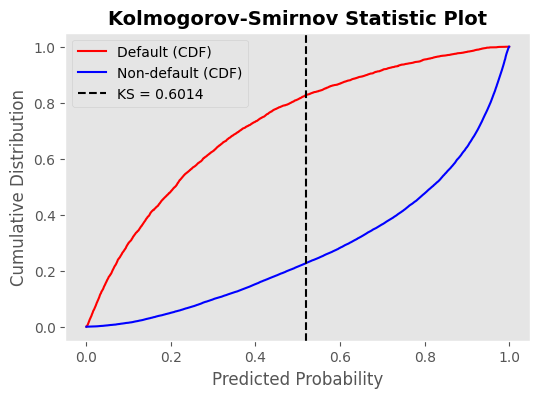


Kolmogorov-Smirnov (KS) Statistic: 0.6014
Threshold at KS: 0.5188


In [85]:
# Combine predicted probabilities and true labels
ks_data = pd.DataFrame({
  'y_true': y_valid_binary,
  'y_prob': y_valid_pred
})

ks_data = ks_data.sort_values(by='y_prob')

# Compute cumulative distributions
ks_data['cum_default'] = (ks_data['y_true'] == 0).cumsum() / (ks_data['y_true'] == 0).sum()
ks_data['cum_non_default'] = (ks_data['y_true'] == 1).cumsum() / (ks_data['y_true'] == 1).sum()

# Calculate KS statistic and its location
ks_data['ks_diff'] = np.abs(ks_data['cum_default'] - ks_data['cum_non_default'])
ks_statistic = ks_data['ks_diff'].max()
ks_index = ks_data['ks_diff'].idxmax()

# Get the corresponding threshold value
ks_threshold = ks_data.loc[ks_index, 'y_prob']

plt.figure(figsize=(6, 4))
plt.plot(ks_data['y_prob'], ks_data['cum_default'], label='Default (CDF)', color='red')
plt.plot(ks_data['y_prob'], ks_data['cum_non_default'], label='Non-default (CDF)', color='blue')
plt.axvline(x=ks_threshold, color='black', linestyle='--', label=f"KS = {ks_statistic:.4f}")

plt.title("Kolmogorov-Smirnov Statistic Plot", fontweight="bold", fontsize=14)
plt.xlabel("Predicted Probability")
plt.ylabel("Cumulative Distribution")
plt.legend()
plt.grid()
plt.show()

print("")
print(f"Kolmogorov-Smirnov (KS) Statistic: {ks_statistic:.4f}")
print(f"Threshold at KS: {ks_threshold:.4f}")

#Classification Report

In [86]:
# Ensure the predictions are being applied to the correct DataFrame (train_data_balanced)
train_data_balanced['predict'] = (y_train_pred_balanced > optimal_threshold_train).astype(int)
valid_data['predict'] = (y_valid_pred > optimal_threshold_train).astype(int)

# Check if there are any NaN values in predictions
if not train_data_balanced['predict'].isnull().any() and not valid_data['predict'].isnull().any():
  print("Classification Report - Training Data:")
  print(metrics.classification_report(train_data_balanced['target_binary'], train_data_balanced['predict'], labels=[0, 1]))
  print("")
  print("Classification Report - Validation Data:")
  print(metrics.classification_report(valid_data['target_binary'], valid_data['predict'], labels=[0, 1]))
else:
  print("Error: NaN values found in binary predictions.")

Classification Report - Training Data:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81     12747
           1       0.82      0.80      0.81     12747

    accuracy                           0.81     25494
   macro avg       0.81      0.81      0.81     25494
weighted avg       0.81      0.81      0.81     25494


Classification Report - Validation Data:
              precision    recall  f1-score   support

           0       0.46      0.81      0.59      5463
           1       0.95      0.79      0.86     24537

    accuracy                           0.79     30000
   macro avg       0.70      0.80      0.72     30000
weighted avg       0.86      0.79      0.81     30000



#Confussion Matrix

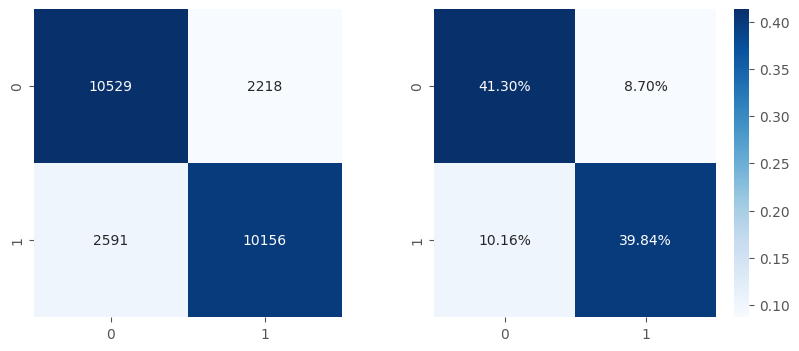

In [87]:
conf_mat = metrics.confusion_matrix(train_data_balanced['target_binary'], train_data_balanced['predict'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax1)
sns.heatmap(conf_mat / np.sum(conf_mat), annot=True, fmt='.2%', cmap='Blues', ax=ax2)
plt.show()

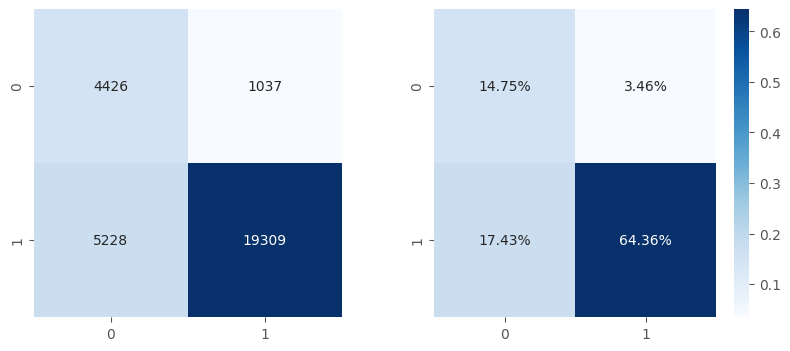

In [88]:
conf_mat = metrics.confusion_matrix(valid_data['target_binary'], valid_data['predict'])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax1)
sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, fmt='.2%', cmap='Blues', ax=ax2)
plt.show()

#Scores

In [89]:
# separate DataFrame for adjusted data
train_data_balanced = pd.DataFrame(X_train_balanced_encoded_df, columns=variable_names)
train_data_balanced['target_binary'] = y_train_balanced

In [90]:
# Assign scores to the balanced training data
train_data_balanced['score'] = scorecard.score(X_train_balanced_encoded_df)

In [91]:
# assign scores to the training and validation data
train_data['score'] = scorecard.score(X_train_encoded_df)
valid_data['score'] = scorecard.score(X_valid_encoded_df)

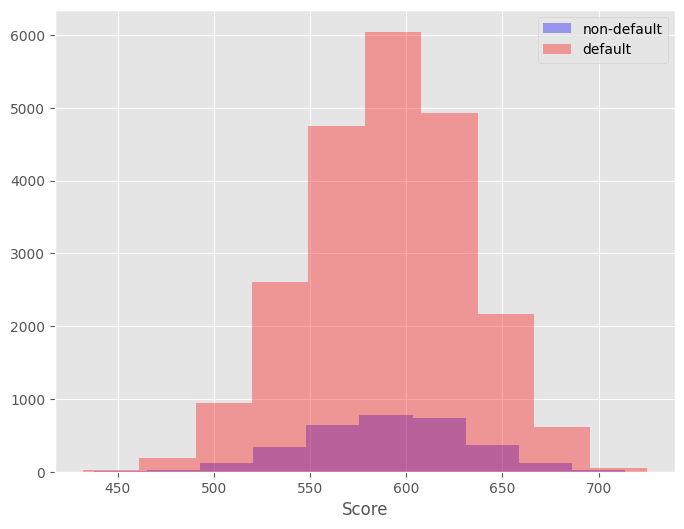

In [92]:
# Extract target and score
y_test = train_data_balanced['target_binary']
score = train_data_balanced['score']

# Create mask for non-default class (target_binary == 0)
mask = y_test == 0

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(score[mask], label="non-default", color="b", alpha=0.35)
plt.hist(score[~mask], label="default", color="r", alpha=0.35)
plt.xlabel("Score")
plt.legend()
plt.show()

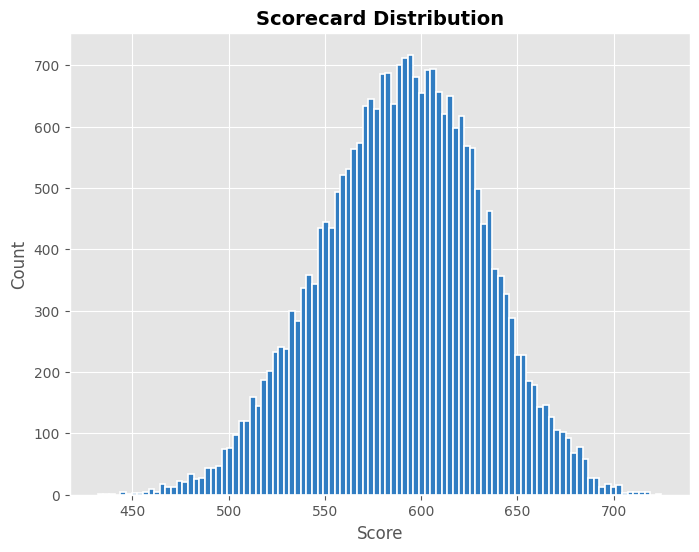

In [93]:
# Plot Distribution of Scores
plt.figure(figsize=(8, 6))

plt.hist(score,
        bins=100,
        edgecolor='white',
        color = '#317DC2',
        linewidth=1.2)

plt.title('Scorecard Distribution', fontweight="bold", fontsize=14)
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

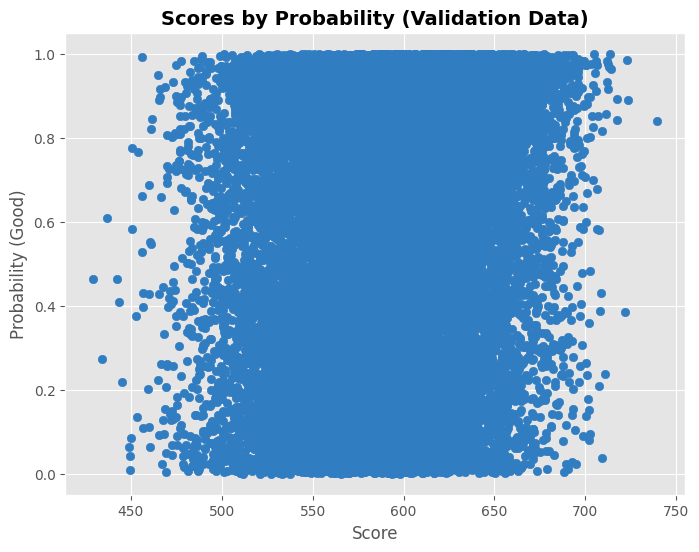

In [94]:
# Plot Scores Against Probabilities for the Validation Data
plt.figure(figsize=(8, 6))

plt.scatter(x=valid_data['score'],
            y=valid_data['predict_proba'],
            color='#317DC2')

plt.title('Scores by Probability (Validation Data)', fontweight="bold", fontsize=14)
plt.xlabel('Score')
plt.ylabel('Probability (Good)')
plt.show()

# Model Benchmarking

Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Neural Network...
Training GAM...


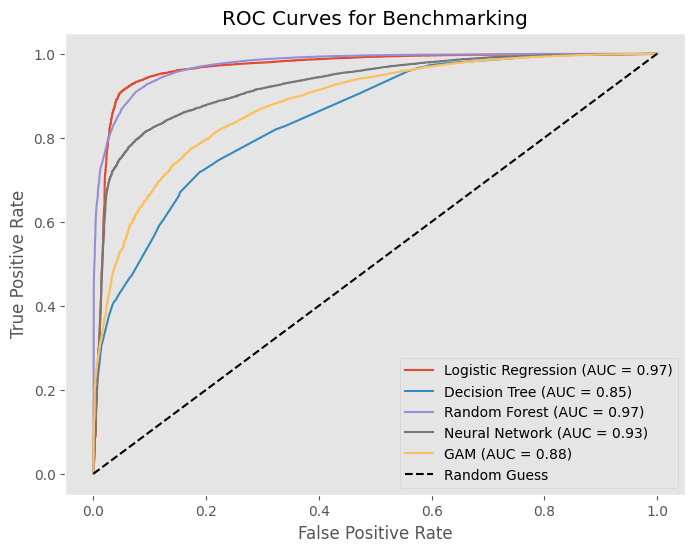

In [95]:
# Benchmark models
models = {
  "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
  "Decision Tree": DecisionTreeClassifier(max_depth=6, random_state=42),
  "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
  "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
  "GAM": scorecard
}

# Results container
evaluation_results = {
  "Model": [],
  "AUC-ROC": [],
  "KS Statistic": [],
  "Precision-Recall AUC": [],
  "Gini Coefficient": [],
  "Brier Score": []
}


plt.figure(figsize=(8, 6))
plt.title("ROC Curves for Benchmarking")

# Train and evaluate each model
for model_name, model in models.items():
  print(f"Training {model_name}...")
  if model_name != "GAM":
    model.fit(X_train_balanced_encoded, y_train_balanced)

  if model_name == "GAM":
    y_valid_pred = scorecard.predict_proba(X_valid_encoded_df)
  else:
    y_valid_pred = model.predict_proba(X_valid_encoded)[:, 1]

  # AUC-ROC
  auc_roc = roc_auc_score(y_valid_binary, y_valid_pred)
  evaluation_results["AUC-ROC"].append(auc_roc)

  # KS Statistic
  ks_stat = ks_2samp(y_valid_binary, y_valid_pred)
  evaluation_results["KS Statistic"].append(ks_stat)

  # Precision-Recall AUC
  precision, recall, _ = precision_recall_curve(y_valid_binary, y_valid_pred)
  pr_auc = auc(recall, precision)
  evaluation_results["Precision-Recall AUC"].append(pr_auc)

  # Gini Coefficient
  gini_coeff = (2 * auc_roc) - 1
  evaluation_results["Gini Coefficient"].append(gini_coeff)

  # Brier Score
  brier = brier_score_loss(y_valid_binary, y_valid_pred)
  evaluation_results["Brier Score"].append(brier)

  # Plot ROC curve
  fpr, tpr, _ = roc_curve(y_valid_binary, y_valid_pred)
  plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_roc:.2f})")

  evaluation_results["Model"].append(model_name)


# ROC plot
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

In [96]:
evaluation_df = pd.DataFrame(evaluation_results)
print("\nBenchmakred Evaluation Results:")
print(tabulate(evaluation_df, headers='keys', tablefmt='psql'))


Benchmakred Evaluation Results:
+----+---------------------+-----------+-------------------------------------------------------------------------------------------------------------------+------------------------+--------------------+---------------+
|    | Model               |   AUC-ROC | KS Statistic                                                                                                      |   Precision-Recall AUC |   Gini Coefficient |   Brier Score |
|----+---------------------+-----------+-------------------------------------------------------------------------------------------------------------------+------------------------+--------------------+---------------|
|  0 | Logistic Regression |  0.967677 | KstestResult(statistic=0.8179, pvalue=0.0, statistic_location=0.9999999999875442, statistic_sign=-1)              |               0.989355 |           0.935355 |     0.0673754 |
|  1 | Decision Tree       |  0.84751  | KstestResult(statistic=0.8060999999999999, pvalue=

In [97]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# for Logistic Regression
log_reg = LogisticRegression(max_iter=2000, random_state=42)
scores = cross_val_score(log_reg, X_train_balanced_encoded_df, y_train_balanced, cv=cv, scoring="roc_auc")
print(f"Logistic Regression AUC-ROC: {scores.mean():.4f} ± {scores.std():.4f}")

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
log_reg = LogisticRegression(max_iter=2000, random_state=42)
grid_search = GridSearchCV(log_reg, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train_balanced_encoded_df, y_train_balanced)
print(f"Best C: {grid_search.best_params_}")
print(f"Best AUC-ROC: {grid_search.best_score_:.4f}")

Logistic Regression AUC-ROC: 0.9668 ± 0.0018
Best C: {'C': 0.01}
Best AUC-ROC: 0.9670


# Feature Contribution Benchmarking (FCB)

In [98]:
# Install dependencies
!pip uninstall llama-cpp-python -y
!CMAKE_ARGS="-DGGML_CUDA=on -DCMAKE_CUDA_COMPILER=/usr/local/cuda-12.5/bin/nvcc" FORCE_CMAKE=1 pip install llama-cpp-python --force-reinstall --upgrade --no-cache-dir --verbose
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub

Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 262.7 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-x7jw1szp
  Entered build tracker: /tmp/pip-build-tracker-x7jw1szp
  Created temporary directory: /tmp/pip-install-ah95smvs
  Created temporary directory: /tmp/pip-ephem-wheel-cache-nrl3vbfk
  1 location(s) to search for versions of scikit-build-core:
  * https://pypi.org/simple/scikit-build-core/
  Fetching project page and analyzing links: https://pypi.org/simple/scikit-build-core/
  Getting page https://pypi.org/simple/scikit-build-core/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/scikit-build-core/" in the cache
  Request header has "max_age" as 0, cache bypass

In [99]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import os
import pandas as pd
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from tqdm import tqdm

In [100]:
# Define model configuration (GGUF format)
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGUF"
model_basename = "llama-2-13b-chat.Q5_K_M.gguf"

# Download the model
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename, force_download=True)
full_model_path = os.path.realpath(model_path)

llama-2-13b-chat.Q5_K_M.gguf:   0%|          | 0.00/9.23G [00:00<?, ?B/s]

In [101]:
# Load model
lcpp_llm = Llama(
  model_path=full_model_path,
  n_gpu_layers=20,
  n_batch=512,
  n_threads=4,
  n_ctx=4096,
)

print("Model loaded successfully!")

ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    no
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 1 CUDA devices:
  Device 0: NVIDIA L4, compute capability 8.9, VMM: yes
llama_model_load_from_file_impl: using device CUDA0 (NVIDIA L4) - 22503 MiB free
llama_model_loader: loaded meta data with 19 key-value pairs and 363 tensors from /root/.cache/huggingface/hub/models--TheBloke--Llama-2-13B-chat-GGUF/blobs/ef36e090240040f97325758c1ad8e23f3801466a8eece3a9eac2d22d942f548a (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 5120
llama_mo

Model loaded successfully!


CUDA : ARCHS = 890 | USE_GRAPHS = 1 | PEER_MAX_BATCH_SIZE = 128 | CPU : SSE3 = 1 | SSSE3 = 1 | AVX = 1 | AVX2 = 1 | F16C = 1 | FMA = 1 | BMI2 = 1 | AVX512 = 1 | AVX512_VNNI = 1 | LLAMAFILE = 1 | OPENMP = 1 | AARCH64_REPACK = 1 | 
Model metadata: {'tokenizer.ggml.unknown_token_id': '0', 'tokenizer.ggml.eos_token_id': '2', 'general.architecture': 'llama', 'llama.context_length': '4096', 'general.name': 'LLaMA v2', 'llama.embedding_length': '5120', 'llama.feed_forward_length': '13824', 'llama.attention.layer_norm_rms_epsilon': '0.000010', 'llama.rope.dimension_count': '128', 'llama.attention.head_count': '40', 'tokenizer.ggml.bos_token_id': '1', 'llama.block_count': '40', 'llama.attention.head_count_kv': '40', 'general.quantization_version': '2', 'tokenizer.ggml.model': 'llama', 'general.file_type': '17'}
Using fallback chat format: llama-2


In [102]:
# Wrapper function for predictions
def predict_proba_wrapper(data):
  if isinstance(data, np.ndarray):
    data = pd.DataFrame(data, columns=X_train_balanced_encoded_df.columns)
  return scorecard.predict_proba(data)

- Approach 1

In [103]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Generate narratives with LLaMA using chunking
def generate_narratives_with_llama(batch_prompts, llama_instance):
  narratives = []
  for prompt in tqdm(batch_prompts, desc="Generating FCB Narratives"):
    prompt_template = f"""
    Your task is to write a concise and actionable narrative explaining an individual's credit score prediction. The narrative must include three sections with clear headings and bullet points for each item.
    Use ONLY the data provided in the "Data" section and do not invent or assume any additional values (e.g., do not invent credit scores, feature values, or subgroup averages). If a value is not provided (e.g., the credit score), do not mention it in the narrative.
    Use the exact feature names as provided (e.g., 'total_rec_prncp', not 'total rec prn cp').

    IMPORTANT: You MUST follow the exact formatting specified below for each section, including the headings, bullet points, and phrasing. Do not deviate from the format, even slightly. For example, use "SHAP: [value]" exactly as written, not "SHAP value: [value]" or any other variation.

    Guidelines to follow:
    1. Identify the top contributing features and their SHAP values affecting the individual's credit score. List ALL features provided in the data, along with their SHAP values, and indicate whether each feature has a positive or negative impact based on the SHAP value (positive SHAP value = positive impact, negative SHAP value = negative impact).
    Use the heading "NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:" followed by bullet points. Format each feature as: "- [feature] (SHAP: [value], [positive/negative] impact)".
    Example: "- total_rec_prncp (SHAP: 0.3814, positive impact)".

    2. Compare the individual's feature values to subgroup averages for ALL listed features. For each feature, include the individual's value, the subgroup average, and the deviation (individual's value minus subgroup average).
    Use the heading "COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:" followed by bullet points. Format each comparison as: "- [feature]: [individual's value] (subgroup average: [subgroup value], deviation: [deviation])".
    Example: "- total_rec_prncp: 2000.0 (subgroup average: 766.3, deviation: 1233.7)".

    3. Provide actionable recommendations for the individual to improve their credit score. For EACH feature, base the recommendation on its SHAP value: if the SHAP value is positive, suggest maintaining or increasing the behavior associated with that feature; if the SHAP value is negative, suggest reducing or adjusting the behavior to align with the subgroup average.
    Use the heading "ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:" followed by bullet points. Format each recommendation as: "- For [feature], [maintain or increase/reduce or adjust] this behavior to [keep/lessen] its [positive/negative] impact on your score.
    " Example: "- For total_rec_prncp, maintain or increase this behavior to keep its positive impact on your score."

    Data:
    - Top Features & SHAP Values: {json.dumps(prompt['features'])}
    - Feature Values (individual's values): {json.dumps(prompt['feature_values'])}
    - Subgroup Averages (top features): {json.dumps(prompt['subgroup_averages'])}
    - Deviations from Subgroup (top features): {json.dumps(prompt['deviations'])}

    Now, write the narrative based on the data and guidelines above. Ensure all numerical values match the provided data exactly, and use line breaks between sections for clarity.
    """

    # Chunking approach to generate narrative
    max_tokens_per_chunk = 1000
    full_narrative = ""
    remaining_prompt = prompt_template
    while remaining_prompt:
      try:
        response = llama_instance(
          prompt=remaining_prompt,
          max_tokens=max_tokens_per_chunk,
          temperature=0.2,
          top_p=0.8,
          repeat_penalty=1.2,
          top_k=50,
          echo=False
        )
        if not response or "choices" not in response or not response["choices"]:
          print("Error: llama_instance returned an empty or invalid response.")
          logging.error("llama_instance returned an empty or invalid response")
          break
        chunk = response["choices"][0]["text"].strip()
        if not chunk:
          print("Error: Generated chunk is empty.")
          logging.error("Generated chunk is empty")
          break
        full_narrative += chunk + "\n"
        if (len(chunk.split()) < max_tokens_per_chunk * 0.9 or
          "ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:" in full_narrative):
          break
        remaining_prompt = f"Continue: {chunk[-100:]}"
      except Exception as e:
        print(f"Chunk generation error: {e}")
        logging.error(f"Chunk generation error: {e}")
        break

    if not full_narrative:
      print("Narrative generation failed: No content generated.")
      logging.error("Narrative generation failed: No content generated")
      # Fallback narrative if nothing was generated
      feature_lines = [f"- {feature} (SHAP: {shap_value:.4f}, {'positive' if shap_value > 0 else 'negative'} impact)"
                        for feature, shap_value in prompt['features'].items()]
      comparison_lines = [f"- {feature}: {prompt['feature_values'][feature]:.1f} (subgroup average: {prompt['subgroup_averages'][feature]:.1f}, deviation: {prompt['deviations'][feature]:.1f})"
                          for feature in prompt['features'].keys()]
      recommendation_lines = [f"- For {feature}, {'maintain or increase' if shap_value > 0 else 'reduce or adjust'} this behavior to {'keep' if shap_value > 0 else 'lessen'} its {'positive' if shap_value > 0 else 'negative'} impact on your score."
                              for feature, shap_value in prompt['features'].items()]
      full_narrative = (
        f"NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:\n" +
        "\n".join(feature_lines) + "\n\n" +
        f"COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:\n" +
        "\n".join(comparison_lines) + "\n\n" +
        f"ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:\n" +
        "\n".join(recommendation_lines)
      )

    final_narrative = []
    shap_section = []
    subgroup_section = []
    action_section = []

    # Section 1: Features and SHAP values
    shap_found = False
    for feature, shap_value in prompt['features'].items():
      shap_line = f"- {feature} (SHAP: {shap_value:.4f}, {'positive' if shap_value > 0 else 'negative'} impact)"
      if shap_line in full_narrative:
        shap_found = True
      shap_section.append(shap_line)
    final_narrative.append("NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:")
    if shap_found:
      final_narrative.extend([line for line in full_narrative.split('\n')
                              if any(line.startswith(f"- {f} (SHAP:") for f in prompt['features'].keys())])

    else:
      final_narrative.extend(shap_section)

    # Section 2: Comparisons
    subgroup_found = False
    for feature in prompt['features'].keys():
      ind_value = prompt['feature_values'][feature]
      avg_value = prompt['subgroup_averages'][feature]
      dev_value = prompt['deviations'][feature]
      ind_str = f"{ind_value:.1f}".rstrip('0').rstrip('.')
      avg_str = f"{avg_value:.1f}".rstrip('0').rstrip('.')
      dev_str = f"{dev_value:.1f}".rstrip('0').rstrip('.')
      subgroup_line = f"- {feature}: {ind_str} (subgroup average: {avg_str}, deviation: {dev_str})"
      if subgroup_line in full_narrative:
        subgroup_found = True
      subgroup_section.append(subgroup_line)
    final_narrative.append("\nCOMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:")
    if subgroup_found:
      final_narrative.extend([line for line in full_narrative.split('\n')
                                if line.startswith(f"- {feature}:")
                                  for feature in prompt['features'].keys()])
    else:
      final_narrative.extend(subgroup_section)

    # Section 3: Recommendations
    action_found = False
    for feature, shap_value in prompt['features'].items():
      action_line = f"- For {feature}, {'maintain or increase' if shap_value > 0 else 'reduce or adjust'} this behavior to {'keep' if shap_value > 0 else 'lessen'} its {'positive' if shap_value > 0 else 'negative'} impact on your score."
      if action_line in full_narrative:
        action_found = True
      action_section.append(action_line)
    final_narrative.append("\nACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:")

    if action_found:
      # Extract existing action lines from the narrative
      final_narrative.extend(
        [line for line in full_narrative.split('\n')
          if any(line.startswith(f"- For {feature},") for feature in prompt['features'])]
      )
    else:
      final_narrative.extend(action_section)

    narrative = "\n".join(final_narrative)
    print(f"Generated narrative:\n{narrative}")
    logging.info(f"Generated narrative:\n{narrative}")
    narratives.append(narrative)
  return narratives


# Generate insights as batches
class LLaMANarrativeGenerator:
  def __init__(self, llama_instance):
    self.llama_instance = llama_instance

  def generate_batch_insights(self, shap_df, top_features, subgroup_averages, batch_size=5):
    narratives = []
    for i in tqdm(range(0, len(shap_df), batch_size), desc="Generating Narratives"):
      batch = shap_df.iloc[i:i + batch_size]
      batch_prompts = [
        {
          'features': row[top_features].to_dict(),
          'feature_values': {feature: X_valid_encoded_df.iloc[index][feature] for feature in top_features},
          'subgroup': row.get('subgroup', 'N/A'),
          'subgroup_averages': subgroup_averages,
          'deviations': {
            feature: X_valid_encoded_df.iloc[index][feature] - subgroup_averages.get(feature, 0)
            for feature in top_features
          }
        }
        for index, row in batch.iterrows()
      ]
      narratives.extend(generate_narratives_with_llama(batch_prompts, self.llama_instance))
    return narratives


# SHAP loading and clustering
def load_or_compute_shap(X_train_balanced_encoded_df, X_valid_encoded_df, scorecard, sample_size=10):
  shap_values_path = "/content/drive/MyDrive/FYP /AI Alignment/Test/data/shap_values.npy"
  if os.path.exists(shap_values_path):
    shap_values_positive = np.load(shap_values_path)
  else:
    background_sample = X_train_balanced_encoded_df.sample(sample_size, random_state=42)
    explainer = shap.KernelExplainer(predict_proba_wrapper, background_sample)
    shap_values = explainer.shap_values(X_valid_encoded_df[:sample_size])
    shap_values_positive = shap_values[1] if isinstance(shap_values, list) else shap_values
    os.makedirs(os.path.dirname(shap_values_path), exist_ok=True)
    np.save(shap_values_path, shap_values_positive)
  return shap_values_positive


# SHAP and clustering process
def cluster_on_sample(shap_df, X_valid_encoded_df, selected_features, subgroup_features, sample_size=10):
    clustering_data = pd.concat([shap_df[selected_features], X_valid_encoded_df[subgroup_features]], axis=1)
    clustering_data_sample = shuffle(clustering_data, random_state=42).iloc[:sample_size]
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    full_clusters = kmeans.fit_predict(clustering_data)
    shap_df['subgroup'] = full_clusters
    return shap_df, kmeans

valid_data['credit_score'] = scorecard.score(X_valid_encoded_df).round(2)

# SHAP explanations
def fast_explain_shap(shap_values_positive, X_valid_encoded_df, valid_data, selected_features, top_k=5):
  selected_features = X_valid_encoded_df.columns[:-1]
  shap_values_positive = shap_values_positive[:, :len(selected_features)]

  # Subsample for testing
  X_valid_encoded_df = X_valid_encoded_df.head(10).reset_index(drop=True)
  valid_data = valid_data.head(10).reset_index(drop=True)
  shap_df = pd.DataFrame(shap_values_positive, columns=selected_features)
  shap_df['member_id'] = valid_data['member_id'].values
  shap_df['credit_score'] = valid_data['credit_score'].values

  # feature importance
  feature_importance = shap_df[selected_features].abs().mean()
  top_features = feature_importance.nlargest(top_k).index.tolist()

  # Clustering for subgroup analysis
  subgroup_features = selected_features
  shap_df, kmeans = cluster_on_sample(shap_df, X_valid_encoded_df, selected_features, subgroup_features, sample_size=10)

  # subgroup averages using feature values, not SHAP values
  subgroup_averages = X_valid_encoded_df.groupby(shap_df['subgroup'])[top_features].mean().to_dict(orient='index')
  flattened_subgroup_averages = {k: v for subgroup, features in subgroup_averages.items() for k, v in features.items()}
  return shap_df, top_features, flattened_subgroup_averages

# Workflow
shap_values_positive = load_or_compute_shap(X_train_balanced_encoded_df, X_valid_encoded_df, scorecard)

shap_df, top_features, subgroup_averages = fast_explain_shap(
  shap_values_positive=shap_values_positive,
  X_valid_encoded_df=X_valid_encoded_df,
  valid_data=valid_data,
  selected_features=X_valid_encoded_df.columns,
  top_k=5
)

narrative_generator = LLaMANarrativeGenerator(lcpp_llm)

# narratives with memory monitoring
narratives = narrative_generator.generate_batch_insights(shap_df, top_features, subgroup_averages, batch_size=5)

# Save results
shap_df["narrative_insights"] = narratives
final_report = shap_df[["member_id", "credit_score", "narrative_insights"]]
final_report.to_csv("/content/drive/MyDrive/FYP /AI Alignment/Test/data/FCB_with_narratives.csv", index=False)
joblib.dump(shap_df[['member_id', 'narrative_insights']], "/content/drive/MyDrive/FYP /AI Alignment/Test/data/FCB_Narratives.joblib")
print("FCB narratives saved as joblib & CSV")

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7ed7a6c9c860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72

Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:
- total_rec_prncp (SHAP: -0.3853, negative impact)
- total_pymnt_inv (SHAP: 0.0773, positive impact)
- out_prncp_inv (SHAP: -0.0451, negative impact)
- installment (SHAP: 0.0895, positive impact)
- total_pymnt (SHAP: 0.0433, positive impact)

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
- total_rec_prncp: 163.7 (subgroup average: 442, deviation: -278.3)
- total_pymnt_inv: 262.4 (subgroup average: 537.5, deviation: -275.1)
- out_prncp_inv: 2336.3 (subgroup average: 4653.3, deviation: -2316.9)
- installment: 89 (subgroup average: 167.7, deviation: -78.7)
- total_pymnt: 262.4 (subgroup average: 537.8, deviation: -275.5)

ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:


llama_perf_context_print:        load time =    5226.36 ms
llama_perf_context_print: prompt eval time =    2463.78 ms /   518 tokens (    4.76 ms per token,   210.25 tokens per second)
llama_perf_context_print:        eval time =  174856.07 ms /   760 runs   (  230.07 ms per token,     4.35 tokens per second)
llama_perf_context_print:       total time =  178525.42 ms /  1278 tokens

Generating FCB Narratives:  40%|████      | 2/5 [06:07<09:08, 182.81s/it]Llama.generate: 767 prefix-match hit, remaining 475 prompt tokens to eval


Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:
- total_rec_prncp (SHAP: 0.5627, positive impact)
- total_pymnt_inv (SHAP: -0.2285, negative impact)
- out_prncp_inv (SHAP: 0.1195, positive impact)
- installment (SHAP: -0.1175, negative impact)
- total_pymnt (SHAP: -0.0344, negative impact)

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
- total_rec_prncp: 1820.4 (subgroup average: 442, deviation: 1378.5)
- total_pymnt_inv: 2736.4 (subgroup average: 537.5, deviation: 2198.9)
- out_prncp_inv: 18179.5 (subgroup average: 4653.3, deviation: 13526.3)
- installment: 688.1 (subgroup average: 167.7, deviation: 520.4)
- total_pymnt: 2736.4 (subgroup average: 537.8, deviation: 2198.6)

ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:


llama_perf_context_print:        load time =    5226.36 ms
llama_perf_context_print: prompt eval time =    1727.52 ms /   475 tokens (    3.64 ms per token,   274.96 tokens per second)
llama_perf_context_print:        eval time =   77533.87 ms /   343 runs   (  226.05 ms per token,     4.42 tokens per second)
llama_perf_context_print:       total time =   79684.31 ms /   818 tokens

Generating FCB Narratives:  60%|██████    | 3/5 [07:27<04:31, 135.72s/it]Llama.generate: 764 prefix-match hit, remaining 470 prompt tokens to eval


Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:
- total_rec_prncp (SHAP: 0.3617, positive impact)
- total_pymnt_inv (SHAP: 0.0000, negative impact)
- out_prncp_inv (SHAP: 0.1170, positive impact)
- installment (SHAP: -0.1295, negative impact)
- total_pymnt (SHAP: 0.0715, positive impact)

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
- total_rec_prncp: 811.1 (subgroup average: 442, deviation: 369.2)
- total_pymnt_inv: 1286.8 (subgroup average: 537.5, deviation: 749.3)
- out_prncp_inv: 17688.8 (subgroup average: 4653.3, deviation: 13035.6)
- installment: 651.7 (subgroup average: 167.7, deviation: 484)
- total_pymnt: 1286.8 (subgroup average: 537.8, deviation: 748.9)

ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:


llama_perf_context_print:        load time =    5226.36 ms
llama_perf_context_print: prompt eval time =    1740.05 ms /   470 tokens (    3.70 ms per token,   270.11 tokens per second)
llama_perf_context_print:        eval time =   95997.82 ms /   425 runs   (  225.88 ms per token,     4.43 tokens per second)
llama_perf_context_print:       total time =   98287.36 ms /   895 tokens

Generating FCB Narratives:  80%|████████  | 4/5 [09:05<02:00, 120.95s/it]Llama.generate: 764 prefix-match hit, remaining 450 prompt tokens to eval


Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:
- total_rec_prncp (SHAP: -0.0394, negative impact)
- total_pymnt_inv (SHAP: -0.3158, negative impact)
- out_prncp_inv (SHAP: -0.2131, negative impact)
- installment (SHAP: -0.1474, negative impact)
- total_pymnt (SHAP: 0.0000, negative impact)

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
- total_rec_prncp: 635.6 (subgroup average: 442, deviation: 193.6)
- total_pymnt_inv: 1622 (subgroup average: 537.5, deviation: 1084.4)
- out_prncp_inv: 31364.4 (subgroup average: 4653.3, deviation: 26711.1)
- installment: 846.4 (subgroup average: 167.7, deviation: 678.7)
- total_pymnt: 1622 (subgroup average: 537.8, deviation: 1084.1)

ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:
- For total_rec_prncp, reduce or adjust this behavior to lessen its negative impact on your score.
- For total_pymnt_inv, reduce or adjust this behavior to lessen its negative impact on your score.
- For out_pr

llama_perf_context_print:        load time =    5226.36 ms
llama_perf_context_print: prompt eval time =    1700.08 ms /   450 tokens (    3.78 ms per token,   264.69 tokens per second)
llama_perf_context_print:        eval time =   75724.72 ms /   335 runs   (  226.04 ms per token,     4.42 tokens per second)
llama_perf_context_print:       total time =   77837.06 ms /   785 tokens

Generating Narratives:  50%|█████     | 1/2 [10:23<10:23, 623.29s/it]

Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:
- total_rec_prncp (SHAP: 0.3641, positive impact)
- total_pymnt_inv (SHAP: 0.0000, negative impact)
- out_prncp_inv (SHAP: 0.0000, negative impact)
- installment (SHAP: 0.0000, negative impact)
- total_pymnt (SHAP: 0.0508, positive impact)

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
- total_rec_prncp: 990.4 (subgroup average: 442, deviation: 548.4)
- total_pymnt_inv: 1252.6 (subgroup average: 537.5, deviation: 715.1)
- out_prncp_inv: 9009.6 (subgroup average: 4653.3, deviation: 4356.3)
- installment: 315.5 (subgroup average: 167.7, deviation: 147.8)
- total_pymnt: 1252.6 (subgroup average: 537.8, deviation: 714.8)

ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:



Generating FCB Narratives:   0%|          | 0/5 [00:00<?, ?it/s]Llama.generate: 764 prefix-match hit, remaining 558 prompt tokens to eval
llama_perf_context_print:        load time =    5226.36 ms
llama_perf_context_print: prompt eval time =    3697.57 ms /   558 tokens (    6.63 ms per token,   150.91 tokens per second)
llama_perf_context_print:        eval time =  191655.15 ms /   829 runs   (  231.19 ms per token,     4.33 tokens per second)
llama_perf_context_print:       total time =  196710.63 ms /  1387 tokens

Generating FCB Narratives:  20%|██        | 1/5 [03:16<13:06, 196.72s/it]Llama.generate: 764 prefix-match hit, remaining 499 prompt tokens to eval


Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:
- total_rec_prncp (SHAP: -0.3906, negative impact)
- total_pymnt_inv (SHAP: 0.0732, positive impact)
- out_prncp_inv (SHAP: -0.0476, negative impact)
- installment (SHAP: 0.0332, positive impact)
- total_pymnt (SHAP: 0.0471, positive impact)

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
- total_rec_prncp: 182.3 (subgroup average: 442, deviation: -259.6)
- total_pymnt_inv: 265.7 (subgroup average: 537.5, deviation: -271.8)
- out_prncp_inv: 3817.7 (subgroup average: 4653.3, deviation: -835.6)
- installment: 135.9 (subgroup average: 167.7, deviation: -31.9)
- total_pymnt: 265.7 (subgroup average: 537.8, deviation: -272.2)

ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:
- For total_rec_prncp, reduce or adjust this behavior to lessen its negative impact on your score.
- For total_pymnt_inv, maintain or increase this behavior to keep its positive impact on your score.
- For out_p

llama_perf_context_print:        load time =    5226.36 ms
llama_perf_context_print: prompt eval time =    1750.26 ms /   499 tokens (    3.51 ms per token,   285.10 tokens per second)
llama_perf_context_print:        eval time =  102749.06 ms /   452 runs   (  227.32 ms per token,     4.40 tokens per second)
llama_perf_context_print:       total time =  105093.12 ms /   951 tokens

Generating FCB Narratives:  40%|████      | 2/5 [05:01<07:08, 142.82s/it]Llama.generate: 767 prefix-match hit, remaining 463 prompt tokens to eval


Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:
- total_rec_prncp (SHAP: 0.3904, positive impact)
- total_pymnt_inv (SHAP: -0.0360, negative impact)
- out_prncp_inv (SHAP: 0.1403, positive impact)
- installment (SHAP: -0.0521, negative impact)
- total_pymnt (SHAP: 0.0876, positive impact)

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
- total_rec_prncp: 793.2 (subgroup average: 442, deviation: 351.2)
- total_pymnt_inv: 1359.8 (subgroup average: 537.5, deviation: 822.2)
- out_prncp_inv: 20206.8 (subgroup average: 4653.3, deviation: 15553.5)
- installment: 459.9 (subgroup average: 167.7, deviation: 292.1)
- total_pymnt: 1359.8 (subgroup average: 537.8, deviation: 821.9)

ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:


llama_perf_context_print:        load time =    5226.36 ms
llama_perf_context_print: prompt eval time =    1724.02 ms /   463 tokens (    3.72 ms per token,   268.56 tokens per second)
llama_perf_context_print:        eval time =   89392.88 ms /   395 runs   (  226.31 ms per token,     4.42 tokens per second)
llama_perf_context_print:       total time =   91621.00 ms /   858 tokens

Generating FCB Narratives:  60%|██████    | 3/5 [06:33<03:58, 119.45s/it]Llama.generate: 764 prefix-match hit, remaining 521 prompt tokens to eval


Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
- total_rec_prncp: 635.9 (subgroup average: 442, deviation: 194)
- total_pymnt_inv: 811.8 (subgroup average: 537.5, deviation: 274.3)
- out_prncp_inv: 12364.1 (subgroup average: 4653.3, deviation: 7710.8)
- installment: 412.2 (subgroup average: 167.7, deviation: 244.5)
- total_pymnt: 811.8 (subgroup average: 537.8, deviation: 273.9)

ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:


llama_perf_context_print:        load time =    5226.36 ms
llama_perf_context_print: prompt eval time =    2605.34 ms /   521 tokens (    5.00 ms per token,   199.97 tokens per second)
llama_perf_context_print:        eval time =  231312.84 ms /   999 runs   (  231.54 ms per token,     4.32 tokens per second)
llama_perf_context_print:       total time =  235712.66 ms /  1520 tokens

Generating FCB Narratives:  80%|████████  | 4/5 [10:29<02:45, 165.35s/it]Llama.generate: 764 prefix-match hit, remaining 482 prompt tokens to eval


Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:
- total_rec_prncp (SHAP: -0.2175, negative impact)
- total_pymnt_inv (SHAP: 0.1098, positive impact)
- out_prncp_inv (SHAP: -0.0589, negative impact)
- installment (SHAP: 0.0447, positive impact)
- total_pymnt (SHAP: 0.0653, positive impact)

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
- total_rec_prncp: 227.9 (subgroup average: 442, deviation: -214)
- total_pymnt_inv: 334.2 (subgroup average: 537.5, deviation: -203.3)
- out_prncp_inv: 4748.2 (subgroup average: 4653.3, deviation: 94.9)
- installment: 169.8 (subgroup average: 167.7, deviation: 2.1)
- total_pymnt: 335.9 (subgroup average: 537.8, deviation: -202)

ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:
- For total_rec_prncp, reduce or adjust this behavior to lessen its negative impact on your score.
- For total_pymnt_inv, maintain or increase this behavior to keep its positive impact on your score.
- For out_prncp_inv

llama_perf_context_print:        load time =    5226.36 ms
llama_perf_context_print: prompt eval time =    1758.68 ms /   482 tokens (    3.65 ms per token,   274.07 tokens per second)
llama_perf_context_print:        eval time =  231156.19 ms /   999 runs   (  231.39 ms per token,     4.32 tokens per second)
llama_perf_context_print:       total time =  234724.98 ms /  1481 tokens

Generating Narratives: 100%|██████████| 2/2 [24:47<00:00, 743.60s/it]


Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:
- total_rec_prncp (SHAP: 0.3557, positive impact)
- total_pymnt_inv (SHAP: 0.3353, positive impact)
- out_prncp_inv (SHAP: 0.0000, negative impact)
- installment (SHAP: 0.0945, positive impact)
- total_pymnt (SHAP: -0.2250, negative impact)

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
- total_rec_prncp: 1000 (subgroup average: 442, deviation: 558)
- total_pymnt_inv: 1013.5 (subgroup average: 537.5, deviation: 476)
- out_prncp_inv: 0 (subgroup average: 4653.3, deviation: -4653.3)
- installment: 31.7 (subgroup average: 167.7, deviation: -136)
- total_pymnt: 1013.5 (subgroup average: 537.8, deviation: 475.7)

ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:
FCB narratives saved as joblib & CSV


- Approach 2

In [108]:
def generate_narratives_with_llama(batch_prompts, llama_instance):
  narratives = []
  for prompt in tqdm(batch_prompts, desc="Generating FCB Narratives"):
    prompt_template = f"""
    Your task is to write a concise and actionable narrative explaining an individual's credit score prediction. The narrative must include three sections with clear headings, and each section should be written as a single paragraph (not bullet points).
    Use ONLY the data provided in the "Data" section and do not invent or assume any additional values (e.g., do not invent credit scores, feature values, or subgroup averages). If a value is not provided (e.g., the credit score), do not mention it in the narrative. Use the exact feature names as provided (e.g., 'total_rec_prncp', not 'total rec prn cp').

    IMPORTANT: You MUST include ALL features listed in the data in each section, even if their SHAP values are small or zero. Do not omit any features. Follow the exact formatting specified below for each section, including the headings and the paragraph style.
    Ensure numerical values match the provided data exactly.

    Guidelines to follow:
    1. Identify the top contributing features and their SHAP values affecting the individual's credit score. Summarize ALL features provided in the data, along with their SHAP values, and indicate whether each feature has a positive or negative impact based on the SHAP value (positive SHAP value = positive impact, negative SHAP value = negative impact, zero SHAP value = no impact).
    Use the heading "NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:" followed by a single paragraph. Format the paragraph as: "The credit score is influenced by [feature] with a SHAP value of [value] ([positive/negative/no] impact), [feature] with a SHAP value of [value] ([positive/negative/no] impact), and so on.
    " Example: "The credit score is influenced by total_rec_prncp with a SHAP value of 0.3814 (positive impact), total_pymnt_inv with a SHAP value of -0.1990 (negative impact), and installment with a SHAP value of 0.1578 (positive impact)."

    2. Compare the individual's feature values to subgroup averages for ALL listed features. Summarize the individual's value, the subgroup average, and the deviation (individual's value minus subgroup average) for each feature in a single paragraph.
    Use the heading "COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:" followed by a single paragraph. Format the paragraph as: "Compared to subgroup averages, your [feature] is [individual's value] (subgroup average: [subgroup value], deviation: [deviation]), [feature] is [individual's value] (subgroup average: [subgroup value], deviation: [deviation]), and so on.
    " Example: "Compared to subgroup averages, your total_rec_prncp is 2000.0 (subgroup average: 766.3, deviation: 1233.7), total_pymnt_inv is 2900.0 (subgroup average: 1333.0, deviation: 1567.0), and installment is 150.0 (subgroup average: 467.4, deviation: -317.4)."

    3. Provide actionable recommendations for the individual to improve their credit score. For EACH feature, base the recommendation on its SHAP value: if the SHAP value is positive, suggest maintaining or increasing the behavior associated with that feature; if the SHAP value is negative, suggest reducing or adjusting the behavior to align with the subgroup average; if the SHAP value is zero, suggest maintaining the current behavior.
    Summarize the recommendations in a single paragraph. Use the heading "ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:" followed by a single paragraph. Format the paragraph as: "To improve your credit score, [maintain or increase/reduce or adjust/maintain] your [feature] to [keep/lessen/maintain] its [positive/negative/no] impact, [maintain or increase/reduce or adjust/maintain] your [feature] to [keep/lessen/maintain] its [positive/negative/no] impact, and so on.
    " Example: "To improve your credit score, maintain or increase your total_rec_prncp to keep its positive impact, reduce or adjust your total_pymnt_inv to lessen its negative impact, and maintain or increase your installment to keep its positive impact."

    Data:
    - Top Features & SHAP Values: {json.dumps(prompt['features'])}
    - Feature Values (individual's values): {json.dumps(prompt['feature_values'])}
    - Subgroup Averages (top features): {json.dumps(prompt['subgroup_averages'])}
    - Deviations from Subgroup (top features): {json.dumps(prompt['deviations'])}

    Now, write the narrative based on the data and guidelines above. Ensure all numerical values match the provided data exactly, and use line breaks between sections for clarity. First, list all features and their SHAP values in the first section. Then, compare all features to their subgroup averages in the second section. Finally, provide recommendations for all features in the third section.
    """

    # Chunking approach to generate narrative
    max_tokens_per_chunk = 2000
    full_narrative = ""
    remaining_prompt = prompt_template
    while remaining_prompt:
      try:
        response = llama_instance(
          prompt=remaining_prompt,
          max_tokens=max_tokens_per_chunk,
          temperature=0.05,
          top_p=0.95,
          repeat_penalty=1.2,
          top_k=30,
          echo=False
          )
        if not response or "choices" not in response or not response["choices"]:
            print("Error: llama_instance returned an empty or invalid response.")
            logging.error("llama_instance returned an empty or invalid response")
            break
        chunk = response["choices"][0]["text"].strip()
        if not chunk:
            print("Error: Generated chunk is empty.")
            logging.error("Generated chunk is empty")
            break
        full_narrative += chunk + "\n"
        if (len(chunk.split()) < max_tokens_per_chunk * 0.9 or
            "ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:" in full_narrative):
            break
        remaining_prompt = f"Continue: {chunk[-100:]}"
      except Exception as e:
        print(f"Chunk generation error: {e}")
        logging.error(f"Chunk generation error: {e}")
        break

    if not full_narrative:
      print("Narrative generation failed: No content generated.")
      logging.error("Narrative generation failed: No content generated")
      # Fallback narrative
      shap_summary = ", ".join(
        f"{feature} with a SHAP value of {shap_value:.4f} ({'positive' if shap_value > 0 else 'negative' if shap_value < 0 else 'no'} impact)"
        for feature, shap_value in prompt['features'].items()
      )
      comparison_summary = ", ".join(
        f"your {feature} is {prompt['feature_values'][feature]:.1f} (subgroup average: {prompt['subgroup_averages'][feature]:.1f}, deviation: {prompt['deviations'][feature]:.1f})"
        for feature in prompt['features'].keys()
      )
      recommendation_summary = ", ".join(
        f"{'maintain or increase' if shap_value > 0 else 'reduce or adjust' if shap_value < 0 else 'maintain'} your {feature} to {'keep' if shap_value > 0 else 'lessen' if shap_value < 0 else 'maintain'} its {'positive' if shap_value > 0 else 'negative' if shap_value < 0 else 'no'} impact"
        for feature, shap_value in prompt['features'].items()
      )
      full_narrative = (
        f"NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:\n"
        f"The credit score is influenced by {shap_summary}.\n\n"
        f"COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:\n"
        f"Compared to subgroup averages, {comparison_summary}.\n\n"
        f"ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:\n"
        f"To improve your credit score, {recommendation_summary}."
      )

    final_narrative = []
    shap_section = ""
    subgroup_section = ""
    action_section = ""

    # Section 1: Features and SHAP values
    shap_found = False
    shap_summary = ", ".join(
      f"{feature} with a SHAP value of {shap_value:.4f} ({'positive' if shap_value > 0 else 'negative' if shap_value < 0 else 'no'} impact)"
      for feature, shap_value in prompt['features'].items()
    )
    shap_section = f"The credit score is influenced by {shap_summary}."
    for line in full_narrative.split('\n'):
      if ("NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:" in line or
        "The credit score is influenced by" in line):
        shap_found = True
        shap_section = next(
          (l for l in full_narrative.split('\n') if "The credit score is influenced by" in l),
          shap_section
        )
    final_narrative.append("NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:")
    final_narrative.append(shap_section)

    # Section 2: Comparisons
    subgroup_found = False
    comparison_summary = ", ".join(
      f"your {feature} is {prompt['feature_values'][feature]:.1f} (subgroup average: {prompt['subgroup_averages'][feature]:.1f}, deviation: {prompt['deviations'][feature]:.1f})"
      for feature in prompt['features'].keys()
    )
    subgroup_section = f"Compared to subgroup averages, {comparison_summary}."
    for line in full_narrative.split('\n'):
      if ("COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:" in line or
        "Compared to subgroup averages," in line):
        subgroup_found = True
        subgroup_section = next(
          (l for l in full_narrative.split('\n') if "Compared to subgroup averages," in l),
          subgroup_section
        )
    final_narrative.append("\nCOMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:")
    final_narrative.append(subgroup_section)

    # Section 3: Recommendations
    action_found = False
    recommendation_summary = ", ".join(
      f"{'maintain or increase' if shap_value > 0 else 'reduce or adjust' if shap_value < 0 else 'maintain'} your {feature} to {'keep' if shap_value > 0 else 'lessen' if shap_value < 0 else 'maintain'} its {'positive' if shap_value > 0 else 'negative' if shap_value < 0 else 'no'} impact"
      for feature, shap_value in prompt['features'].items()
    )
    action_section = f"To improve your credit score, {recommendation_summary}."
    for line in full_narrative.split('\n'):
      if ("ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:" in line or
        "To improve your credit score," in line):
        action_found = True
        action_section = next(
          (l for l in full_narrative.split('\n') if "To improve your credit score," in l),
          action_section
        )
    final_narrative.append("\nACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:")
    final_narrative.append(action_section)

    narrative = "\n".join(final_narrative)
    print(f"Generated narrative:\n{narrative}")
    logging.info(f"Generated narrative:\n{narrative}")
    narratives.append(narrative)
  return narratives


class LLaMANarrativeGenerator:
  def __init__(self, llama_instance):
    self.llama_instance = llama_instance

  def generate_batch_insights(self, shap_df, top_features, subgroup_averages, batch_size=5):
    narratives = []
    for i in tqdm(range(0, len(shap_df), batch_size), desc="Generating Narratives"):
      batch = shap_df.iloc[i:i + batch_size]
      batch_prompts = [
        {
          'features': row[top_features].to_dict(),
          'feature_values': {feature: X_valid_encoded_df.iloc[index][feature] for feature in top_features},
          'subgroup': row.get('subgroup', 'N/A'),
          'subgroup_averages': subgroup_averages,
          'deviations': {
            feature: X_valid_encoded_df.iloc[index][feature] - subgroup_averages.get(feature, 0)
            for feature in top_features
          }
        }
        for index, row in batch.iterrows()
      ]
      narratives.extend(generate_narratives_with_llama(batch_prompts, self.llama_instance))
    return narratives


# SHAP loading and clustering
def load_or_compute_shap(X_train_balanced_encoded_df, X_valid_encoded_df, scorecard, sample_size=10):
  shap_values_path = "/content/drive/MyDrive/FYP /AI Alignment/Test/data/shap_values.npy"
  if os.path.exists(shap_values_path):
      shap_values_positive = np.load(shap_values_path)
  else:
    background_sample = X_train_balanced_encoded_df.sample(sample_size, random_state=42)
    explainer = shap.KernelExplainer(predict_proba_wrapper, background_sample)
    shap_values = explainer.shap_values(X_valid_encoded_df[:sample_size])
    shap_values_positive = shap_values[1] if isinstance(shap_values, list) else shap_values
    os.makedirs(os.path.dirname(shap_values_path), exist_ok=True)
    np.save(shap_values_path, shap_values_positive)
  return shap_values_positive


# SHAP and clustering process
def cluster_on_sample(shap_df, X_valid_encoded_df, selected_features, subgroup_features, sample_size=10):
  clustering_data = pd.concat([shap_df[selected_features], X_valid_encoded_df[subgroup_features]], axis=1)
  clustering_data_sample = shuffle(clustering_data, random_state=42).iloc[:sample_size]
  kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
  full_clusters = kmeans.fit_predict(clustering_data)
  shap_df['subgroup'] = full_clusters
  return shap_df, kmeans

valid_data['credit_score'] = scorecard.score(X_valid_encoded_df).round(2)


# SHAP explanations
def fast_explain_shap(shap_values_positive, X_valid_encoded_df, valid_data, selected_features, top_k=5):
  selected_features = X_valid_encoded_df.columns[:-1]
  shap_values_positive = shap_values_positive[:, :len(selected_features)]
  X_valid_encoded_df = X_valid_encoded_df.head(10).reset_index(drop=True)
  valid_data = valid_data.head(10).reset_index(drop=True)

  shap_df = pd.DataFrame(shap_values_positive, columns=selected_features)
  shap_df['member_id'] = valid_data['member_id'].values
  shap_df['credit_score'] = valid_data['credit_score'].values

  feature_importance = shap_df[selected_features].abs().mean()
  top_features = feature_importance.nlargest(top_k).index.tolist()
  subgroup_features = selected_features
  shap_df, kmeans = cluster_on_sample(shap_df, X_valid_encoded_df, selected_features, subgroup_features, sample_size=10)
  subgroup_averages = X_valid_encoded_df.groupby(shap_df['subgroup'])[top_features].mean().to_dict(orient='index')
  flattened_subgroup_averages = {k: v for subgroup, features in subgroup_averages.items() for k, v in features.items()}

  return shap_df, top_features, flattened_subgroup_averages

# Workflow
shap_values_positive = load_or_compute_shap(X_train_balanced_encoded_df, X_valid_encoded_df, scorecard)

shap_df, top_features, subgroup_averages = fast_explain_shap(
  shap_values_positive=shap_values_positive,
  X_valid_encoded_df=X_valid_encoded_df,
  valid_data=valid_data,
  selected_features=X_valid_encoded_df.columns,
  top_k=5
)

narrative_generator = LLaMANarrativeGenerator(lcpp_llm)
narratives = narrative_generator.generate_batch_insights(shap_df, top_features, subgroup_averages, batch_size=5)

shap_df["narrative_insights"] = narratives
final_report = shap_df[["member_id", "credit_score", "narrative_insights"]]
final_report.to_csv("/content/drive/MyDrive/FYP /AI Alignment/Test/data/FCB_with_narratives.csv", index=False)
joblib.dump(shap_df[['member_id', 'narrative_insights']], "/content/drive/MyDrive/FYP /AI Alignment/Test/data/FCB_Narratives.joblib")
print("FCB narratives saved as joblib & CSV")

Generating FCB Narratives:   0%|          | 0/5 [00:00<?, ?it/s]Llama.generate: 1079 prefix-match hit, remaining 567 prompt tokens to eval
llama_perf_context_print:        load time =    5613.81 ms
llama_perf_context_print: prompt eval time =    3765.58 ms /   567 tokens (    6.64 ms per token,   150.57 tokens per second)
llama_perf_context_print:        eval time =  141577.80 ms /   595 runs   (  237.95 ms per token,     4.20 tokens per second)
llama_perf_context_print:       total time =  146179.22 ms /  1162 tokens

Generating FCB Narratives:  20%|██        | 1/5 [02:26<09:44, 146.19s/it]Llama.generate: 1079 prefix-match hit, remaining 561 prompt tokens to eval


Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:
        The credit score is influenced by total_rec_prncp with a SHAP value of -0.38525352148567527 (negative impact), total_pymnt_inv with a SHAP value of 0.0772521065731598 (positive impact), out_prncp_inv with a SHAP value of -0.04513251710966027 (negative impact), installment with a SHAP value of 0.08954573579387115 (positive impact), and total_pymnt with a SHAP value of 0.043273693127354664 (positive impact).

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
        Compared to subgroup averages, your total_rec_prncp is 163.65999999999997 (subgroup average: 441.976, deviation: -278.31600000000003), your total_pymnt_inv is 262.36 (subgroup average: 537.51, deviation: -275.15), your out_prncp_inv is 2336.34 (subgroup average: 4653.2519999999995, deviation: -2316.9119999999994), and your installment is 89.01999999999998 (subgroup average: 167.736, deviation: -78.71600000000001).

ACTIONA

llama_perf_context_print:        load time =    5613.81 ms
llama_perf_context_print: prompt eval time =    3659.66 ms /   561 tokens (    6.52 ms per token,   153.29 tokens per second)
llama_perf_context_print:        eval time =  148678.03 ms /   623 runs   (  238.65 ms per token,     4.19 tokens per second)
llama_perf_context_print:       total time =  153228.58 ms /  1184 tokens

Generating FCB Narratives:  40%|████      | 2/5 [04:59<07:31, 150.33s/it]Llama.generate: 1082 prefix-match hit, remaining 518 prompt tokens to eval


Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:
         The credit score is influenced by total_rec_prncp with a SHAP value of 0.5627162501286017 (positive impact), total_pymnt_inv with a SHAP value of -0.22845963501710728 (negative impact), out_prncp_inv with a SHAP value of 0.11948623698367929 (positive impact), installment with a SHAP value of -0.11754299396629699 (negative impact), and total_pymnt with a SHAP value of -0.03435577403614985 (negative impact).

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
         Compared to subgroup averages, your total_rec_prncp is 1820.4499999999998 (subgroup average: 441.976, deviation: 1378.4739999999997), your total_pymnt_inv is 2736.44 (subgroup average: 537.51, deviation: 2198.9300000000003), your out_prncp_inv is 18179.55 (subgroup average: 4653.2519999999995, deviation: 13526.297999999999), your installment is 688.13 (subgroup average: 167.736, deviation: 520.394), and your total_pymnt 

llama_perf_context_print:        load time =    5613.81 ms
llama_perf_context_print: prompt eval time =    2327.99 ms /   518 tokens (    4.49 ms per token,   222.51 tokens per second)
llama_perf_context_print:        eval time =  124337.50 ms /   525 runs   (  236.83 ms per token,     4.22 tokens per second)
llama_perf_context_print:       total time =  127382.67 ms /  1043 tokens

Generating FCB Narratives:  60%|██████    | 3/5 [07:06<04:39, 139.86s/it]Llama.generate: 1079 prefix-match hit, remaining 513 prompt tokens to eval


Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:
        The credit score is influenced by total_rec_prncp with a SHAP value of 0.36170544955593814 (positive impact), out_prncp_inv with a SHAP value of 0.11703847246680837 (positive impact), installment with a SHAP value of -0.12949862613612453 (negative impact), total_pymnt with a SHAP value of 0.07148113943981486 (positive impact).

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
        Compared to subgroup averages, your total_rec_prncp is 811.15 (subgroup average: 441.976, deviation: 369.174), out_prncp_inv is 17688.85 (subgroup average: 4653.251999999995, deviation: 13035.597999999998), installment is 651.69 (subgroup average: 167.736, deviation: 483.95400000000006), and total_pymnt is 1286.79 (subgroup average: 537.846, deviation: 748.944).

ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:
        To improve your credit score, maintain or increase your total_rec_prncp to

llama_perf_context_print:        load time =    5613.81 ms
llama_perf_context_print: prompt eval time =    2399.66 ms /   513 tokens (    4.68 ms per token,   213.78 tokens per second)
llama_perf_context_print:        eval time =  124132.25 ms /   524 runs   (  236.89 ms per token,     4.22 tokens per second)
llama_perf_context_print:       total time =  127246.25 ms /  1037 tokens

Generating FCB Narratives:  80%|████████  | 4/5 [09:14<02:14, 134.88s/it]Llama.generate: 1079 prefix-match hit, remaining 493 prompt tokens to eval


Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:
         The credit score is influenced by total_rec_prncp with a SHAP value of -0.0394486571749536 (negative impact), total_pymnt_inv with a SHAP value of -0.3158417255732695 (negative impact), out_prncp_inv with a SHAP value of -0.21307286406671938 (negative impact), installment with a SHAP value of -0.1473646782725575 (negative impact), and total_pymnt with a SHAP value of 0.0 (no impact).

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
         Compared to subgroup averages, your total_rec_prncp is 635.61 (subgroup average: 441.976, deviation: 193.63400000000001), your total_pymnt_inv is 1621.95 (subgroup average: 537.51, deviation: 1084.44), your out_prncp_inv is 31364.39 (subgroup average: 4653.251999999995, deviation: 26711.138), and your installment is 846.39 (subgroup average: 167.736, deviation: 678.654).

ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:
         To i

llama_perf_context_print:        load time =    5613.81 ms
llama_perf_context_print: prompt eval time =    1801.55 ms /   493 tokens (    3.65 ms per token,   273.65 tokens per second)
llama_perf_context_print:        eval time =  144461.83 ms /   609 runs   (  237.21 ms per token,     4.22 tokens per second)
llama_perf_context_print:       total time =  147129.04 ms /  1102 tokens

Generating Narratives:  50%|█████     | 1/2 [11:41<11:41, 701.21s/it]

Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:
         The credit score is influenced by total_rec_prncp with a SHAP value of 0.3640510607308307 (positive impact), out_prncp_inv with a SHAP value of -0.02999999999999999 (negative impact), installment with a SHAP value of 0.05080471285532962 (positive impact), total_pymnt_inv with a SHAP value of -0.0, and total_pymnt with a SHAP value of 0.05080471285532962 (positive impact).

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
         Compared to subgroup averages, your total_rec_prncp is 548.434 (subgroup average: 441.976, deviation: 1233.7), out_prncp_inv is -4356.338000000001 (subgroup average: 4653.2519999999995, deviation: -317.4), installment is 147.764 (subgroup average: 167.736, deviation: -317.4), total_pymnt_inv is -715.0899999999999 (subgroup average: 537.51, deviation: -277.5), and total_pymnt is 714.7539999999999 (subgroup average: 537.846, deviation: -277.5).

ACTIONABLE 


Generating FCB Narratives:   0%|          | 0/5 [00:00<?, ?it/s]Llama.generate: 1079 prefix-match hit, remaining 601 prompt tokens to eval
llama_perf_context_print:        load time =    5613.81 ms
llama_perf_context_print: prompt eval time =    3100.74 ms /   601 tokens (    5.16 ms per token,   193.82 tokens per second)
llama_perf_context_print:        eval time =  143113.11 ms /   599 runs   (  238.92 ms per token,     4.19 tokens per second)
llama_perf_context_print:       total time =  147066.94 ms /  1200 tokens

Generating FCB Narratives:  20%|██        | 1/5 [02:27<09:48, 147.07s/it]Llama.generate: 1079 prefix-match hit, remaining 542 prompt tokens to eval


Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:
         The credit score is influenced by total_rec_prncp with a SHAP value of -0.39061266800264643 (negative impact), total_pymnt_inv with a SHAP value of 0.07318775520344542 (positive impact), out_prncp_inv with a SHAP value of -0.04761397602991288 (negative impact), installment with a SHAP value of 0.03319144146549318 (positive impact), and total_pymnt with a SHAP value of 0.047086832573631 (positive impact).

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
         Compared to subgroup averages, your total_rec_prncp is 182.34000000000003 (subgroup average: 441.976), your total_pymnt_inv is 265.69000000000005 (subgroup average: 537.51), your out_prncp_inv is 3817.66 (subgroup average: 4653.2519999999995), your installment is 135.86 (subgroup average: 167.736), and your total_pymnt is 265.69000000000005 (subgroup average: 537.846). You have a positive deviation in total_rec_prncp, nega

llama_perf_context_print:        load time =    5613.81 ms
llama_perf_context_print: prompt eval time =    5544.93 ms /   542 tokens (   10.23 ms per token,    97.75 tokens per second)
llama_perf_context_print:        eval time =  143657.09 ms /   605 runs   (  237.45 ms per token,     4.21 tokens per second)
llama_perf_context_print:       total time =  150062.52 ms /  1147 tokens

Generating FCB Narratives:  40%|████      | 2/5 [04:57<07:26, 148.84s/it]Llama.generate: 1082 prefix-match hit, remaining 506 prompt tokens to eval


Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:
         The credit score is influenced by total_rec_prncp with a SHAP value of 0.3903510172267737 (positive impact), total_pymnt_inv with a SHAP value of -0.0360395671262716 (negative impact), out_prncp_inv with a SHAP value of 0.14034638441209182 (positive impact), installment with a SHAP value of -0.0520773297768694 (negative impact), and total_pymnt with a SHAP value of 0.0876132750080238 (positive impact).

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
         Compared to subgroup averages, your total_rec_prncp is 793.2 (subgroup average: 441.976, deviation: 351.22400000000005), your total_pymnt_inv is 1359.76 (subgroup average: 537.51, deviation: 822.25), your out_prncp_inv is 20206.8 (subgroup average: 4653.2519999999995, deviation: 15553.547999999999), and your installment is 459.85 (subgroup average: 167.736, deviation: 292.11400000000003). Your total_pymnt is 1359.76 (subgrou

llama_perf_context_print:        load time =    5613.81 ms
llama_perf_context_print: prompt eval time =    1795.59 ms /   506 tokens (    3.55 ms per token,   281.80 tokens per second)
llama_perf_context_print:        eval time =  136233.01 ms /   576 runs   (  236.52 ms per token,     4.23 tokens per second)
llama_perf_context_print:       total time =  138840.06 ms /  1082 tokens

Generating FCB Narratives:  60%|██████    | 3/5 [07:15<04:48, 144.28s/it]Llama.generate: 1079 prefix-match hit, remaining 564 prompt tokens to eval


Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:
         The credit score is influenced by total_rec_prncp with a SHAP value of 0.07751319026182424 (positive impact), total_pymnt_inv with a SHAP value of 0.21174097486222512 (negative impact), out_prncp_inv with a SHAP value of 0.14337006676191566 (positive impact), installment with a SHAP value of -0.09424546592302148 (negative impact), and total_pymnt with a SHAP value of 0.0.

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
         Compared to subgroup averages, your total_rec_prncp is 635.94 (subgroup average: 441.976, deviation: 193.96400000000006), your total_pymnt_inv is 811.77 (subgroup average: 537.51, deviation: 274.26), and out_prncp_inv is 12364.06 (subgroup average: 4653.251999999995, deviation: 7710.808). Your installment is 412.25 (subgroup average: 167.736, deviation: 244.514), and total_pymnt is 811.77 (subgroup average: 537.846, deviation: 273.924).

ACTIONABLE STEPS 

llama_perf_context_print:        load time =    5613.81 ms
llama_perf_context_print: prompt eval time =    3112.05 ms /   564 tokens (    5.52 ms per token,   181.23 tokens per second)
llama_perf_context_print:        eval time =  136516.35 ms /   575 runs   (  237.42 ms per token,     4.21 tokens per second)
llama_perf_context_print:       total time =  140433.92 ms /  1139 tokens

Generating FCB Narratives:  80%|████████  | 4/5 [09:36<02:22, 142.76s/it]Llama.generate: 1079 prefix-match hit, remaining 525 prompt tokens to eval


Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:
        The credit score is influenced by total_rec_prncp with a SHAP value of -0.21746831071637257 (negative impact), total_pymnt_inv with a SHAP value of 0.10982499417090187 (positive impact), out_prncp_inv with a SHAP value of -0.0588545377900524 (negative impact), installment with a SHAP value of 0.0447463626233914 (positive impact), and total_pymnt with a SHAP value of 0.0652625866056852 (positive impact).

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
        Compared to subgroup averages, your total_rec_prncp is 227.94 (subgroup average: 441.976, deviation: -214.036), your total_pymnt_inv is 334.21000000000004 (subgroup average: 537.51, deviation: -203.29999999999995), your out_prncp_inv is 4748.2 (subgroup average: 4653.2519999999995, deviation: 94.94800000000032), and your installment is 169.83 (subgroup average: 167.736, deviation: 2.0940000000000225).

ACTIONABLE STEPS FOR TH

llama_perf_context_print:        load time =    5613.81 ms
llama_perf_context_print: prompt eval time =    2885.82 ms /   525 tokens (    5.50 ms per token,   181.92 tokens per second)
llama_perf_context_print:        eval time =   93461.90 ms /   398 runs   (  234.83 ms per token,     4.26 tokens per second)
llama_perf_context_print:       total time =   96853.91 ms /   923 tokens

Generating Narratives: 100%|██████████| 2/2 [22:54<00:00, 687.26s/it]

Generated narrative:
NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:
         The credit score is influenced by total_rec_prncp with a SHAP value of 0.3556915077828782 (positive impact), total_pymnt_inv with a SHAP value of 0.33527578722188994 (positive impact), and installment with a SHAP value of 0.09449001907528044 (positive impact).

COMPARING THE FEATURE VALUES TO SUBGROUP AVERAGES:
         Compared to subgroup averages, your total_rec_prncp is 1000.0 (subgroup average: 441.976, deviation: 558.024), your total_pymnt_inv is 1013.52 (subgroup average: 537.51, deviation: 476.01), and your installment is 31.71999999999997 (subgroup average: 167.736, deviation: -136.016).

ACTIONABLE STEPS FOR THE CUSTOMER TO IMPROVE CREDIT SCORE:
         To improve your credit score, maintain or increase your total_rec_prncp to keep its positive impact, reduce or adjust your total_pymnt_inv to lessen its negative impact, and maintain or increase your installment to keep it

# Combine meterological data for disaster validation


In [104]:
# Function to extract disaster type and date from text
def extract_disaster_info(details):
  prompt = f"""
  Your task is to extract the type of disaster and the date from the following text:

  Details: {details}

  Return the results in the format:
  Disaster Type: <type>
  Date: <date>

  """
  try:
    response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=[{"role": "user", "content": prompt}],
      temperature=0
    )
    extracted_text = response.choices[0].message['content'].strip()
  except Exception as e:
    print(f"Error extracting data: {e}")
    return None, None

  # Extract the disaster type and date using regex
  lines = extracted_text.split("\n")
  disaster_type = next((line.replace("Disaster Type:", "").strip() for line in lines if "Disaster Type:" in line), None)
  disaster_date = next((line.replace("Date:", "").strip() for line in lines if "Date:" in line), None)

  return disaster_type, disaster_date

df_loaded[['Disaster Type', 'Disaster Date']] = df_loaded['Details'].apply(lambda x: pd.Series(extract_disaster_info(x)))
if 'Unnamed: 0' in df_loaded.columns:
  df_loaded = df_loaded.drop(columns=['Unnamed: 0'])

print(tabulate(df_loaded, headers='keys', tablefmt='pretty'))

+----+-------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------+--------------+------------+--------+------------+---------------+--------------------------------+----------------------------+---------------------+
|    |              Category               |                                                                                          Details                                                                                           |    Extracted_Location    |    state     | state_code | county |    city    | climatic_zone |           locations            |       Disaster Type        |    Disaster Date    |
+----+-------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------

In [105]:
# Function to extract date in YYYY-MM-DD format
def extract_date(text):
  prompt = f"""
  Extract the date from the following text and return it in YYYY-MM-DD format:
  Text: {text}
  If the date is not found, return 'None'.

  """
  try:
    response = openai.ChatCompletion.create(
      model='gpt-4o',
      messages=[{"role": "user", "content": prompt}],
      temperature=0,
      max_tokens=1000
    )
    extracted_text = response.choices[0].message['content'].strip()
  except Exception as e:
    print(f"Error extracting date: {e}")
    return None

  date_match = re.search(r"\b\d{4}-\d{2}-\d{2}\b", extracted_text)
  return date_match.group(0) if date_match else None

In [106]:
# Apply the function to extract disaster type and date from details
df_loaded[['Disaster Type', 'Disaster Date']] = df_loaded['Details'].apply(lambda x: pd.Series(extract_disaster_info(x)))
df_loaded['Disaster Date'] = df_loaded['Disaster Date'].apply(extract_date)

original_columns_to_keep = ['member_id', 'loan_purpose', 'loan_issue_date']
train_data, valid_data = train_test_split(train_df, test_size=0.3, random_state=42, stratify=train_df['grade'])
valid_data_original = valid_data[original_columns_to_keep].copy()

In [107]:
if all(col in valid_data_original.columns for col in original_columns_to_keep):
  valid_data['member_id'] = valid_data_original['member_id'].values
  valid_data['loan_purpose'] = valid_data_original['loan_purpose'].values
  valid_data['loan_issue_date'] = valid_data_original['loan_issue_date'].values
else:
  print("Warning: Some of the original columns were not found!")

# Disaster-related keywords
disaster_keywords = ["flooding", "heavy rainfall", "cyclone", "heatstorms", "landslides", "cold wave", "desertification", "drought",
                     "earthquake", "storm", "hurricane", "wildfire", "heatwaves", "evaporative losses", "extreme heat", "heat stress",
                     "flash flood", "river flooding", "coastal flooding", "urban flooding", "torrential rain", "excessive rain", "monsoon flooding",
                     "snowstorm", "ice storm", "heavy snow", "hailstorm", "forest fire", "bushfire", "severe storm", "windstorm", "tornado", "typhoon",
                     "tropical storm", "tropical depression", "mudslide", "soil erosion", "coastal erosion", "crop failure", "yield loss", "heat stress",
                     "cold stress", "soil degradation"]

In [108]:
# Calculate time elapsed
def calculate_time_elapsed(disaster_date, loan_issue_date):
  try:
    if pd.isna(disaster_date) or pd.isna(loan_issue_date) or disaster_date is None or loan_issue_date is None:
      return None
    disaster_date = datetime.strptime(disaster_date, "%Y-%m-%d")
    loan_issue_date = datetime.strptime(loan_issue_date, "%Y-%m-%d")
    time_elapsed = max((loan_issue_date - disaster_date).days / 365.0, 0)
    return time_elapsed
  except (ValueError, TypeError) as e:
    print(f"Error parsing dates: {e}")
    logging.error(f"Error parsing dates: {e}")
    return None

In [109]:
# Bayesian Updating & Time-Decay Function
def bayesian_credit_adjustment(row, decay_param=0.5, alpha_prior=2, beta_prior=2, max_adjustment=100):
  """
  Implements Bayesian Updating for credit score adjustment based on disaster impact.

  Parameters:
  - row: Borrower record containing disaster validation results.
  - decay_param: Controls rate of time decay.
  - alpha_prior, beta_prior: Prior belief about creditworthiness.
  - max_adjustment: Maximum possible increase in credit score.

  Returns:
  - Adjusted credit score.

  """

  if row['validated_disaster'] == 1:
    time_elapsed = calculate_time_elapsed(row['Disaster Date'], row['loan_issue_date'])
    if time_elapsed is None:
      return row['credit_score']

    # Bayesian Posterior Update
    alpha_post = alpha_prior + 1  # More evidence of creditworthiness
    beta_post = beta_prior + time_elapsed  # Time reduces the weight

    # Calculate updated probability of creditworthiness
    posterior_prob = beta(alpha_post, beta_post).mean()

    # Apply Time-Decay Factor
    decay_factor = np.exp(-decay_param * time_elapsed)

    # Calculate Adjusted Credit Score
    score_adjustment = posterior_prob * decay_factor * max_adjustment
    new_score = min(row['credit_score'] + score_adjustment, 850)

    return new_score
  return row['credit_score']


# Disaster Validation using Meteorological Data
def validate_disaster_claim(customer_row, weather_df, time_window=30):
  loan_purpose = str(customer_row.get('loan_purpose', '')).lower()

  # Check if loan purpose mentions disaster
  if any(keyword in loan_purpose for keyword in disaster_keywords):
    matching_state = weather_df[weather_df['state_code'] == customer_row.get('addr_state')]

    loan_date_str = customer_row.get('loan_issue_date')
    if pd.isna(loan_date_str) or not loan_date_str:
      return 0

    try:
      loan_date = datetime.strptime(loan_date_str, "%Y-%m-%d")
    except ValueError:
      return 0

    for _, weather_row in matching_state.iterrows():
      disaster_type = str(weather_row.get('Disaster Type', '')).lower()
      disaster_date_str = weather_row.get('Disaster Date')

      if pd.isna(disaster_date_str) or not disaster_date_str:
        continue
      try:
        disaster_date = datetime.strptime(disaster_date_str, "%Y-%m-%d")
      except ValueError:
        continue

      # Validate if disaster aligns with loan purpose within time window
      if disaster_type in loan_purpose and abs((loan_date - disaster_date).days) <= time_window:
        return 1
  return 0

In [110]:
# Apply disaster validation
valid_data['credit_score'] = scorecard.score(X_valid_encoded_df).round(2)
valid_data['validated_disaster'] = valid_data.apply(lambda row: validate_disaster_claim(row, df_loaded), axis=1)
valid_data['adjusted_credit_score'] = valid_data.apply(lambda row: bayesian_credit_adjustment(row), axis=1)

In [111]:
valid_data = valid_data.merge(shap_df[["member_id", "narrative_insights"]], on="member_id", how="left")

# Display Updated Results
print(tabulate(valid_data[["member_id", "loan_purpose", "loan_issue_date", "credit_score", "adjusted_credit_score", "narrative_insights"]].head(), headers='keys', tablefmt='pretty'))

+---+-----------+-----------------------+-----------------+--------------+-----------------------+----------------------------------------------------------------------------------------------------+
|   | member_id |     loan_purpose      | loan_issue_date | credit_score | adjusted_credit_score |                                         narrative_insights                                         |
+---+-----------+-----------------------+-----------------+--------------+-----------------------+----------------------------------------------------------------------------------------------------+
| 0 |  162346   |   Home Improvement    |     23-Jun      |    609.24    |        609.24         |             NARRATIVE: LISTING DOWN THE TOP FEATURES AND THEIR RESPECTIVE SHAP VALUES:             |
|   |           |                       |                 |              |                       |                         - total_rec_prncp (SHAP: -0.3853, negative impact)                         |


# Fuzzy Logic Reasoning

In [112]:
# fuzzy variables
delta_score = ctrl.Antecedent(np.arange(0, 101, 1), 'delta_score')  # Credit score change (0 to 100 points)
validation = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'validation')  # Disaster validation (0 to 1)
shap_magnitude = ctrl.Antecedent(np.arange(0, 0.6, 0.01), 'shap_magnitude')  # Average SHAP magnitude (0 to 0.5)
narrative_tone = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'narrative_tone')

# Membership functions
delta_score['low'] = fuzz.trimf(delta_score.universe, [0, 0, 20])
delta_score['medium'] = fuzz.trimf(delta_score.universe, [10, 30, 50])
delta_score['high'] = fuzz.trimf(delta_score.universe, [40, 100, 100])
validation['weak'] = fuzz.trimf(validation.universe, [0, 0, 0.3])
validation['moderate'] = fuzz.trimf(validation.universe, [0.2, 0.5, 0.7])
validation['strong'] = fuzz.trimf(validation.universe, [0.6, 1.0, 1.0])
shap_magnitude['low'] = fuzz.trimf(shap_magnitude.universe, [0, 0, 0.1])
shap_magnitude['medium'] = fuzz.trimf(shap_magnitude.universe, [0.05, 0.125, 0.2])
shap_magnitude['high'] = fuzz.trimf(shap_magnitude.universe, [0.15, 0.5, 0.5])
narrative_tone['minimal'] = fuzz.trimf(narrative_tone.universe, [0, 0, 0.3])
narrative_tone['moderate'] = fuzz.trimf(narrative_tone.universe, [0.2, 0.5, 0.8])
narrative_tone['significant'] = fuzz.trimf(narrative_tone.universe, [0.7, 1.0, 1.0])

# Fuzzy rules
rule1 = ctrl.Rule(delta_score['low'] & validation['weak'] & shap_magnitude['low'], narrative_tone['minimal'])
rule2 = ctrl.Rule(delta_score['medium'] & validation['strong'] & shap_magnitude['high'], narrative_tone['significant'])
rule3 = ctrl.Rule(delta_score['high'] & validation['moderate'] & shap_magnitude['medium'], narrative_tone['moderate'])
rule4 = ctrl.Rule(delta_score['medium'] & validation['moderate'] & shap_magnitude['medium'], narrative_tone['moderate'])
rule5 = ctrl.Rule(delta_score['high'] & validation['strong'] & shap_magnitude['high'], narrative_tone['significant'])

# Control system
narrative_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
narrative_simulation = ctrl.ControlSystemSimulation(narrative_ctrl)

In [113]:
# Fuzzy variables for loan eligibility
adjusted_credit_score = ctrl.Antecedent(np.arange(300, 851, 1), 'adjusted_credit_score')
disaster_validation = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'disaster_validation')
loan_eligibility = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'loan_eligibility')

# for adjusted_credit_score
adjusted_credit_score['poor'] = fuzz.trimf(adjusted_credit_score.universe, [300, 300, 580])
adjusted_credit_score['fair'] = fuzz.trimf(adjusted_credit_score.universe, [550, 625, 670])
adjusted_credit_score['good'] = fuzz.trimf(adjusted_credit_score.universe, [650, 700, 740])
adjusted_credit_score['very_good'] = fuzz.trimf(adjusted_credit_score.universe, [720, 770, 800])
adjusted_credit_score['excellent'] = fuzz.trimf(adjusted_credit_score.universe, [780, 850, 850])

# for disaster_validation
disaster_validation['no'] = fuzz.trimf(disaster_validation.universe, [0, 0, 0.3])
disaster_validation['yes'] = fuzz.trimf(disaster_validation.universe, [0.7, 1.0, 1.0])

# for loan_eligibility
loan_eligibility['deny'] = fuzz.trimf(loan_eligibility.universe, [0, 0, 0.4])
loan_eligibility['conditional'] = fuzz.trimf(loan_eligibility.universe, [0.3, 0.5, 0.7])
loan_eligibility['approve'] = fuzz.trimf(loan_eligibility.universe, [0.6, 1.0, 1.0])

# Fuzzy rules for loan eligibility
rule6 = ctrl.Rule(adjusted_credit_score['poor'] & disaster_validation['no'], loan_eligibility['deny'])
rule7 = ctrl.Rule(adjusted_credit_score['poor'] & disaster_validation['yes'], loan_eligibility['deny'])
rule8 = ctrl.Rule(adjusted_credit_score['fair'] & disaster_validation['no'], loan_eligibility['conditional'])
rule9 = ctrl.Rule(adjusted_credit_score['fair'] & disaster_validation['yes'], loan_eligibility['conditional'])
rule10 = ctrl.Rule(adjusted_credit_score['good'] & disaster_validation['no'], loan_eligibility['approve'])
rule11 = ctrl.Rule(adjusted_credit_score['good'] & disaster_validation['yes'], loan_eligibility['conditional'])
rule12 = ctrl.Rule(adjusted_credit_score['very_good'] & disaster_validation['no'], loan_eligibility['approve'])
rule13 = ctrl.Rule(adjusted_credit_score['very_good'] & disaster_validation['yes'], loan_eligibility['approve'])
rule14 = ctrl.Rule(adjusted_credit_score['excellent'], loan_eligibility['approve'])

# Control system for loan eligibility
loan_eligibility_ctrl = ctrl.ControlSystem([rule6, rule7, rule8, rule9, rule10, rule11, rule12, rule13, rule14])
loan_eligibility_simulation = ctrl.ControlSystemSimulation(loan_eligibility_ctrl)

In [114]:
# Load Extration notebook
def run_extraction():
  print("Running Extraction from report")
  script_path = "/content/drive/MyDrive/FYP /AI Alignment/Test/Extract_from_Report.ipynb"
  output_path = "/content/drive/MyDrive/FYP /AI Alignment/Test/data/US_weather_report.pkl"

  subprocess.run(["jupyter", "nbconvert", "--to", "script", script_path])
  script_py = script_path.replace(".ipynb", ".py")
  subprocess.run(["python", script_py])

  if not os.path.exists(output_path):
    raise FileNotFoundError("Extraction failed: Output file not found.")
  print(f"Extraction complete. Results saved to {output_path}.")

# Load Preprocessing notebook
def run_preprocessing():
  print("Running Preprocessing")
  script_path = "/content/drive/MyDrive/FYP /AI Alignment/Test/Preprocessing.ipynb"
  output_path = "/content/drive/MyDrive/FYP /AI Alignment/Test/data/preprocessing.csv"

  subprocess.run(["jupyter", "nbconvert", "--to", "script", script_path])
  script_py = script_path.replace(".ipynb", ".py")
  subprocess.run(["python", script_py])

  if not os.path.exists(output_path):
    raise FileNotFoundError("Preprocessing failed: Output file not found.")
  print(f"Preprocessing complete. Results saved to {output_path}.")

run_extraction()
run_preprocessing()

Running Extraction from report
Extraction complete. Results saved to /content/drive/MyDrive/FYP /AI Alignment/Test/data/US_weather_report.pkl.
Running Preprocessing
Preprocessing complete. Results saved to /content/drive/MyDrive/FYP /AI Alignment/Test/data/preprocessing.csv.


# Inferencing

In [115]:
app = Flask(__name__, static_folder="/content/drive/MyDrive/FYP /AI Alignment/Test/static", template_folder="/content/drive/MyDrive/FYP /AI Alignment/Test/templates")

logging.basicConfig(level=logging.INFO, filename='app.log', format='%(asctime)s %(levelname)s:%(message)s')


# Validate dependencies
required_objects = ['scorecard', 'preprocessor', 'X_train_balanced_encoded_df', 'df_loaded', 'narrative_simulation', 'loan_eligibility_simulation', 'selected_features', 'lcpp_llm']
missing = [obj for obj in required_objects if obj not in globals()]
if missing:
  raise ValueError(f"Missing required objects: {missing}. Please ensure all dependencies are defined before running the code.")


# Verify integrity of X_train_balanced_encoded_df
def verify_dataset_integrity(df, top_features):
  for feature in top_features:
    if feature in df.columns:
      actual_max = df[feature].max()
      actual_min = df[feature].min()
      actual_mean = df[feature].mean()
      if actual_max <= 0:
        print(f"Warning: Maximum value for {feature} ({actual_max}) is zero or negative. Dataset may have issues.")
        logging.warning(f"Dataset integrity issue: {feature} max ({actual_max}) is zero or negative")


# Validate input values
def validate_input(input_data, df, top_features):
  max_values = {}
  for feature in top_features:
    if feature in df.columns:
      max_values[feature] = df[feature].max()

    for feature, max_val in max_values.items():
      if feature in input_data and isinstance(input_data[feature], (int, float)):
        if input_data[feature] > max_val:
          logging.warning(f"Input value for {feature} ({input_data[feature]}) exceeds dataset max ({max_val}). Capping value.")
          input_data[feature] = max_val
    return input_data


# Preprocess input data
def preprocess_input_data(input_data):
  input_df = pd.DataFrame([input_data])
  missing_cols = [col for col in selected_features if col not in input_df.columns]
  for col in missing_cols:
    input_df[col] = 0
  input_encoded = preprocessor.transform(input_df)
  cleaned_feature_names = [name.split("__")[-1] if "__" in name else name for name in preprocessor.get_feature_names_out()]
  input_encoded_df = pd.DataFrame(input_encoded, columns=cleaned_feature_names)
  input_encoded_df["member_id"] = input_df["member_id"].values
  return input_encoded_df


# Compute credit score
def compute_credit_score(input_encoded_df):
  credit_score = scorecard.score(input_encoded_df).round(2)[0]
  return credit_score


# Wrapper for SHAP
def predict_proba_df(X):
  if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X, columns=scorecard.binning_process_.variable_names)
  return scorecard.predict_proba(X)


# SHAP explanation
def compute_shap_values(input_encoded_df):
  required_cols = scorecard.binning_process_.variable_names
  missing_in_input = [col for col in required_cols if col not in input_encoded_df.columns]
  if missing_in_input:
    for col in missing_in_input:
      input_encoded_df[col] = 0

  background_data = X_train_balanced_encoded_df[required_cols].sample(100, random_state=42)
  explainer = shap.KernelExplainer(predict_proba_df, background_data)
  shap_values = explainer.shap_values(input_encoded_df[required_cols])
  shap_values_positive = shap_values[1] if isinstance(shap_values, list) else shap_values
  shap_df = pd.DataFrame(shap_values_positive, columns=input_encoded_df.columns)
  shap_df['member_id'] = input_encoded_df['member_id'].values
  encoded_features = [col for col in input_encoded_df.columns if col in X_train_balanced_encoded_df.columns and col != 'member_id']
  feature_importance = shap_df[encoded_features].abs().mean()
  top_features = feature_importance.nlargest(5).index.tolist()
  subgroup_averages = {feature: X_train_balanced_encoded_df[feature].mean() for feature in top_features}

  for feature in top_features:
    min_val = X_train_balanced_encoded_df[feature].min()
    max_val = X_train_balanced_encoded_df[feature].max()

  subgroup_averages_original = {}
  for feature in top_features:
    if feature in scorecard.binning_process_.variable_names:
      binned_var = scorecard.binning_process_.get_binned_variable(feature)
      if binned_var is not None:
        binning_table = binned_var.binning_table.build()
        mean_encoded = subgroup_averages[feature]
        min_val = X_train_balanced_encoded_df[feature].min()
        max_val = X_train_balanced_encoded_df[feature].max()
        woe_df = binning_table[binning_table['Bin'].apply(lambda x: 'Special' not in str(x) and 'Missing' not in str(x))]
        woe_values = pd.to_numeric(woe_df['WoE'], errors='coerce').dropna().values
        if len(woe_values) == 0:
          print(f"Warning: No valid WoE values for {feature}. Assuming original units.")
          subgroup_averages_original[feature] = mean_encoded
          continue
        if max_val > max(woe_values) * 10:
          subgroup_averages_original[feature] = mean_encoded
        else:
          subgroup_averages_original[feature] = mean_encoded
          print(f"Warning: Values for {feature} may not be in original units; using mean as-is.")
      else:
        subgroup_averages_original[feature] = subgroup_averages[feature]
    else:
      subgroup_averages_original[feature] = subgroup_averages[feature]
  return shap_df, top_features, subgroup_averages_original


# Bayesian credit adjustment
def bayesian_credit_adjustment(credit_score, validated_disaster, disaster_date, loan_issue_date, decay_param=0.5, alpha_prior=2, beta_prior=2, max_adjustment=100):
  print(f"Validated Disaster: {validated_disaster}, Disaster Date: {disaster_date}, Loan Issue Date: {loan_issue_date}")
  logging.info(f"Bayesian adjustment - Validated Disaster: {validated_disaster}, Disaster Date: {disaster_date}, Loan Issue Date: {loan_issue_date}")
  if validated_disaster == 1:
    time_elapsed = calculate_time_elapsed(disaster_date, loan_issue_date)
    if time_elapsed is None:
      return credit_score
    alpha_post = alpha_prior + 1
    beta_post = beta_prior + time_elapsed
    posterior_prob = beta(alpha_post, beta_post).mean()
    decay_factor = np.exp(-decay_param * time_elapsed)
    score_adjustment = posterior_prob * decay_factor * max_adjustment
    new_score = min(credit_score + score_adjustment, 850)
    print(f"Customer Initial Credit Score: {credit_score:.1f}, Customer New Credit Score: {new_score:.1f}, Score Added: {score_adjustment:.1f}")
    logging.info(f"Credit score adjusted from {credit_score:.1f} to {new_score:.1f}, added {score_adjustment:.1f}")
    return new_score
  return credit_score


# Validate disaster claim
def validate_disaster_claim(input_data, weather_df, time_window=30):
  loan_purpose = str(input_data.get('purpose', '')).lower()
  if not any(keyword in loan_purpose for keyword in disaster_keywords):
    print("No disaster keyword match")
    logging.info("No disaster keyword match")
    return 0, None

  matching_state = weather_df[weather_df['state_code'] == input_data.get('addr_state', '').upper()]
  loan_date_str = input_data.get('loan_issue_date')
  if not loan_date_str or not isinstance(loan_date_str, str):
    print("No loan date or invalid, returning 0")
    logging.warning("No loan date or invalid")
    return 0, None

  try:
    loan_date = datetime.strptime(loan_date_str, "%Y-%m-%d")
  except ValueError:
    date_match = re.match(r'^(\d{1,2})-([A-Za-z]{3})$', loan_date_str)
    if date_match:
      day = date_match.group(1).zfill(2)
      month_str = date_match.group(2).lower()[:3]
      months = {'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04', 'may': '05', 'jun': '06',
              'jul': '07', 'aug': '08', 'sep': '09', 'oct': '10', 'nov': '11', 'dec': '12'}
      month = months.get(month_str)
      if month:
        year = "2024"
        loan_date_str = f"{year}-{month}-{day}"
        loan_date = datetime.strptime(loan_date_str, "%Y-%m-%d")
        print(f"Reformatted loan_date to {loan_date_str}")
        logging.info(f"Reformatted loan_date to {loan_date_str}")
      else:
        print(f"Invalid month in {loan_date_str}, returning 0")
        logging.warning(f"Invalid month in {loan_date_str}")
        return 0, None
    else:
      print(f"Invalid date format {loan_date_str}, returning 0")
      logging.warning(f"Invalid date format {loan_date_str}")
      return 0, None

  for _, weather_row in matching_state.iterrows():
    disaster_type = str(weather_row.get('Disaster Type', '')).lower()
    disaster_date_str = weather_row.get('Disaster Date')
    if not disaster_date_str or pd.isna(disaster_date_str):
      print("Skipping due to missing disaster date")
      logging.info("Skipping due to missing disaster date")
      continue
    try:
      disaster_date = datetime.strptime(disaster_date_str, "%Y-%m-%d")
      if disaster_type in loan_purpose and abs((loan_date - disaster_date).days) <= time_window:
        print(f"Match found: {disaster_type}, {abs((loan_date - disaster_date).days)} days")
        logging.info(f"Disaster match found: {disaster_type}, {abs((loan_date - disaster_date).days)} days")
        return 1, disaster_date_str
    except ValueError:
      print(f"Invalid disaster date {disaster_date_str}, skipping")
      logging.warning(f"Invalid disaster date {disaster_date_str}")
      continue
  print("No match found")
  logging.info("No disaster match found")
  return 0, None


# Narrative generation with chunking and post-processing
def generate_narrative(shap_df, top_features, subgroup_averages, validated_disaster, adjusted_credit_score, original_credit_score, narrative_tone=None, input_encoded_df=None):
  score_range = 850 - 300
  scaled_shap_values = {feature: shap_df[feature].iloc[0] * score_range for feature in top_features}

  feature_names = {
    'total_rec_prncp': 'Total Recovered Principal',
    'total_pymnt_inv': 'Total Payment Invested',
  }

  deviations = {}
  customer_values = {}
  if input_encoded_df is not None:
    for feature in top_features:
      customer_value = input_encoded_df[feature].iloc[0] if feature in input_encoded_df.columns else 0
      avg_value = subgroup_averages.get(feature, 0)
      customer_values[feature] = customer_value
      deviations[feature] = customer_value - avg_value

  print("Subgroup Averages for Top Features:")
  for feature in top_features:
    print(f"{feature}: {subgroup_averages.get(feature, 0):.1f}")

  prompt_data = {
    'features': {feature_names.get(f, f): round(scaled_shap_values[f], 1) for f in top_features},
    'subgroup_averages': {f: round(subgroup_averages[f], 1) for f in subgroup_averages},
    'customer_values': {feature_names.get(f, f): round(customer_values[f], 1) for f in top_features},
    'deviations': {feature_names.get(f, f): round(deviations[f], 1) for f in top_features}
  }
  print(f"SHAP Values: {json.dumps(prompt_data['features'])}")
  print(f"Customer Values: {json.dumps(prompt_data['customer_values'])}")
  print(f"Subgroup Averages: {json.dumps(prompt_data['subgroup_averages'])}")
  print(f"Deviations: {json.dumps(prompt_data['deviations'])}")

  original_credit_score_rounded = round(float(original_credit_score), 1)
  adjusted_credit_score_rounded = round(float(adjusted_credit_score), 1)

  prompt_template = f"""
  You are a credit score analysis assistant. Follow these steps exactly to explain the credit score prediction.
  Do not add any information not provided in the prompt, such as names or loan types.Do not deviate from the specified formats.
  Use the exact wording provided in the instructions.

  List the top features and their SHAP values in the exact format below:
  - Feature Name: SHAP Value points
  Data: {json.dumps(prompt_data['features'])}

  Compare the feature values to subgroup averages in the exact format below:
  - Feature Name: Customer Value (Average: Avg Value, Deviation: Deviation)
  Note: Subgroup averages are estimated in original units (e.g., dollars) if possible, otherwise in encoded units (e.g., binned or scaled values).
  Customer Values: {json.dumps(prompt_data['customer_values'])}
  Subgroup Averages: {json.dumps(prompt_data['subgroup_averages'])}
  Deviations: {json.dumps(prompt_data['deviations'])}

  Suggest actionable steps in the exact format below:
  - For positive SHAP values: "Increase your Feature Name by [action], as it has a positive impact on your score."
  - For negative SHAP values: "Increase your Feature Name by [action] to reduce its negative impact on your score."
  Actions: "paying off more of your debts" for Total Recovered Principal, "making consistent payments" for Total Payment Invested.
  SHAP Values: {json.dumps(prompt_data['features'])}

  Add the following note and tone in the exact format below:
  Note: Disaster validation {'succeeded' if validated_disaster else 'failed'}, score adjusted from {original_credit_score_rounded} to {adjusted_credit_score_rounded}.
  Tone: {narrative_tone or 'neutral'}.
  """

  max_tokens_per_chunk = 1000
  full_narrative = ""
  remaining_prompt = prompt_template
  while remaining_prompt:
    try:
      response = lcpp_llm(
        prompt=remaining_prompt,
        max_tokens=max_tokens_per_chunk,
        temperature=0.1,
        top_p=0.8,
        repeat_penalty=1.5,
        top_k=50,
        echo=False
      )
      if not response or "choices" not in response or not response["choices"]:
        print("Error: lcpp_llm returned an empty or invalid response.")
        logging.error("lcpp_llm returned an empty or invalid response")
        break
      chunk = response["choices"][0]["text"].strip()
      if not chunk:
        print("Error: Generated chunk is empty.")
        logging.error("Generated chunk is empty")
        break
      full_narrative += chunk
      if len(chunk.split()) < max_tokens_per_chunk * 0.9 or chunk.endswith(('.', '!', '?')):
        break
      remaining_prompt = f"Continue: {chunk[-100:]}"
    except Exception as e:
      print(f"Chunk generation error: {e}")
      logging.error(f"Chunk generation error: {e}")
      break
  if not full_narrative:
    print("Narrative generation failed: No content generated.")
    logging.error("Narrative generation failed: No content generated")

  final_narrative = []
  shap_section = []
  subgroup_section = []
  action_section = []
  note_section = []

  shap_found = False
  for feature, value in prompt_data['features'].items():
    shap_line = f"- {feature}: {value:.2f} points"
    if shap_line in full_narrative:
      shap_found = True
    shap_section.append(shap_line)
  final_narrative.append("Listing down the top features and their respective SHAP values:")
  if shap_found:
    final_narrative.extend([line for line in full_narrative.split('\n') if line.startswith('- Total')])
  else:
    final_narrative.extend(shap_section)

  subgroup_found = False
  for feature in top_features:
    readable_name = feature_names.get(feature, feature)
    customer_val = prompt_data['customer_values'][readable_name]
    avg_val = prompt_data['subgroup_averages'][feature]
    dev_val = prompt_data['deviations'][readable_name]
    subgroup_line = f"- {readable_name}: {customer_val:.2f} (Average: {avg_val:.2f}, Deviation: {dev_val:.2f})"
    if subgroup_line in full_narrative:
      subgroup_found = True
    subgroup_section.append(subgroup_line)
  final_narrative.append("\nComparing the feature values to Subgroup Averages:")
  if subgroup_found:
    final_narrative.extend([line for line in full_narrative.split('\n') if 'Average' in line])
  else:
    final_narrative.extend(subgroup_section)

  action_found = False
  for feature, value in prompt_data['features'].items():
    action = "paying off more of your debts" if "Recovered Principal" in feature else "making consistent payments"
    if value > 0:
      action_line = f"- Increase your {feature} by {action}, as it has a positive impact on your score."
    else:
      action_line = f"- Increase your {feature} by {action} to reduce its negative impact on your score."
    if action_line in full_narrative:
      action_found = True
    action_section.append(action_line)
  monitor_line = "- Monitor and dispute any errors on your credit report."
  if monitor_line in full_narrative:
    action_found = True
  action_section.append(monitor_line)
  final_narrative.append("\nActionable steps for the customer to improve credit score:")
  print("")
  if action_found:
    final_narrative.extend([line for line in full_narrative.split('\n') if line.startswith('- Increase') or line.startswith('- Monitor')])
  else:
    final_narrative.extend(action_section)

  note_line = f"Disaster validation {'succeeded' if validated_disaster else 'failed'}, score adjusted from {original_credit_score_rounded} to {adjusted_credit_score_rounded}."
  tone_line = f"Tone: {narrative_tone or 'neutral'}."
  final_narrative.append(note_line)
  final_narrative.append(tone_line)

  return "\n".join(final_narrative)


# Modified predict function to include loan eligibility
@app.route('/predict', methods=['POST'])
def predict():
  if request.method == 'POST':
    try:
      input_data = {}
      for key in request.form.keys():
        value = request.form[key].strip()
        if key == 'loan_issue_date':
          if not value or not re.match(r'^\d{4}-\d{2}-\d{2}$', value):
            date_match = re.match(r'^(\d{1,2})-([A-Za-z]{3})$', value)
            if date_match:
              day = date_match.group(1).zfill(2)
              month_str = date_match.group(2).lower()[:3]
              months = {
                  'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04', 'may': '05', 'jun': '06',
                  'jul': '07', 'aug': '08', 'sep': '09', 'oct': '10', 'nov': '11', 'dec': '12'
              }
              month = months.get(month_str)
              if month:
                year = "2024"
                value = f"{year}-{month}-{day}"
                print(f"Reformatted loan_issue_date from {request.form[key]} to {value}")
                logging.info(f"Reformatted loan_issue_date from {request.form[key]} to {value}")
              else:
                return jsonify({"error": f"Invalid month in loan_issue_date: {value}"}), 400
            else:
              return jsonify({"error": f"Invalid date format for loan_issue_date. Use DD-MMM or YYYY-MM-DD, got: {value}"}), 400
        try:
          input_data[key] = float(value) if value.replace('.', '').replace('-', '').isdigit() else value
        except ValueError:
          input_data[key] = value

      required_fields = ['member_id', 'purpose', 'addr_state', 'loan_issue_date']
      missing_fields = [field for field in required_fields if field not in input_data]
      if missing_fields:
        return jsonify({"error": f"Missing required fields: {missing_fields}"}), 400

      # SHAP values to get top features
      input_encoded_df_temp = preprocess_input_data(input_data)
      shap_df, top_features, _ = compute_shap_values(input_encoded_df_temp)

      # Validate input and dataset integrity using SHAP-based top features
      input_data = validate_input(input_data, X_train_balanced_encoded_df, top_features)
      verify_dataset_integrity(X_train_balanced_encoded_df, top_features)
      input_encoded_df = preprocess_input_data(input_data)
      original_credit_score = compute_credit_score(input_encoded_df)

      try:
        result = validate_disaster_claim(input_data, df_loaded)
        if isinstance(result, tuple) and len(result) == 2:
          validated_disaster, disaster_date = result
        else:
          validated_disaster, disaster_date = 0, None
      except (TypeError, ValueError) as e:
        print(f"Error in validate_disaster_claim: {e}")
        logging.error(f"Error in validate_disaster_claim: {e}")
        validated_disaster, disaster_date = 0, None

      if disaster_date and pd.notna(disaster_date):
        if not isinstance(disaster_date, str):
          try:
            disaster_date = str(disaster_date)
          except (ValueError, TypeError):
            print(f"Failed to convert disaster_date to string: {disaster_date}, resetting validated_disaster to 0")
            logging.error(f"Failed to convert disaster_date to string: {disaster_date}")
            disaster_date = None
            validated_disaster = 0
        try:
            datetime.strptime(disaster_date, "%Y-%m-%d")
        except ValueError:
          print(f"Invalid disaster_date format: {disaster_date}, attempting to parse flexibly")
          logging.warning(f"Invalid disaster_date format: {disaster_date}")
          try:
            disaster_date = pd.to_datetime(disaster_date, errors='coerce', format='%Y-%m-%d').strftime("%Y-%m-%d") if pd.notna(disaster_date) else None
            if disaster_date:
              print(f"Flexibly parsed disaster_date: {disaster_date}")
              logging.info(f"Flexibly parsed disaster_date: {disaster_date}")
            else:
              print(f"Failed to parse disaster_date flexibly: {disaster_date}, resetting validated_disaster to 0")
              logging.error(f"Failed to parse disaster_date flexibly: {disaster_date}")
              disaster_date = None
              validated_disaster = 0
          except (ValueError, TypeError):
            print(f"Failed to parse disaster_date flexibly: {disaster_date}, resetting validated_disaster to 0")
            logging.error(f"Failed to parse disaster_date flexibly: {disaster_date}")
            disaster_date = None
            validated_disaster = 0
      else:
        print("Warning: disaster_date is None or invalid, keeping original score.")
        logging.warning("disaster_date is None or invalid")

      try:
        adjusted_credit_score = bayesian_credit_adjustment(
          original_credit_score,
          validated_disaster,
          disaster_date,
          input_data['loan_issue_date']
        )
      except Exception as e:
        print(f"Error in bayesian_credit_adjustment: {e}")
        logging.error(f"Error in bayesian_credit_adjustment: {e}")
        adjusted_credit_score = original_credit_score

      try:
        delta_score_value = adjusted_credit_score - original_credit_score
        validation_value = validated_disaster
        shap_magnitude_value = shap_df[top_features].abs().mean().mean() if not shap_df.empty and len(top_features) > 0 else 0

        narrative_simulation.input['delta_score'] = delta_score_value
        narrative_simulation.input['validation'] = validation_value
        narrative_simulation.input['shap_magnitude'] = shap_magnitude_value
        narrative_simulation.compute()
        narrative_tone_value = narrative_simulation.output['narrative_tone']
        narrative_tone = 'minimal' if narrative_tone_value < 0.4 else 'moderate' if narrative_tone_value < 0.7 else 'significant'
        print(f"Fuzzy Narrative Tone Value: {narrative_tone_value:.1f}, Assigned Tone: {narrative_tone}")
        logging.info(f"Narrative Tone Value: {narrative_tone_value:.1f}, Assigned Tone: {narrative_tone}")

        narrative = generate_narrative(shap_df, top_features, subgroup_averages, validated_disaster, adjusted_credit_score, original_credit_score, narrative_tone, input_encoded_df)
      except Exception as e:
        print(f"Error in compute_shap_values or narrative generation: {e}")
        logging.error(f"Error in compute_shap_values or narrative generation: {e}")
        shap_df, top_features, subgroup_averages = pd.DataFrame(), [], {}
        narrative = "Narrative generation failed due to an error."

      loan_eligibility_simulation.input['adjusted_credit_score'] = adjusted_credit_score
      loan_eligibility_simulation.input['disaster_validation'] = validated_disaster
      loan_eligibility_simulation.compute()
      eligibility_value = loan_eligibility_simulation.output['loan_eligibility']
      eligibility_decision = 'deny' if eligibility_value < 0.4 else 'conditional' if eligibility_value < 0.7 else 'approve'
      print("")
      print(f"Fuzzy Loan Eligibility Value: {eligibility_value:.1f}, Decision: {eligibility_decision}")
      logging.info(f"Loan Eligibility Value: {eligibility_value:.1f}, Decision: {eligibility_decision}")
      logging.info(f"Eligibility Decision Distribution - Score: {eligibility_value:.1f}, Decision: {eligibility_decision}")

      result = {
        "member_id": input_data["member_id"],
        "original_credit_score": round(float(original_credit_score), 1),
        "adjusted_credit_score": round(float(adjusted_credit_score), 1),
        "narrative": narrative,
        "loan_eligibility": eligibility_decision,
        "eligibility_score": round(float(eligibility_value), 3)
      }
      print("\nCustomer Result Output:")
      print(f"Member ID: {result['member_id']}")
      print(f"Original Credit Score: {result['original_credit_score']:.1f}")
      print(f"Customer New Credit Score: {result['adjusted_credit_score']:.1f}")
      print(f"Narrative: {result['narrative']}")
      print(f"Loan Eligibility Decision: {result['loan_eligibility']} (Score: {result['eligibility_score']})")
      logging.info(f"Result - Member ID: {result['member_id']}, Original Score: {result['original_credit_score']:.1f}, Adjusted Score: {result['adjusted_credit_score']:.1f}, Eligibility: {result['loan_eligibility']} (Score: {result['eligibility_score']})")

      return jsonify(result)
    except Exception as e:
      print(f"Error occurred while predicting: {str(e)}")
      logging.error(f"Error occurred while predicting: {str(e)}")
      return jsonify({"error": f"Error occurred: {str(e)}"}), 500


# For testing without Flask
if __name__ == "__main__":
  sample_input = {
    "member_id": 199566,
    "loan_amnt": 5000.0,
    "funded_amnt": 4800.0,
    "funded_amnt_inv": 4700.0,
    "installment": 150.0,
    "annual_inc": 60000.0,
    "dti": 15.5,
    "inq_last_6mths": 2.0,
    "revol_util": 45.6,
    "out_prncp": 2000.0,
    "out_prncp_inv": 1900.0,
    "total_pymnt": 3000.0,
    "total_pymnt_inv": 2900.0,
    "total_rec_prncp": 2000.0,
    "last_pymnt_amnt": 500.0,
    "open_il_12m": 1.0,
    "open_il_24m": 1.0,
    "mths_since_rcnt_il": 12.0,
    "il_util": 70.5,
    "max_bal_bc": 5000.0,
    "all_util": 65.0,
    "total_rev_hi_lim": 15000.0,
    "inq_fi": 1.0,
    "inq_last_12m": 3.0,
    "acc_open_past_24mths": 4.0,
    "bc_open_to_buy": 3000.0,
    "bc_util": 30.5,
    "mo_sin_old_rev_tl_op": 120.0,
    "mo_sin_rcnt_tl": 15.0,
    "mort_acc": 15.0,
    "mths_since_recent_inq": 6.0,
    "num_bc_sats": 6.0,
    "num_bc_tl": 6.0,
    "num_rev_accts": 6.0,
    "num_tl_op_past_12m": 6.0,
    "pct_tl_nvr_dlq": 6.0,
    "percent_bc_gt_75": 15.0,
    "tot_hi_cred_lim": 30000.0,
    "total_bc_limit": 10000.0,
    "purpose": "flooding",
    "addr_state": "NM",
    "loan_issue_date": "22-Oct",
    "verification_status": "Not Verified",
    "verification_status_joint": "Not Verified",
    "term": "36 months"
  }

  if 'loan_issue_date' in sample_input:
    loan_issue_date = sample_input['loan_issue_date']
    if not re.match(r'^\d{4}-\d{2}-\d{2}$', loan_issue_date):
      date_match = re.match(r'^(\d{1,2})-([A-Za-z]{3})$', loan_issue_date)
      if date_match:
        day = date_match.group(1).zfill(2)
        month_str = date_match.group(2).lower()[:3]
        months = {
          'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04', 'may': '05', 'jun': '06',
          'jul': '07', 'aug': '08', 'sep': '09', 'oct': '10', 'nov': '11', 'dec': '12'
        }
        month = months.get(month_str)
        if month:
          year = "2024"
          sample_input['loan_issue_date'] = f"{year}-{month}-{day}"
          print(f"Reformatted loan_issue_date from {loan_issue_date} to {sample_input['loan_issue_date']}")
          logging.info(f"Reformatted loan_issue_date from {loan_issue_date} to {sample_input['loan_issue_date']}")
        else:
          raise ValueError(f"Invalid month in loan_issue_date: {loan_issue_date}")
      else:
        raise ValueError(f"Invalid date format for loan_issue_date. Use DD-MMM or YYYY-MM-DD, got: {loan_issue_date}")

  # Calculate SHAP to get top features
  input_encoded_df_temp = preprocess_input_data(sample_input)
  shap_df, top_features, _ = compute_shap_values(input_encoded_df_temp)

  # Validate input and dataset integrity using SHAP-based top features
  sample_input = validate_input(sample_input, X_train_balanced_encoded_df, top_features)
  verify_dataset_integrity(X_train_balanced_encoded_df, top_features)
  input_encoded_df = preprocess_input_data(sample_input)
  original_credit_score = compute_credit_score(input_encoded_df)
  result = validate_disaster_claim(sample_input, df_loaded)
  if isinstance(result, tuple) and len(result) == 2:
    validated_disaster, disaster_date = result
  else:
    validated_disaster, disaster_date = 0, None
  adjusted_credit_score = bayesian_credit_adjustment(original_credit_score, validated_disaster, disaster_date, sample_input['loan_issue_date'])

  try:
    shap_df, top_features, subgroup_averages = compute_shap_values(input_encoded_df)
    delta_score_value = adjusted_credit_score - original_credit_score
    validation_value = validated_disaster
    shap_magnitude_value = shap_df[top_features].abs().mean().mean() if not shap_df.empty and len(top_features) > 0 else 0

    narrative_simulation.input['delta_score'] = delta_score_value
    narrative_simulation.input['validation'] = validation_value
    narrative_simulation.input['shap_magnitude'] = shap_magnitude_value
    narrative_simulation.compute()
    narrative_tone_value = narrative_simulation.output['narrative_tone']
    narrative_tone = 'minimal' if narrative_tone_value < 0.4 else 'moderate' if narrative_tone_value < 0.7 else 'significant'
    print("")
    print(f"Fuzzy Narrative Tone Value: {narrative_tone_value:.1f}, Assigned Tone: {narrative_tone}")
    logging.info(f"Narrative Tone Value: {narrative_tone_value:.1f}, Assigned Tone: {narrative_tone}")

    narrative = generate_narrative(shap_df, top_features, subgroup_averages, validated_disaster, adjusted_credit_score, original_credit_score, narrative_tone, input_encoded_df)
  except (KeyboardInterrupt, Exception) as e:
    print(f"Error in compute_shap_values or narrative generation: {e}")
    logging.error(f"Error in compute_shap_values or narrative generation: {e}")
    shap_df, top_features, subgroup_averages = pd.DataFrame(), [], {}
    narrative = "Narrative generation failed due to an error or timeout."

  loan_eligibility_simulation.input['adjusted_credit_score'] = adjusted_credit_score
  loan_eligibility_simulation.input['disaster_validation'] = validated_disaster
  loan_eligibility_simulation.compute()
  eligibility_value = loan_eligibility_simulation.output['loan_eligibility']
  eligibility_decision = 'deny' if eligibility_value < 0.4 else 'conditional' if eligibility_value < 0.7 else 'approve'
  print(f"Fuzzy Loan Eligibility Value: {eligibility_value:.1f}, Decision: {eligibility_decision}")
  logging.info(f"Loan Eligibility Value: {eligibility_value:.1f}, Decision: {eligibility_decision}")
  logging.info(f"Eligibility Decision Distribution - Score: {eligibility_value:.1f}, Decision: {eligibility_decision}")

  result = {
    "member_id": sample_input["member_id"],
    "original_credit_score": round(float(original_credit_score), 1),
    "adjusted_credit_score": round(float(adjusted_credit_score), 1),
    "narrative": narrative,
    "loan_eligibility": eligibility_decision,
    "eligibility_score": round(float(eligibility_value), 3)
  }

  print("\nResult Output:")
  print(f"Member ID: {result['member_id']}")
  print(f"Original Credit Score: {result['original_credit_score']:.1f}")
  print(f"Customer New Credit Score: {result['adjusted_credit_score']:.1f}")
  print(f"Narrative: {result['narrative']}")
  print(f"Loan Eligibility Decision: {result['loan_eligibility']} (Score: {result['eligibility_score']})")
  logging.info(f"Result - Member ID: {result['member_id']}, Original Score: {result['original_credit_score']:.1f}, Adjusted Score: {result['adjusted_credit_score']:.1f}, Eligibility: {result['loan_eligibility']} (Score: {result['eligibility_score']})")

  print("")
  print("Starting Flask app for testing...")
  public_url = ngrok.connect(5000)
  print(f"Flask app running at {public_url}")
  app.run(port=5000)

Reformatted loan_issue_date from 22-Oct to 2024-10-22


  0%|          | 0/1 [00:00<?, ?it/s]

Match found: flooding, 3 days
Validated Disaster: 1, Disaster Date: 2024-10-19, Loan Issue Date: 2024-10-22
Customer Initial Credit Score: 580.4, Customer New Credit Score: 640.0, Score Added: 59.7


  0%|          | 0/1 [00:00<?, ?it/s]


Fuzzy Narrative Tone Value: 0.9, Assigned Tone: significant
Subgroup Averages for Top Features:
total_rec_prncp: 766.3
total_pymnt_inv: 1333.0
installment: 467.4
out_prncp_inv: 14504.3
tot_hi_cred_lim: 170858.6
SHAP Values: {"Total Recovered Principal": 209.9, "Total Payment Invested": -104.9, "installment": 85.6, "out_prncp_inv": -56.0, "tot_hi_cred_lim": -29.3}
Customer Values: {"Total Recovered Principal": 2000.0, "Total Payment Invested": 2900.0, "installment": 150.0, "out_prncp_inv": 1900.0, "tot_hi_cred_lim": 30000.0}
Subgroup Averages: {"total_rec_prncp": 766.3, "total_pymnt_inv": 1333.0, "installment": 467.4, "out_prncp_inv": 14504.3, "tot_hi_cred_lim": 170858.6}
Deviations: {"Total Recovered Principal": 1233.7, "Total Payment Invested": 1567.0, "installment": -317.4, "out_prncp_inv": -12604.3, "tot_hi_cred_lim": -140858.6}


Llama.generate: 3 prefix-match hit, remaining 740 prompt tokens to eval
llama_perf_context_print:        load time =    5226.36 ms
llama_perf_context_print: prompt eval time =    3884.49 ms /   740 tokens (    5.25 ms per token,   190.50 tokens per second)
llama_perf_context_print:        eval time =   39546.87 ms /   183 runs   (  216.10 ms per token,     4.63 tokens per second)
llama_perf_context_print:       total time =   43634.81 ms /   923 tokens



Fuzzy Loan Eligibility Value: 0.5, Decision: conditional

Result Output:
Member ID: 199566
Original Credit Score: 580.4
Customer New Credit Score: 640.0
Narrative: Listing down the top features and their respective SHAP values:
- Total Recovered Principal: 209.90 points
- Total Payment Invested: -104.90 points
- installment: 85.60 points
- out_prncp_inv: -56.00 points
- tot_hi_cred_lim: -29.30 points

Comparing the feature values to Subgroup Averages:
- Total Recovered Principal: 2000.00 (Average: 766.30, Deviation: 1233.70)
- Total Payment Invested: 2900.00 (Average: 1333.00, Deviation: 1567.00)
- installment: 150.00 (Average: 467.40, Deviation: -317.40)
- out_prncp_inv: 1900.00 (Average: 14504.30, Deviation: -12604.30)
- tot_hi_cred_lim: 30000.00 (Average: 170858.60, Deviation: -140858.60)

Actionable steps for the customer to improve credit score:
- Increase your Total Recovered Principal by paying off more of your debts, as it has a positive impact on your score.
- Increase your T

INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


- Approach 2

In [116]:
# Initialize Flask app
app = Flask(__name__, static_folder="/content/drive/MyDrive/FYP /AI Alignment/Test/static", template_folder="/content/drive/MyDrive/FYP /AI Alignment/Test/templates")


# Validate dependencies
required_objects = ['scorecard', 'preprocessor', 'X_train_balanced_encoded_df', 'df_loaded', 'narrative_simulation']
missing = [obj for obj in required_objects if obj not in globals()]
if missing:
    raise ValueError(f"Missing required objects: {missing}")

# Preprocess input data
def preprocess_input_data(input_data):
    input_df = pd.DataFrame([input_data])
    missing_cols = [col for col in selected_features if col not in input_df.columns]
    for col in missing_cols:
        input_df[col] = 0
    input_encoded = preprocessor.transform(input_df)
    cleaned_feature_names = [name.split("__")[-1] if "__" in name else name for name in preprocessor.get_feature_names_out()]
    input_encoded_df = pd.DataFrame(input_encoded, columns=cleaned_feature_names)
    input_encoded_df["member_id"] = input_df["member_id"].values
    return input_encoded_df

# Compute credit score
def compute_credit_score(input_encoded_df):
    credit_score = scorecard.score(input_encoded_df).round(2)[0]
    return credit_score

# Wrapper for SHAP
def predict_proba_df(X):
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=scorecard.binning_process_.variable_names)
    return scorecard.predict_proba(X)

# SHAP explanation
def compute_shap_values(input_encoded_df):
    required_cols = scorecard.binning_process_.variable_names
    missing_in_input = [col for col in required_cols if col not in input_encoded_df.columns]
    if missing_in_input:
      for col in missing_in_input:
        input_encoded_df[col] = 0

    background_data = X_train_balanced_encoded_df[required_cols].sample(10, random_state=42)
    explainer = shap.KernelExplainer(predict_proba_df, background_data)
    shap_values = explainer.shap_values(input_encoded_df[required_cols])
    shap_values_positive = shap_values[1] if isinstance(shap_values, list) else shap_values
    shap_df = pd.DataFrame(shap_values_positive, columns=input_encoded_df.columns)
    shap_df['member_id'] = input_encoded_df['member_id'].values
    encoded_features = [col for col in input_encoded_df.columns if col in X_train_balanced_encoded_df.columns and col != 'member_id']
    feature_importance = shap_df[encoded_features].abs().mean()
    top_features = feature_importance.nlargest(2).index.tolist()
    subgroup_averages = {feature: X_train_balanced_encoded_df[feature].mean() for feature in top_features}
    return shap_df, top_features, subgroup_averages

# Disaster-related keywords
disaster_keywords = ["flooding", "heavy rainfall", "cyclone", "heatstorms", "landslides"
                    "drought", "earthquake", "storm", "hurricane", "wildfire", "heatwaves"]


# Calculate time elapsed
def calculate_time_elapsed(disaster_date, loan_issue_date):
  try:
    if pd.isna(disaster_date) or pd.isna(loan_issue_date) or disaster_date is None or loan_issue_date is None:
        return None
    disaster_date = datetime.strptime(disaster_date, "%Y-%m-%d")
    loan_issue_date = datetime.strptime(loan_issue_date, "%Y-%m-%d")
    time_elapsed = max((loan_issue_date - disaster_date).days / 365.0, 0)
    return time_elapsed
  except (ValueError, TypeError) as e:
    print(f"Error parsing dates: {e}")
    return None

def calculate_time_elapsed(disaster_date, loan_issue_date):
  try:
    if pd.isna(disaster_date) or pd.isna(loan_issue_date):
     return None

    disaster_date = datetime.strptime(disaster_date, "%Y-%m-%d")
    loan_issue_date = datetime.strptime(loan_issue_date, "%Y-%m-%d")
    return max((loan_issue_date - disaster_date).days / 365.0, 0)
  except Exception as e:
    print(f"Error parsing dates: {e}")
    return None

# Bayesian credit adjustment
def bayesian_credit_adjustment(credit_score, validated_disaster, disaster_date, loan_issue_date, decay_param=0.5, alpha_prior=2, beta_prior=2, max_adjustment=100):
    print(f"Validated Disaster: {validated_disaster}, Disaster Date: {disaster_date}, Loan Issue Date: {loan_issue_date}")
    if validated_disaster == 1:
        time_elapsed = calculate_time_elapsed(disaster_date, loan_issue_date)
        if time_elapsed is None:
            return credit_score
        alpha_post = alpha_prior + 1
        beta_post = beta_prior + time_elapsed
        posterior_prob = beta(alpha_post, beta_post).mean()
        decay_factor = np.exp(-decay_param * time_elapsed)
        score_adjustment = posterior_prob * decay_factor * max_adjustment
        new_score = min(credit_score + score_adjustment, 850)
        print(f"Customer Initial Credit Score: {credit_score:.1f}, Customer New Credit Score: {new_score:.1f}, Score Added: {score_adjustment:.1f}")
        return new_score
    return credit_score

# Validate disaster claim
def validate_disaster_claim(input_data, weather_df, time_window=30):
    loan_purpose = str(input_data.get('purpose', '')).lower()
    if not any(keyword in loan_purpose for keyword in disaster_keywords):
        print("No disaster keyword match")
        return 0, None

    matching_state = weather_df[weather_df['state_code'] == input_data.get('addr_state', '').upper()]
    loan_date_str = input_data.get('loan_issue_date')
    if not loan_date_str or not isinstance(loan_date_str, str):
        print("No loan date or invalid, returning 0")
        return 0, None

    try:
        loan_date = datetime.strptime(loan_date_str, "%Y-%m-%d")
    except ValueError:
        date_match = re.match(r'^(\d{1,2})-([A-Za-z]{3})$', loan_date_str)
        if date_match:
            day = date_match.group(1).zfill(2)
            month_str = date_match.group(2).lower()[:3]
            months = {'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04', 'may': '05', 'jun': '06',
                      'jul': '07', 'aug': '08', 'sep': '09', 'oct': '10', 'nov': '11', 'dec': '12'}
            month = months.get(month_str)
            if month:
                year = "2024"
                loan_date_str = f"{year}-{month}-{day}"
                loan_date = datetime.strptime(loan_date_str, "%Y-%m-%d")
                print(f"Reformatted loan_date to {loan_date_str}")
            else:
                print(f"Invalid month in {loan_date_str}, returning 0")
                return 0, None
        else:
            print(f"Invalid date format {loan_date_str}, returning 0")
            return 0, None

    for _, weather_row in matching_state.iterrows():
        disaster_type = str(weather_row.get('Disaster Type', '')).lower()
        disaster_date_str = weather_row.get('Disaster Date')
        if not disaster_date_str or pd.isna(disaster_date_str):
            print("Skipping due to missing disaster date")
            continue
        try:
            disaster_date = datetime.strptime(disaster_date_str, "%Y-%m-%d")
            if disaster_type in loan_purpose and abs((loan_date - disaster_date).days) <= time_window:
                print(f"Match found: {disaster_type}, {abs((loan_date - disaster_date).days)} days")
                return 1, disaster_date_str
        except ValueError:
            print(f"Invalid disaster date {disaster_date_str}, skipping")
            continue
    print("No match found")
    return 0, None

# Narrative generation with chunking
def generate_narrative(shap_df, top_features, subgroup_averages, validated_disaster, adjusted_credit_score, original_credit_score, narrative_tone=None):
    prompt = {
        'features': shap_df[top_features].iloc[0].to_dict(),
        'subgroup_averages': subgroup_averages,
        'deviations': {feature: shap_df[feature].iloc[0] - subgroup_averages.get(feature, 0) for feature in top_features}
    }
    prompt_template = f"""
    Analyze SHAP values to explain the credit score prediction concisely:
    1. List the top features and their SHAP values impacting the score.
    2. Compare these feature values to subgroup averages, noting deviations.
    3. Suggest actionable steps to improve/maintain the score.
    Note: Disaster validation {'succeeded' if validated_disaster else 'failed'}, adjusting score from {original_credit_score} to {adjusted_credit_score}.
    Narrative Tone: {narrative_tone or 'neutral'}.
    Data: {json.dumps(prompt)}
    """
    max_tokens_per_chunk = 500
    full_narrative = ""
    remaining_prompt = prompt_template
    while remaining_prompt:
        try:
            response = lcpp_llm(
                prompt=remaining_prompt,
                max_tokens=max_tokens_per_chunk,
                temperature=0.5,
                top_p=0.95,
                repeat_penalty=1.2,
                top_k=150,
                echo=False
            )
            chunk = response["choices"][0]["text"].strip()
            full_narrative += chunk
            if len(chunk.split()) < max_tokens_per_chunk * 0.9 or chunk.endswith(('.', '!', '?')):
                break
            remaining_prompt = f"Continue: {chunk[-100:]}"
        except Exception as e:
            print(f"Chunk generation error: {e}")
            break
    return full_narrative or "Narrative generation failed."

@app.route('/')
def index():
    return render_template('form.html')

# Modified predict function to include loan eligibility
@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        try:
            input_data = {}
            for key in request.form.keys():
                value = request.form[key].strip()
                if key == 'loan_issue_date':
                    if not value or not re.match(r'^\d{4}-\d{2}-\d{2}$', value):
                        date_match = re.match(r'^(\d{1,2})-([A-Za-z]{3})$', value)
                        if date_match:
                            day = date_match.group(1).zfill(2)
                            month_str = date_match.group(2).lower()[:3]
                            months = {
                                'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04', 'may': '05', 'jun': '06',
                                'jul': '07', 'aug': '08', 'sep': '09', 'oct': '10', 'nov': '11', 'dec': '12'
                            }
                            month = months.get(month_str)
                            if month:
                                year = "2024"
                                value = f"{year}-{month}-{day}"
                                print(f"Reformatted loan_issue_date from {request.form[key]} to {value}")
                            else:
                                return jsonify({"error": f"Invalid month in loan_issue_date: {value}"}), 400
                        else:
                            return jsonify({"error": f"Invalid date format for loan_issue_date. Use DD-MMM or YYYY-MM-DD, got: {value}"}), 400
                try:
                    input_data[key] = float(value) if value.replace('.', '').replace('-', '').isdigit() else value
                except ValueError:
                    input_data[key] = value

            required_fields = ['member_id', 'purpose', 'addr_state', 'loan_issue_date']
            missing_fields = [field for field in required_fields if field not in input_data]
            if missing_fields:
                return jsonify({"error": f"Missing required fields: {missing_fields}"}), 400

            input_encoded_df = preprocess_input_data(input_data)
            original_credit_score = compute_credit_score(input_encoded_df)

            try:
                result = validate_disaster_claim(input_data, df_loaded)
                if isinstance(result, tuple) and len(result) == 2:
                    validated_disaster, disaster_date = result
                else:
                    validated_disaster, disaster_date = 0, None
                # print(f"Validated Disaster: {validated_disaster}, Disaster Date: {disaster_date}")
            except (TypeError, ValueError) as e:
                print(f"Error in validate_disaster_claim: {e}")
                validated_disaster, disaster_date = 0, None

            if disaster_date and pd.notna(disaster_date):
                if not isinstance(disaster_date, str):
                    try:
                        disaster_date = str(disaster_date)
                    except (ValueError, TypeError):
                        print(f"Failed to convert disaster_date to string: {disaster_date}, resetting validated_disaster to 0")
                        disaster_date = None
                        validated_disaster = 0
                try:
                    datetime.strptime(disaster_date, "%Y-%m-%d")
                except ValueError:
                    print(f"Invalid disaster_date format: {disaster_date}, attempting to parse flexibly")
                    try:
                        disaster_date = pd.to_datetime(disaster_date, errors='coerce', format='%Y-%m-%d').strftime("%Y-%m-%d") if pd.notna(disaster_date) else None
                        if disaster_date:
                            print(f"Flexibly parsed disaster_date: {disaster_date}")
                        else:
                            print(f"Failed to parse disaster_date flexibly: {disaster_date}, resetting validated_disaster to 0")
                            disaster_date = None
                            validated_disaster = 0
                    except (ValueError, TypeError):
                        print(f"Failed to parse disaster_date flexibly: {disaster_date}, resetting validated_disaster to 0")
                        disaster_date = None
                        validated_disaster = 0
            else:
                print("Warning: disaster_date is None or invalid, keeping original score.")
                validated_disaster = 0

            try:
                adjusted_credit_score = bayesian_credit_adjustment(
                    original_credit_score,
                    validated_disaster,
                    disaster_date,
                    input_data['loan_issue_date']
                )
            except Exception as e:
                print(f"Error in bayesian_credit_adjustment: {e}")
                adjusted_credit_score = original_credit_score

            try:
                shap_df, top_features, subgroup_averages = compute_shap_values(input_encoded_df)
                delta_score_value = adjusted_credit_score - original_credit_score
                validation_value = validated_disaster
                shap_magnitude_value = shap_df[top_features].abs().mean().mean() if not shap_df.empty and len(top_features) > 0 else 0

                # Narrative tone fuzzy logic
                narrative_simulation.input['delta_score'] = delta_score_value
                narrative_simulation.input['validation'] = validation_value
                narrative_simulation.input['shap_magnitude'] = shap_magnitude_value
                narrative_simulation.compute()
                narrative_tone_value = narrative_simulation.output['narrative_tone']
                narrative_tone = 'minimal' if narrative_tone_value < 0.4 else 'moderate' if narrative_tone_value < 0.7 else 'significant'
                print(f"Fuzzy Narrative Tone Value: {narrative_tone_value:.1f}, Assigned Tone: {narrative_tone}")

                narrative = generate_narrative(shap_df, top_features, subgroup_averages, validated_disaster, adjusted_credit_score, original_credit_score, narrative_tone)
            except Exception as e:
                print(f"Error in compute_shap_values or narrative generation: {e}")
                shap_df, top_features, subgroup_averages = pd.DataFrame(), [], {}
                narrative = "Narrative generation failed due to an error."

            # Loan eligibility fuzzy logic
            loan_eligibility_simulation.input['adjusted_credit_score'] = adjusted_credit_score
            loan_eligibility_simulation.input['disaster_validation'] = validated_disaster
            loan_eligibility_simulation.compute()
            eligibility_value = loan_eligibility_simulation.output['loan_eligibility']
            eligibility_decision = 'deny' if eligibility_value < 0.4 else 'conditional' if eligibility_value < 0.7 else 'approve'
            print("")
            print(f"Fuzzy Loan Eligibility Value: {eligibility_value:.1f}, Decision: {eligibility_decision}")

            result = {
                "member_id": input_data["member_id"],
                "original_credit_score": round(float(original_credit_score), 1),
                "adjusted_credit_score": round(float(adjusted_credit_score), 1),
                "narrative": narrative,
                "loan_eligibility": eligibility_decision,
                "eligibility_score": round(float(eligibility_value), 3)
            }
            print("\nCustomer Result Output:")
            print(f"Member ID: {result['member_id']}")
            print(f"Original Credit Score: {result['original_credit_score']:.1f}")
            print(f"Customer New Credit Score: {result['adjusted_credit_score']:.1f}")
            print(f"Narrative: {result['narrative']}")
            print(f"Loan Eligibility Decision: {result['loan_eligibility']} (Score: {result['eligibility_score']})")

            return jsonify(result)
        except Exception as e:
            print(f"Error occurred while predicting: {str(e)}")
            return jsonify({"error": f"Error occurred: {str(e)}"}), 500

# For testing without Flask
if __name__ == "__main__":
    sample_input = {
        "member_id": 199566,
        "loan_amnt": 15000.0,
        "funded_amnt": 14000.0,
        "funded_amnt_inv": 13500.0,
        "installment": 300.0,
        "annual_inc": 60000.0,
        "dti": 15.5,
        "inq_last_6mths": 2.0,
        "revol_util": 45.6,
        "out_prncp": 5000.0,
        "out_prncp_inv": 4500.0,
        "total_pymnt": 16000.0,
        "total_pymnt_inv": 15500.0,
        "total_rec_prncp": 15000.0,
        "last_pymnt_amnt": 15000.0,
        "open_il_12m": 1.0,
        "open_il_24m": 1.0,
        "mths_since_rcnt_il": 12.0,
        "il_util": 70.5,
        "max_bal_bc": 10000.0,
        "all_util": 65.0,
        "total_rev_hi_lim": 20000.0,
        "inq_fi": 1.0,
        "inq_last_12m": 3.0,
        "acc_open_past_24mths": 4.0,
        "bc_open_to_buy": 5000.0,
        "bc_util": 30.5,
        "mo_sin_old_rev_tl_op": 120.0,
        "mo_sin_rcnt_tl": 15.0,
        "mort_acc": 15.0,
        "mths_since_recent_inq": 6.0,
        "num_bc_sats": 6.0,
        "num_bc_tl": 6.0,
        "num_rev_accts": 6.0,
        "num_tl_op_past_12m": 6.0,
        "pct_tl_nvr_dlq": 6.0,
        "percent_bc_gt_75": 15.0,
        "tot_hi_cred_lim": 50000.0,
        "total_bc_limit": 150000.0,
        "purpose": "flooding",
        "addr_state": "NM",
        "loan_issue_date": "22-Oct",
        "verification_status": "Not Verified",
        "verification_status_joint": "Not Verified",
        "term": "36 months"
    }

    if 'loan_issue_date' in sample_input:
        loan_issue_date = sample_input['loan_issue_date']
        if not re.match(r'^\d{4}-\d{2}-\d{2}$', loan_issue_date):
            date_match = re.match(r'^(\d{1,2})-([A-Za-z]{3})$', loan_issue_date)
            if date_match:
                day = date_match.group(1).zfill(2)
                month_str = date_match.group(2).lower()[:3]
                months = {
                    'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04', 'may': '05', 'jun': '06',
                    'jul': '07', 'aug': '08', 'sep': '09', 'oct': '10', 'nov': '11', 'dec': '12'
                }
                month = months.get(month_str)
                if month:
                    year = "2024"
                    sample_input['loan_issue_date'] = f"{year}-{month}-{day}"
                    print(f"Reformatted loan_issue_date from {loan_issue_date} to {sample_input['loan_issue_date']}")
                else:
                    raise ValueError(f"Invalid month in loan_issue_date: {loan_issue_date}")
            else:
                raise ValueError(f"Invalid date format for loan_issue_date. Use DD-MMM or YYYY-MM-DD, got: {loan_issue_date}")

    input_encoded_df = preprocess_input_data(sample_input)
    original_credit_score = compute_credit_score(input_encoded_df)
    result = validate_disaster_claim(sample_input, df_loaded)
    if isinstance(result, tuple) and len(result) == 2:
        validated_disaster, disaster_date = result
    else:
        validated_disaster, disaster_date = 0, None
    # print(f"Validated Disaster: {validated_disaster}, Disaster Date: {disaster_date}")
    adjusted_credit_score = bayesian_credit_adjustment(original_credit_score, validated_disaster, disaster_date, sample_input['loan_issue_date'])

    try:
        shap_df, top_features, subgroup_averages = compute_shap_values(input_encoded_df)
        delta_score_value = adjusted_credit_score - original_credit_score
        validation_value = validated_disaster
        shap_magnitude_value = shap_df[top_features].abs().mean().mean() if not shap_df.empty and len(top_features) > 0 else 0

        narrative_simulation.input['delta_score'] = delta_score_value
        narrative_simulation.input['validation'] = validation_value
        narrative_simulation.input['shap_magnitude'] = shap_magnitude_value
        narrative_simulation.compute()
        narrative_tone_value = narrative_simulation.output['narrative_tone']
        narrative_tone = 'minimal' if narrative_tone_value < 0.4 else 'moderate' if narrative_tone_value < 0.7 else 'significant'
        print("")
        print(f"Fuzzy Narrative Tone Value: {narrative_tone_value:.1f}, Assigned Tone: {narrative_tone}")

        narrative = generate_narrative(shap_df, top_features, subgroup_averages, validated_disaster, adjusted_credit_score, original_credit_score, narrative_tone)
    except (KeyboardInterrupt, Exception) as e:
        print(f"Error in compute_shap_values or narrative generation: {e}")
        shap_df, top_features, subgroup_averages = pd.DataFrame(), [], {}
        narrative = "Narrative generation failed due to an error or timeout."

    # Loan eligibility fuzzy logic
    loan_eligibility_simulation.input['adjusted_credit_score'] = adjusted_credit_score
    loan_eligibility_simulation.input['disaster_validation'] = validated_disaster
    loan_eligibility_simulation.compute()
    eligibility_value = loan_eligibility_simulation.output['loan_eligibility']
    eligibility_decision = 'deny' if eligibility_value < 0.4 else 'conditional' if eligibility_value < 0.7 else 'approve'
    print(f"Fuzzy Loan Eligibility Value: {eligibility_value:.1f}, Decision: {eligibility_decision}")

    result = {
        "member_id": sample_input["member_id"],
        "original_credit_score": round(float(original_credit_score), 1),
        "adjusted_credit_score": round(float(adjusted_credit_score), 1),
        "narrative": narrative,
        "loan_eligibility": eligibility_decision,
        "eligibility_score": round(float(eligibility_value), 3)
    }

    print("\nResult Output:")
    print(f"Member ID: {result['member_id']}")
    print(f"Original Credit Score: {result['original_credit_score']:.1f}")
    print(f"Customer New Credit Score: {result['adjusted_credit_score']:.1f}")
    print(f"Narrative: {result['narrative']}")
    print(f"Loan Eligibility Decision: {result['loan_eligibility']} (Score: {result['eligibility_score']})")

    print("")
    print("Starting Flask app for testing...")
    public_url = ngrok.connect(5000)
    print(f"Flask app running at {public_url}")
    app.run(port=5000)

Reformatted loan_issue_date from 22-Oct to 2024-10-22
Match found: flooding, 3 days
Validated Disaster: 1, Disaster Date: 2024-10-19, Loan Issue Date: 2024-10-22
Customer Initial Credit Score: 578.6, Customer New Credit Score: 638.2, Score Added: 59.7


  0%|          | 0/1 [00:00<?, ?it/s]


Fuzzy Narrative Tone Value: 0.9, Assigned Tone: significant


Llama.generate: 4 prefix-match hit, remaining 314 prompt tokens to eval
llama_perf_context_print:        load time =    5100.48 ms
llama_perf_context_print: prompt eval time =    1552.91 ms /   314 tokens (    4.95 ms per token,   202.20 tokens per second)
llama_perf_context_print:        eval time =  107096.70 ms /   499 runs   (  214.62 ms per token,     4.66 tokens per second)
llama_perf_context_print:       total time =  109439.32 ms /   813 tokens


Fuzzy Loan Eligibility Value: 0.5, Decision: conditional

Result Output:
Member ID: 199566
Original Credit Score: 578.6
Customer New Credit Score: 638.2
Narrative: Here's the analysis of SHAP values to explain the credit score prediction:
    1. Top features and their SHAP values impacting the score:
        a. Total Recovered Principal (SHAP value: -765.8284389660946): This feature has the most significant negative impact on the credit score, indicating that borrowers with high total recovered principal tend to have lower credit scores.
        b. Payment-to-Income Ratio (SHAP value: -1333.247968411993): This feature has the second most significant negative impact on the credit score, suggesting that borrowers with high payment-to-income ratios tend to have lower credit scores.
    2. Comparison of these feature values to subgroup averages:
        a. Total Recovered Principal: The average value for this feature in the training data is 766.3283886404644, which is significantly higher 

INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [16/Apr/2025 10:11:37] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [16/Apr/2025 10:11:39] "GET /static/meter.jpeg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [16/Apr/2025 10:11:39] "GET /static/style.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [16/Apr/2025 10:11:40] "GET /favicon.ico HTTP/1.1" 404 -
